# HR Estimations:  Pan-Cancer Analysis

## All libraries, hyperparameter evaluation functions

In [2]:
import os
from os import listdir
from os.path import isfile, join
from collections import Counter
import time
from scipy.stats import randint, uniform
from sklearn.utils.fixes import loguniform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import missingno as msno
import pandas_profiling
from sklearn.metrics import roc_auc_score
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from hyperopt.pyll.base import scope
import pyspark

import xgboost
import shap
shap.initjs()
import numpy as np
import pandas as pd
from random import sample 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pylab as pl

# Hyperparameters tuning

from hyperopt import STATUS_OK, fmin, hp, tpe, SparkTrials

# Some constants

SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

#-----------------------XGBoost--------------------------#

def score_xgb(params):
    print("Training with params: ")
    print(params)
    
    n_folds = 5
    val_scores = []
    skf = KFold(n_splits = n_folds, shuffle = False)
    num_boost_round=1000
    #k-fold CV stratified by study
    for train_index, val_index in skf.split(X_train): 
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        dtrain = xgboost.DMatrix(X_tr, label=y_tr)
        dval = xgboost.DMatrix(X_val, label=y_val)

        watchlist = [(dval, 'eval'), (dtrain, 'train')]
        gbm_model = xgboost.train(params, dtrain, num_boost_round,
                              evals=watchlist,
                              verbose_eval=250)
        
        predictions = gbm_model.predict(dval,
                                    ntree_limit=gbm_model.best_iteration + 1)
        val_scores.append(c_statistic_harrell(predictions, list(y_val)))
        
    score = np.mean(val_scores) #Objective: maximize mean 5-fold CV C-index 
    
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize_xgb(score, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # XGB param ranges obtained from Barnwal A, Cho H, Hocking T (2020). Survival regression with accelerated failure time model in XGBoost: 
    # https://arxiv.org/pdf/2006.04920.pdf
    # exception: min_child_weight, reg_alpha and reg_lambda capped at 10 rather than 100
    space = {
        'eta':                         hp.loguniform('eta', np.log(0.001), np.log(1)),
        'max_depth':                   scope.int(hp.quniform('max_depth', 2,10,1)),
        'min_child_weight':            hp.loguniform('min_child_weight', np.log(0.001), np.log(10)),
        'reg_alpha':                   hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
        'reg_lambda':                  hp.loguniform('reg_lambda', np.log(0.001), np.log(10)),
        'subsample':                   hp.uniform('subsample', 0.75, 1),
        "objective": "survival:cox"
    }
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=100)
#     trials = SparkTrials(parallelism = 4))
    return best

## Set Directory to Save Files (Assumed that Files needed for reading are in current working directory)

In [197]:
# Set working directory to save all figures (create directory beforehand)
save_to = os.getcwd() + '/'

In [198]:
save_to

'/Users/sundrans/'

# Pan-Cancer Paper Data

## Prep Datasets, Limited Covariates, Wang et. al covariates) 

### Normalized Data, w/ Imputed Years.to.birth and Tumor.stage

In [110]:
All_nature = pd.read_csv("XGB_NATURE_normalized.csv")
X_nature_id = All_nature['Sample.ID']
X_nature = All_nature.drop(columns = ['Sample.ID','SURV_DAY_XGB', 'time_event', 'Vital.status'])
y_nature = All_nature['SURV_DAY_XGB']
y_nature.head()

0   -389
1    223
2     81
3    205
4    200
Name: SURV_DAY_XGB, dtype: int64

In [111]:
myBinCols = [col for col in X_nature.columns if all(X_nature[col].value_counts().index.isin([0, 1]))]
myContinuousCols = [col for col in X_nature.columns if not all(X_nature[col].value_counts().index.isin([0, 1]))]

print("My list of binary columns are :", myBinCols)

print("\nMy list of cont. columns are :", myContinuousCols)

My list of binary columns are : ['Gender.female', 'TCGA.tumor.type_brca', 'TCGA.tumor.type_coadread', 'TCGA.tumor.type_gbm', 'TCGA.tumor.type_hnsc', 'TCGA.tumor.type_kirc', 'TCGA.tumor.type_laml', 'TCGA.tumor.type_luad', 'TCGA.tumor.type_lusc', 'TCGA.tumor.type_ov', 'TCGA.tumor.type_ucec']

My list of cont. columns are : ['Years.to.birth', 'Date.of.initial.pathologic.diagnosis', 'Somatic.mutations', 'Nonsilent.somatic.mutations', 'Tumor.stage']


In [15]:
X_nature[myContinuousCols].head()

Years.to.birth  Date.of.initial.pathologic.diagnosis  Somatic.mutations  \
0        0.763889                              0.913043           0.103918   
1        0.541667                              0.956522           0.069847   
2        0.652778                              0.956522           0.086315   
3        0.611111                              0.956522           0.145940   
4        0.791667                              0.826087           0.038047   

   Nonsilent.somatic.mutations  Tumor.stage  
0                     0.097491     0.000000  
1                     0.070251     0.666667  
2                     0.082437     1.000000  
3                     0.132616     0.666667  
4                     0.036559     1.000000

In [16]:
X_nature[myBinCols].head()

Gender.female  TCGA.tumor.type_brca  TCGA.tumor.type_coadread  \
0              0                     0                         0   
1              1                     0                         0   
2              0                     0                         0   
3              0                     0                         0   
4              0                     0                         0   

   TCGA.tumor.type_gbm  TCGA.tumor.type_hnsc  TCGA.tumor.type_kirc  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     0   
3                    0                     0                     0   
4                    0                     0                     0   

   TCGA.tumor.type_laml  TCGA.tumor.type_luad  TCGA.tumor.type_lusc  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   TCGA.tumor.type_ov  TCGA.tumor.type_ucec  
0                   0                     0  
1                   0                     0  
2                   0                     0  
3                   0                     0  
4                   0                     0

In [17]:
print(X_nature.shape)
X_nature.head()

(2912, 16)


Gender.female  Years.to.birth  Date.of.initial.pathologic.diagnosis  \
0              0        0.763889                              0.913043   
1              1        0.541667                              0.956522   
2              0        0.652778                              0.956522   
3              0        0.611111                              0.956522   
4              0        0.791667                              0.826087   

   Somatic.mutations  Nonsilent.somatic.mutations  Tumor.stage  \
0           0.103918                     0.097491     0.000000   
1           0.069847                     0.070251     0.666667   
2           0.086315                     0.082437     1.000000   
3           0.145940                     0.132616     0.666667   
4           0.038047                     0.036559     1.000000   

   TCGA.tumor.type_brca  TCGA.tumor.type_coadread  TCGA.tumor.type_gbm  \
0                     0                         0                    0   
1                     0                         0                    0   
2                     0                         0                    0   
3                     0                         0                    0   
4                     0                         0                    0   

   TCGA.tumor.type_hnsc  TCGA.tumor.type_kirc  TCGA.tumor.type_laml  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   TCGA.tumor.type_luad  TCGA.tumor.type_lusc  TCGA.tumor.type_ov  \
0                     0                     0                   0   
1                     0                     0                   0   
2                     0                     0                   0   
3                     0                     0                   0   
4                     0                     0                   0   

   TCGA.tumor.type_ucec  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [18]:
print(y_nature.shape)
y_nature.head()

(2912,)


0   -389
1    223
2     81
3    205
4    200
Name: SURV_DAY_XGB, dtype: int64

## Hyperparameter tuning, 100 evaluation rounds to find best hyperparameters to run our XGB Model

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_nature, y_nature, test_size=0.2, random_state=20)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_nature, y_nature, test_size=0.2, random_state=20)
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams)

---- Running XGBoost ----
Training with params:                                  
{'eta': 0.13019000521376323, 'max_depth': 7, 'min_child_weight': 2.3255806295997195, 'objective': 'survival:cox', 'reg_alpha': 0.0015741004443013545, 'reg_lambda': 0.002374644773289564, 'subsample': 0.7610007350806007}
[0]	eval-cox-nloglik:5.11448	train-cox-nloglik:6.39944 

[250]	eval-cox-nloglik:6.05347	train-cox-nloglik:4.43698

[500]	eval-cox-nloglik:7.76476	train-cox-nloglik:3.95383

[750]	eval-cox-nloglik:9.04717	train-cox-nloglik:3.69857

[999]	eval-cox-nloglik:9.89903	train-cox-nloglik:3.59035

[0]	eval-cox-nloglik:4.97992	train-cox-nloglik:6.42898 

[250]	eval-cox-nloglik:5.89347	train-cox-nloglik:4.51077

[500]	eval-cox-nloglik:7.03042	train-cox-nloglik:4.03567

[750]	eval-cox-nloglik:8.06581	train-cox-nloglik:3.77947

[999]	eval-cox-nloglik:9.07251	train-cox-nloglik:3.64857

[0]	eval-cox-nloglik:5.04478	train-cox-nloglik:6.40415 

[250]	eval-cox-nloglik:5.99981	train-cox-nloglik:4.49524

[500]	

[750]	eval-cox-nloglik:4.87003	train-cox-nloglik:5.66180                         

[999]	eval-cox-nloglik:4.89903	train-cox-nloglik:5.57415                         

	Score 0.762870030572963                                                         


Training with params:                                                            
{'eta': 0.006983345546977612, 'max_depth': 10, 'min_child_weight': 0.08107477481224565, 'objective': 'survival:cox', 'reg_alpha': 0.007213643180101088, 'reg_lambda': 0.5201080984598508, 'subsample': 0.8434416577236563}
[0]	eval-cox-nloglik:5.22006	train-cox-nloglik:6.53916                          

[250]	eval-cox-nloglik:4.89267	train-cox-nloglik:5.36502                        

[500]	eval-cox-nloglik:5.08371	train-cox-nloglik:4.95553                        

[750]	eval-cox-nloglik:5.30545	train-cox-nloglik:4.70208                        

[999]	eval-cox-nloglik:5.56476	train-cox-nloglik:4.51387                        

[0]	eval-cox-nloglik:5.09288	train-cox-

[750]	eval-cox-nloglik:4.84400	train-cox-nloglik:6.12690                         

[999]	eval-cox-nloglik:4.83439	train-cox-nloglik:6.09925                         

[0]	eval-cox-nloglik:5.20961	train-cox-nloglik:6.55182                           

[250]	eval-cox-nloglik:4.97756	train-cox-nloglik:6.26714                         

[500]	eval-cox-nloglik:4.90840	train-cox-nloglik:6.17589                         

[750]	eval-cox-nloglik:4.88008	train-cox-nloglik:6.13011                         

[999]	eval-cox-nloglik:4.86247	train-cox-nloglik:6.10160                         

[0]	eval-cox-nloglik:5.19559	train-cox-nloglik:6.55781                           

[250]	eval-cox-nloglik:4.94602	train-cox-nloglik:6.28150                         

[500]	eval-cox-nloglik:4.86790	train-cox-nloglik:6.18969                         

[750]	eval-cox-nloglik:4.83459	train-cox-nloglik:6.14157                         

[999]	eval-cox-nloglik:4.81781	train-cox-nloglik:6.11051                         

	Sco

[0]	eval-cox-nloglik:5.22703	train-cox-nloglik:6.55086                            

[250]	eval-cox-nloglik:5.01681	train-cox-nloglik:6.35329                          

[500]	eval-cox-nloglik:4.92299	train-cox-nloglik:6.26390                          

[750]	eval-cox-nloglik:4.87025	train-cox-nloglik:6.20834                          

[999]	eval-cox-nloglik:4.83676	train-cox-nloglik:6.17199                          

[0]	eval-cox-nloglik:5.09876	train-cox-nloglik:6.58253                            

[250]	eval-cox-nloglik:4.90005	train-cox-nloglik:6.37989                          

[500]	eval-cox-nloglik:4.81530	train-cox-nloglik:6.28658                          

[750]	eval-cox-nloglik:4.76566	train-cox-nloglik:6.23013                          

[999]	eval-cox-nloglik:4.73318	train-cox-nloglik:6.19332                          

[0]	eval-cox-nloglik:5.16470	train-cox-nloglik:6.56676                            

[250]	eval-cox-nloglik:4.97208	train-cox-nloglik:6.35381                    

[250]	eval-cox-nloglik:5.10005	train-cox-nloglik:6.41925                          

[500]	eval-cox-nloglik:5.03942	train-cox-nloglik:6.34061                          

[750]	eval-cox-nloglik:4.99568	train-cox-nloglik:6.28438                          

[999]	eval-cox-nloglik:4.95847	train-cox-nloglik:6.24084                          

[0]	eval-cox-nloglik:5.19761	train-cox-nloglik:6.55989                            

[250]	eval-cox-nloglik:5.07698	train-cox-nloglik:6.43331                          

[500]	eval-cox-nloglik:5.01097	train-cox-nloglik:6.35835                          

[750]	eval-cox-nloglik:4.96348	train-cox-nloglik:6.30170                          

[999]	eval-cox-nloglik:4.92563	train-cox-nloglik:6.25738                          

	Score 0.757605733141334                                                          


Training with params:                                                             
{'eta': 0.003981085058217737, 'max_depth': 4, 'min_child_weight': 0.00876593

[750]	eval-cox-nloglik:6.99454	train-cox-nloglik:4.08102                          

[999]	eval-cox-nloglik:7.74181	train-cox-nloglik:3.88836                          

[0]	eval-cox-nloglik:5.06146	train-cox-nloglik:6.52552                            

[250]	eval-cox-nloglik:5.09075	train-cox-nloglik:4.92687                          

[500]	eval-cox-nloglik:5.58203	train-cox-nloglik:4.49038                          

[750]	eval-cox-nloglik:6.10171	train-cox-nloglik:4.21603                          

[999]	eval-cox-nloglik:6.57424	train-cox-nloglik:4.02820                          

[0]	eval-cox-nloglik:5.13318	train-cox-nloglik:6.50959                            

[250]	eval-cox-nloglik:5.26013	train-cox-nloglik:4.91209                          

[500]	eval-cox-nloglik:5.82794	train-cox-nloglik:4.47501                          

[750]	eval-cox-nloglik:6.42946	train-cox-nloglik:4.19192                          

[999]	eval-cox-nloglik:6.99321	train-cox-nloglik:3.98839                    

[999]	eval-cox-nloglik:4.85354	train-cox-nloglik:5.64317                           

[0]	eval-cox-nloglik:5.18670	train-cox-nloglik:6.55042                             

[250]	eval-cox-nloglik:4.80629	train-cox-nloglik:5.99298                           

[500]	eval-cox-nloglik:4.82588	train-cox-nloglik:5.82798                           

[750]	eval-cox-nloglik:4.85063	train-cox-nloglik:5.70613                           

[999]	eval-cox-nloglik:4.88012	train-cox-nloglik:5.60708                           

	Score 0.7650258691712928                                                          


Training with params:                                                              
{'eta': 0.015152359929923717, 'max_depth': 7, 'min_child_weight': 9.171540164326135, 'objective': 'survival:cox', 'reg_alpha': 9.393850364186981, 'reg_lambda': 0.25123237454744574, 'subsample': 0.949333044588561}
[0]	eval-cox-nloglik:5.21696	train-cox-nloglik:6.54143                             

[250]	eval-cox-nloglik

[999]	eval-cox-nloglik:4.80893	train-cox-nloglik:5.77965                           

[0]	eval-cox-nloglik:5.08931	train-cox-nloglik:6.57206                             

[250]	eval-cox-nloglik:4.65746	train-cox-nloglik:6.00070                           

[500]	eval-cox-nloglik:4.63960	train-cox-nloglik:5.89325                           

[750]	eval-cox-nloglik:4.64742	train-cox-nloglik:5.83948                           

[999]	eval-cox-nloglik:4.65336	train-cox-nloglik:5.80814                           

[0]	eval-cox-nloglik:5.15586	train-cox-nloglik:6.55467                             

[250]	eval-cox-nloglik:4.83862	train-cox-nloglik:5.96861                           

[500]	eval-cox-nloglik:4.84189	train-cox-nloglik:5.86751                           

[750]	eval-cox-nloglik:4.84669	train-cox-nloglik:5.81612                           

[999]	eval-cox-nloglik:4.85538	train-cox-nloglik:5.78527                           

[0]	eval-cox-nloglik:5.20220	train-cox-nloglik:6.54101           

[750]	eval-cox-nloglik:5.51497	train-cox-nloglik:4.59390                           

[999]	eval-cox-nloglik:5.77855	train-cox-nloglik:4.42961                           

[0]	eval-cox-nloglik:5.14656	train-cox-nloglik:6.49490                             

[250]	eval-cox-nloglik:5.05821	train-cox-nloglik:5.21580                           

[500]	eval-cox-nloglik:5.31403	train-cox-nloglik:4.81077                           

[750]	eval-cox-nloglik:5.58053	train-cox-nloglik:4.56413                           

[999]	eval-cox-nloglik:5.84711	train-cox-nloglik:4.39802                           

	Score 0.7380055777716867                                                          


Training with params:                                                              
{'eta': 0.0014758846795108588, 'max_depth': 7, 'min_child_weight': 4.948546633254843, 'objective': 'survival:cox', 'reg_alpha': 7.276798046749229, 'reg_lambda': 0.013410633603340964, 'subsample': 0.8451553723826956}
[0]	eval-cox-nlogli

[750]	eval-cox-nloglik:4.93131	train-cox-nloglik:6.26508                          

[999]	eval-cox-nloglik:4.88707	train-cox-nloglik:6.22234                          

[0]	eval-cox-nloglik:5.09950	train-cox-nloglik:6.58331                            

[250]	eval-cox-nloglik:4.95198	train-cox-nloglik:6.43483                          

[500]	eval-cox-nloglik:4.87018	train-cox-nloglik:6.34789                          

[750]	eval-cox-nloglik:4.81497	train-cox-nloglik:6.28702                          

[999]	eval-cox-nloglik:4.77637	train-cox-nloglik:6.24361                          

[0]	eval-cox-nloglik:5.16527	train-cox-nloglik:6.56738                            

[250]	eval-cox-nloglik:5.02202	train-cox-nloglik:6.40330                          

[500]	eval-cox-nloglik:4.94850	train-cox-nloglik:6.31198                          

[750]	eval-cox-nloglik:4.90459	train-cox-nloglik:6.24705                          

[999]	eval-cox-nloglik:4.87688	train-cox-nloglik:6.20009                    

[999]	eval-cox-nloglik:4.90139	train-cox-nloglik:5.54616                          

[0]	eval-cox-nloglik:5.18294	train-cox-nloglik:6.54417                            

[250]	eval-cox-nloglik:4.79665	train-cox-nloglik:5.87826                          

[500]	eval-cox-nloglik:4.84236	train-cox-nloglik:5.71092                          

[750]	eval-cox-nloglik:4.87033	train-cox-nloglik:5.60521                          

[999]	eval-cox-nloglik:4.89797	train-cox-nloglik:5.52985                          

	Score 0.7603017652013898                                                         


Training with params:                                                             
{'eta': 0.014124449572224366, 'max_depth': 5, 'min_child_weight': 3.0546269381937496, 'objective': 'survival:cox', 'reg_alpha': 6.152711270159097, 'reg_lambda': 0.05218421968635723, 'subsample': 0.8775461166963641}
[0]	eval-cox-nloglik:5.21857	train-cox-nloglik:6.54208                            

[250]	eval-cox-nloglik:4.7814

[250]	eval-cox-nloglik:4.68577	train-cox-nloglik:6.07303                          

[500]	eval-cox-nloglik:4.65777	train-cox-nloglik:5.93239                          

[750]	eval-cox-nloglik:4.66029	train-cox-nloglik:5.82856                          

[999]	eval-cox-nloglik:4.67813	train-cox-nloglik:5.74868                          

[0]	eval-cox-nloglik:5.16032	train-cox-nloglik:6.56090                            

[250]	eval-cox-nloglik:4.82692	train-cox-nloglik:6.02258                          

[500]	eval-cox-nloglik:4.81599	train-cox-nloglik:5.88549                          

[750]	eval-cox-nloglik:4.82710	train-cox-nloglik:5.78585                          

[999]	eval-cox-nloglik:4.84965	train-cox-nloglik:5.70581                          

[0]	eval-cox-nloglik:5.20629	train-cox-nloglik:6.54719                            

[250]	eval-cox-nloglik:4.84269	train-cox-nloglik:6.03044                          

[500]	eval-cox-nloglik:4.82204	train-cox-nloglik:5.89189                    

[500]	eval-cox-nloglik:4.81783	train-cox-nloglik:6.01407                          

[750]	eval-cox-nloglik:4.80953	train-cox-nloglik:5.92381                          

[999]	eval-cox-nloglik:4.81743	train-cox-nloglik:5.85031                          

	Score 0.7659194208758126                                                         


Training with params:                                                             
{'eta': 0.04669419791077601, 'max_depth': 2, 'min_child_weight': 3.8873058358852592, 'objective': 'survival:cox', 'reg_alpha': 4.151222780292073, 'reg_lambda': 0.4136833597978893, 'subsample': 0.8121893715766175}
[0]	eval-cox-nloglik:5.20135	train-cox-nloglik:6.52783                            

[250]	eval-cox-nloglik:4.74934	train-cox-nloglik:6.05458                          

[500]	eval-cox-nloglik:4.74479	train-cox-nloglik:5.99180                          

[750]	eval-cox-nloglik:4.75354	train-cox-nloglik:5.94856                          

[999]	eval-cox-nloglik:4.76177	

[999]	eval-cox-nloglik:4.75084	train-cox-nloglik:6.06571                          

[0]	eval-cox-nloglik:5.16544	train-cox-nloglik:6.56666                            

[250]	eval-cox-nloglik:5.01458	train-cox-nloglik:6.30250                          

[500]	eval-cox-nloglik:4.93268	train-cox-nloglik:6.17010                          

[750]	eval-cox-nloglik:4.88795	train-cox-nloglik:6.08006                          

[999]	eval-cox-nloglik:4.86038	train-cox-nloglik:6.01075                          

[0]	eval-cox-nloglik:5.21095	train-cox-nloglik:6.55294                            

[250]	eval-cox-nloglik:5.04142	train-cox-nloglik:6.29112                          

[500]	eval-cox-nloglik:4.96831	train-cox-nloglik:6.16400                          

[750]	eval-cox-nloglik:4.92291	train-cox-nloglik:6.08109                          

[999]	eval-cox-nloglik:4.89235	train-cox-nloglik:6.01901                          

[0]	eval-cox-nloglik:5.19662	train-cox-nloglik:6.55881                      

	Score 0.7325522121710457                                                         


Training with params:                                                             
{'eta': 0.012615692163913304, 'max_depth': 2, 'min_child_weight': 0.12596808820731922, 'objective': 'survival:cox', 'reg_alpha': 1.6996261570123739, 'reg_lambda': 0.09223090550332015, 'subsample': 0.9562918682395397}
[0]	eval-cox-nloglik:5.22142	train-cox-nloglik:6.54495                            

[250]	eval-cox-nloglik:4.84146	train-cox-nloglik:6.16714                          

[500]	eval-cox-nloglik:4.78870	train-cox-nloglik:6.09147                          

[750]	eval-cox-nloglik:4.77205	train-cox-nloglik:6.05048                          

[999]	eval-cox-nloglik:4.76530	train-cox-nloglik:6.02095                          

[0]	eval-cox-nloglik:5.09383	train-cox-nloglik:6.57662                            

[250]	eval-cox-nloglik:4.73050	train-cox-nloglik:6.18864                          

[500]	eval-cox-nloglik:4.67

[500]	eval-cox-nloglik:4.84882	train-cox-nloglik:6.13899                          

[750]	eval-cox-nloglik:4.82859	train-cox-nloglik:6.08116                          

[999]	eval-cox-nloglik:4.81787	train-cox-nloglik:6.04308                          

[0]	eval-cox-nloglik:5.20936	train-cox-nloglik:6.55111                            

[250]	eval-cox-nloglik:4.96453	train-cox-nloglik:6.23894                          

[500]	eval-cox-nloglik:4.88764	train-cox-nloglik:6.13604                          

[750]	eval-cox-nloglik:4.85885	train-cox-nloglik:6.07945                          

[999]	eval-cox-nloglik:4.84656	train-cox-nloglik:6.04106                          

[0]	eval-cox-nloglik:5.19535	train-cox-nloglik:6.55756                            

[250]	eval-cox-nloglik:4.92256	train-cox-nloglik:6.25517                          

[500]	eval-cox-nloglik:4.84971	train-cox-nloglik:6.14808                          

[750]	eval-cox-nloglik:4.82349	train-cox-nloglik:6.08819                    

In [20]:
xgb_best_hyperparams['max_depth']=round(xgb_best_hyperparams['max_depth'])
xgb_best_hyperparams['objective']="survival:cox"
print(xgb_best_hyperparams)

{'eta': 0.006223099643265679, 'max_depth': 4, 'min_child_weight': 0.4771262189615052, 'reg_alpha': 1.410368871113646, 'reg_lambda': 1.4048182693452906, 'subsample': 0.879277640373202, 'objective': 'survival:cox'}


In [113]:
xgb_best_hyperparams = {'eta': 0.006223099643265679, 'max_depth': 4, 
 'min_child_weight': 0.4771262189615052, 'reg_alpha': 1.410368871113646, 
 'reg_lambda': 1.4048182693452906, 
 'subsample': 0.879277640373202, 'objective': 'survival:cox'}

## KFold CV - Wang et al. Covs

In [114]:
xgb_scores =[]

n_folds = 5
num_boost_round=1000
skf = KFold(n_splits=n_folds)
c = 1
#k-fold CV 
for train_index, val_index in skf.split(X_train): 
    print ("Round", c, "Start")
    start = time.time()
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        
    dtrain = xgboost.DMatrix(X_tr, label=y_tr)
    dval = xgboost.DMatrix(X_val, label=y_val)

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                          evals=watchlist,
                          verbose_eval=250)

    predictions = xgb_model.predict(dval,
                                ntree_limit=xgb_model.best_iteration + 1)

    xgb_scores.append(c_statistic_harrell(predictions, list(y_val)))
    print("XGB Done")
    end=time.time()
    print("Round", c, "Done:", (end-start)/60, "minutes")
    c += 1

Round 1 Start
[0]	eval-cox-nloglik:5.22404	train-cox-nloglik:6.54765
[250]	eval-cox-nloglik:4.83292	train-cox-nloglik:6.13219
[500]	eval-cox-nloglik:4.77578	train-cox-nloglik:6.01695
[750]	eval-cox-nloglik:4.76215	train-cox-nloglik:5.94171
[999]	eval-cox-nloglik:4.76148	train-cox-nloglik:5.88680
XGB Done
Round 1 Done: 0.022488164901733398 minutes
Round 2 Start
[0]	eval-cox-nloglik:5.09577	train-cox-nloglik:6.57927
[250]	eval-cox-nloglik:4.73039	train-cox-nloglik:6.16096
[500]	eval-cox-nloglik:4.67185	train-cox-nloglik:6.04751
[750]	eval-cox-nloglik:4.65851	train-cox-nloglik:5.97530
[999]	eval-cox-nloglik:4.66168	train-cox-nloglik:5.92000
XGB Done
Round 2 Done: 0.021102046966552733 minutes
Round 3 Start
[0]	eval-cox-nloglik:5.16160	train-cox-nloglik:6.56276
[250]	eval-cox-nloglik:4.85077	train-cox-nloglik:6.11607
[500]	eval-cox-nloglik:4.82129	train-cox-nloglik:6.00594
[750]	eval-cox-nloglik:4.81595	train-cox-nloglik:5.93362
[999]	eval-cox-nloglik:4.82059	train-cox-nloglik:5.87749
XGB D

In [115]:
xgb_scores

[0.7774432186891629,
 0.7883370735356295,
 0.7641991851021357,
 0.7618333882910159,
 0.7532383251564001]

In [72]:
num_boost_round=1000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dval, 'eval'), (dtrain, 'train')]
xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                      evals=watchlist,
                      verbose_eval=250)

predictions = xgb_model.predict(dval,
                            ntree_limit=xgb_model.best_iteration + 1)

xgb_test_score = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score)

[0]	eval-cox-nloglik:6.02750	train-cox-nloglik:6.98542
[250]	eval-cox-nloglik:5.72218	train-cox-nloglik:6.46225
[500]	eval-cox-nloglik:5.69730	train-cox-nloglik:6.31979
[750]	eval-cox-nloglik:5.70713	train-cox-nloglik:6.23714
[999]	eval-cox-nloglik:5.71678	train-cox-nloglik:6.17786
XGB Done: 0.7595758231315899


# XGB Cox Bootstrap SHAP Vals 

## All covs feature set up

In [73]:
params = xgb_best_hyperparams

In [74]:
full_xy = X_nature.copy()
y_labels = y_nature.copy()
full_xy['y'] = y_labels
X_features = X_nature.columns

myHazRatios = [[] for i in range(len(X_nature.columns))]
myIndexes = [i for i in range(len(X_nature.columns))]
print(myHazRatios, myIndexes)

NameError: name 'X_nature' is not defined

In [26]:
X_nature['Gender.female'].mean()

0.6349587912087912

In [27]:
X_features

Index(['Gender.female', 'Years.to.birth',
       'Date.of.initial.pathologic.diagnosis', 'Somatic.mutations',
       'Nonsilent.somatic.mutations', 'Tumor.stage', 'TCGA.tumor.type_brca',
       'TCGA.tumor.type_coadread', 'TCGA.tumor.type_gbm',
       'TCGA.tumor.type_hnsc', 'TCGA.tumor.type_kirc', 'TCGA.tumor.type_laml',
       'TCGA.tumor.type_luad', 'TCGA.tumor.type_lusc', 'TCGA.tumor.type_ov',
       'TCGA.tumor.type_ucec'],
      dtype='object')

In [28]:
full_xy

Gender.female  Years.to.birth  Date.of.initial.pathologic.diagnosis  \
0                 0        0.763889                              0.913043   
1                 1        0.541667                              0.956522   
2                 0        0.652778                              0.956522   
3                 0        0.611111                              0.956522   
4                 0        0.791667                              0.826087   
...             ...             ...                                   ...   
2907              1        0.902778                              0.956522   
2908              1        0.666667                              0.869565   
2909              1        0.736111                              0.739130   
2910              1        0.555556                              0.739130   
2911              1        0.638889                              0.913043   

      Somatic.mutations  Nonsilent.somatic.mutations  Tumor.stage  \
0              0.103918                     0.097491     0.000000   
1              0.069847                     0.070251     0.666667   
2              0.086315                     0.082437     1.000000   
3              0.145940                     0.132616     0.666667   
4              0.038047                     0.036559     1.000000   
...                 ...                          ...          ...   
2907           0.034639                     0.035125     0.666667   
2908           0.026122                     0.029391     0.000000   
2909           0.059625                     0.058781     0.333333   
2910           0.034072                     0.037276     0.666667   
2911           0.042589                     0.039427     0.333333   

      TCGA.tumor.type_brca  TCGA.tumor.type_coadread  TCGA.tumor.type_gbm  \
0                        0                         0                    0   
1                        0                         0                    0   
2                        0                         0                    0   
3                        0                         0                    0   
4                        0                         0                    0   
...                    ...                       ...                  ...   
2907                     0                         0                    0   
2908                     0                         0                    0   
2909                     0                         0                    0   
2910                     0                         0                    0   
2911                     0                         0                    0   

      TCGA.tumor.type_hnsc  TCGA.tumor.type_kirc  TCGA.tumor.type_laml  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
...                    ...                   ...                   ...   
2907                     0                     0                     0   
2908                     0                     0                     0   
2909                     0                     0                     0   
2910                     0                     0                     0   
2911                     0                     0                     0   

      TCGA.tumor.type_luad  TCGA.tumor.type_lusc  TCGA.tumor.type_ov  \
0                        0                     0                   0   
1                        0                     0                   0   
2                        0                     0                   0   
3                        0                     0                   0   
4                        0                     0                   0   
...   

## Bootstrap

In [ ]:
#bootstrap!
for i in range(1, 1001):
#   sample with replacement:
    X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
    y_train = X_train['y'] #y train are X_trains y column
    X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
    X_test = full_xy.drop(X_train.index) #test features are the full - X_train
    y_test = X_test['y'] #y test are X_tests y column
    X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    model_train = xgboost.train(xgb_best_hyperparams, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
    shap_values_full = shap.TreeExplainer(model_train).shap_values(X_nature)
    
#   let's build a list of HazRatios indexing by j columns
    for j in range(len(myIndexes)):
        curSHAP = shap_values_full[:, j]
        curCol = X_nature.columns[j]
        # if continuous, split by median
        if (curCol in myContinuousCols):
            myMed = X_nature[curCol].median()
            myHazRatios[j].append(np.mean(np.exp(curSHAP[X_nature[curCol] >= myMed]))
                                  /np.mean(np.exp(curSHAP[X_nature[curCol] < myMed])))
        # else, split by 1 or 0
        else:
            myHazRatios[j].append(np.mean(np.exp(curSHAP[X_nature[curCol] == 1]))
                                  /np.mean(np.exp(curSHAP[X_nature[curCol] == 0])))

  
#Done!

## Get Covs Summaries

In [30]:
# myHazRatios 
# indexed by column index

# create a list of lists of length 4: [[Median, Mean, LB, UB], [...]]
mySummaries = []
for i in range(len(myHazRatios)):
    myHazRatios[i].sort()
    mySummaries.append([np.median(myHazRatios[i]), 
                                  myHazRatios[i][24], myHazRatios[i][974]])

print([i for i in range(len(myHazRatios)) if X_features[i] in myContinuousCols])
print(mySummaries)


[1, 2, 3, 4, 5]
[[0.9776981, 0.89127445, 1.0184559], [1.4615512, 1.2450155, 1.7507463], [1.0408307, 0.9003955, 1.2047299], [1.0329782, 0.9387114, 1.1702607], [1.0358584, 0.9194094, 1.193159], [1.9346877, 1.5511327, 2.4939063], [0.29967484, 0.21240579, 0.39128008], [0.90486526, 0.57772124, 1.0057746], [4.6549625, 3.6288424, 6.095366], [0.8863969, 0.74493897, 0.9952566], [0.8358369, 0.6907337, 0.97755474], [1.7926348, 1.3640696, 2.5185974], [1.121944, 1.004461, 1.4094076], [1.1933304, 1.0246439, 1.5393742], [0.96786004, 0.88144445, 1.0062723], [0.4083476, 0.2527286, 0.59456825]]


## Create cont and bin plots

In [27]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
errorsDict = {}
errorsDictCont = {}

### Cox Plots

NameError: name 'myBinCols' is not defined

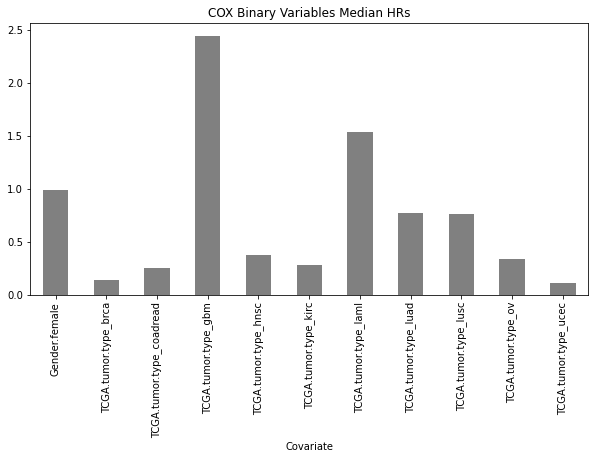

In [28]:
COX_bins = pd.read_csv("summary_coxPH_BINARYVARS.csv")
# get only HR, LB, and UB
COX_bins = COX_bins[["Covariate", "HR", "LB", "UB"]]
# COX_bins.Covariate
list_HRs = [[COX_bins['HR'][i], COX_bins['LB'][i], COX_bins['UB'][i]] for i in range(len(COX_bins['Covariate']))]
df_cox_bins = pd.DataFrame(list_HRs, 
                           columns = ["medianHR", "LB_HR", "UB_HR"], 
                           index = COX_bins['Covariate'])

# print(df_cox_bins)
errors = np.array([list(df_cox_bins.medianHR - df_cox_bins.LB_HR),list(df_cox_bins.UB_HR - df_cox_bins.medianHR)])
errorsDict["COX"] = errors
ax = df_cox_bins.medianHR.plot.bar(rot=90, color = "Gray",
                          title = "COX Binary Variables Median HRs")
#errors as yerr as 2D numpy array for lower and upper bounds
plt.errorbar(myBinCols, df_cox_bins.medianHR, yerr = errors, ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'cox_bin_only_limcovs.png')

{'COX': array([[0.14221705, 0.05427614, 0.12750574, 0.86824693, 0.13213907,
        0.10257341, 0.58378447, 0.29937351, 0.277919  , 0.12575027,
        0.05245083],
       [0.16605175, 0.08849844, 0.25484463, 1.34637172, 0.20356968,
        0.16057834, 0.94021136, 0.48699728, 0.43692148, 0.19967064,
        0.09840905]]), 'XGB': array([[0.08642364, 0.08726905, 0.32714403, 1.02612019, 0.14145792,
        0.14510322, 0.42856526, 0.1174829 , 0.16868651, 0.08641559,
        0.155619  ],
       [0.04075778, 0.09160525, 0.10090935, 1.44040346, 0.10885972,
        0.14171785, 0.72596252, 0.28746367, 0.34604383, 0.03841227,
        0.18622065]])}


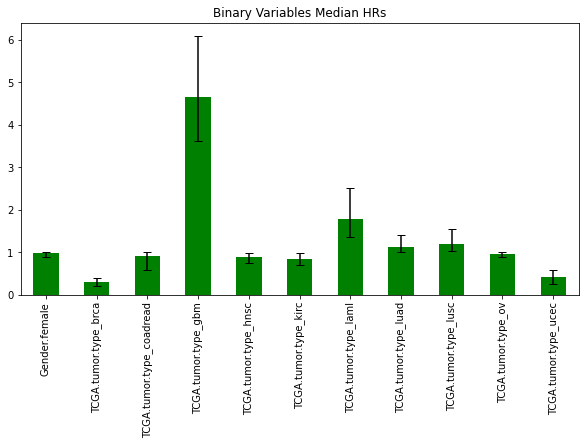

In [33]:
myBins = [mySummaries[i] for i in range(len(mySummaries)) if (X_features[i] in myBinCols)]
myConts = [mySummaries[i] for i in range(len(mySummaries)) if (X_features[i] in myContinuousCols)]
df_binaries = pd.DataFrame(myBins, columns = ["medianHR", "LB_HR", "UB_HR"], index = myBinCols)
df_contins = pd.DataFrame(myConts, columns = ["medianHR", "LB_HR", "UB_HR"], index = myContinuousCols)
errorsCont = np.array([list(df_contins.medianHR - df_contins.LB_HR),list(df_contins.UB_HR - df_contins.medianHR)])
errors = np.array([list(df_binaries.medianHR - df_binaries.LB_HR),list(df_binaries.UB_HR - df_binaries.medianHR)])
errorsDict["XGB"] = errors
errorsDictCont["XGB"] = errorsCont
print(errorsDict)
#Binary Variables
ax = df_binaries.medianHR.plot.bar(rot=90, color = "Green",
                                   title = "Binary Variables Median HRs")
plt.errorbar(myBinCols, df_binaries.medianHR, yerr = errors, ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'xgb_bin_only_limcovs.png')

                               COX       XGB
Gender.female             0.990799  0.977698
TCGA.tumor.type_brca      0.140357  0.299675
TCGA.tumor.type_coadread  0.255179  0.904865
TCGA.tumor.type_gbm       2.444933  4.654963
TCGA.tumor.type_hnsc      0.376582  0.886397
TCGA.tumor.type_kirc      0.283960  0.835837
TCGA.tumor.type_laml      1.539953  1.792635
TCGA.tumor.type_luad      0.777056  1.121944
TCGA.tumor.type_lusc      0.763691  1.193330
TCGA.tumor.type_ov        0.339671  0.967860
TCGA.tumor.type_ucec      0.112311  0.408348


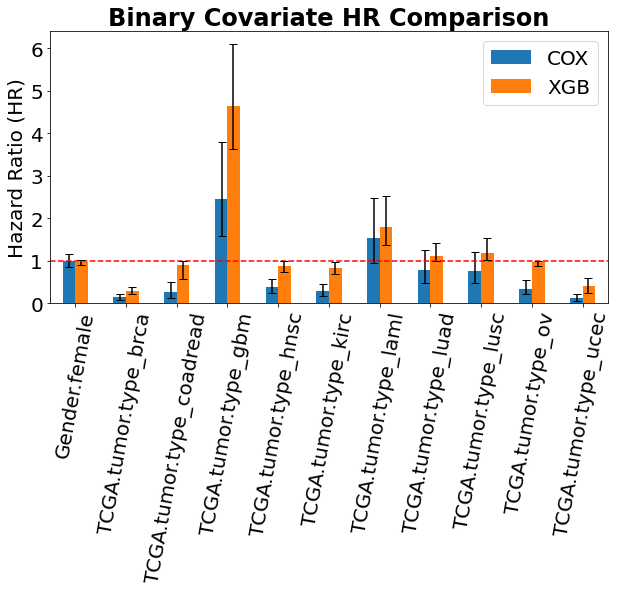

In [34]:
#binary overlay plot
total_plot = pd.DataFrame({"COX":list(df_cox_bins.medianHR), 
                          "XGB":list(df_binaries.medianHR)},
                         index = myBinCols)
print(total_plot)
bounds_upper = pd.DataFrame({"COX":list(df_cox_bins.UB_HR), 
                        "XGB":list(df_binaries.UB_HR)},
                         index = myBinCols)
bounds_lower = pd.DataFrame({"COX":list(df_cox_bins.LB_HR), 
                        "XGB":list(df_binaries.LB_HR)},
                         index = myBinCols)

cats = myBinCols
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax = total_plot.plot.bar(rot=80)
ax.set_title(label = "Binary Covariate HR Comparison", size = 24, weight = 'heavy')
ax.axhline(y=1 , color='r', linestyle='--')
ax.set_ylabel("Hazard Ratio (HR)", fontsize = 20)
plt.errorbar(x1, df_binaries.medianHR, yerr = errorsDict["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_bins.medianHR, yerr = errorsDict["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.savefig(save_to + 'bin_comparison_limcovs.png')

In [35]:
cox_conts = pd.read_csv("summary_coxPH_CONTVARS.csv")
myList = list(cox_conts.iloc[0])
HRs_cont = []
# print(int(len(myList) / 3))
for i in range(int(len(myList)/3)):
    HRs_cont.append([myList[(3*i)], 
                     myList[(3*i) + 1], 
                     myList[(3*i) + 2]])
# print(HRs_cont)
df_cox_conts = pd.DataFrame(HRs_cont, index = myContinuousCols, columns = ["medianHR", "LB_HR", "UB_HR"])
print(df_cox_conts)
errorsCont2 = np.array([list(df_cox_conts.medianHR - df_cox_conts.LB_HR),list(df_cox_conts.UB_HR - df_cox_conts.medianHR)])
errorsDictCont["COX"] = errorsCont2



                                      medianHR     LB_HR     UB_HR
Years.to.birth                        1.654461  1.502739  1.821501
Date.of.initial.pathologic.diagnosis  0.868733  0.797005  0.946915
Somatic.mutations                     0.499785  0.230887  1.081846
Nonsilent.somatic.mutations           1.850022  0.853472  4.010184
Tumor.stage                           1.554821  1.430358  1.690114


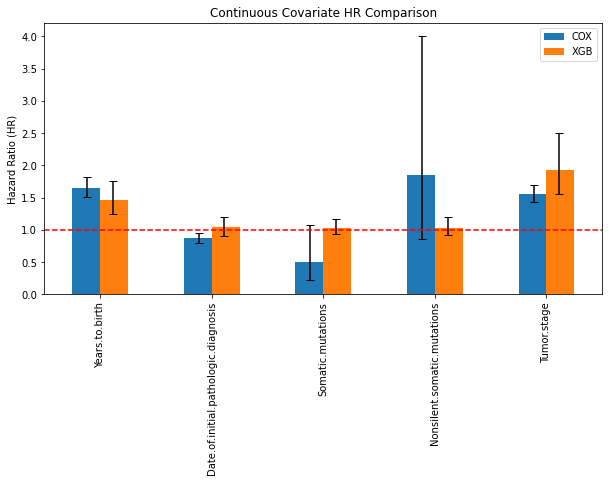

In [36]:
#Continuous Variables
total_plot = pd.DataFrame({"COX":list(df_cox_conts.medianHR), 
                          "XGB":list(df_contins.medianHR)},
                         index = myContinuousCols)
# print(total_plot)
bounds_upper = pd.DataFrame({"COX":list(df_cox_conts.UB_HR), 
                        "XGB":list(df_contins.UB_HR)},
                         index = myContinuousCols)
bounds_lower = pd.DataFrame({"COX":list(df_cox_conts.LB_HR), 
                        "XGB":list(df_contins.LB_HR)},
                         index = myContinuousCols)

cats = myContinuousCols
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax = total_plot.plot.bar(rot=90, title = "Continuous Covariate HR Comparison")
ax.axhline(y=1 , color='r', linestyle='--')
ax.set_ylabel("Hazard Ratio (HR)")
plt.errorbar(x1, df_contins.medianHR, yerr = errorsDictCont["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_conts.medianHR, yerr = errorsDictCont["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'nonbin_comparison_limcovs.png')

[0]	eval-cox-nloglik:5.37545	train-cox-nloglik:6.78129
[250]	eval-cox-nloglik:5.02304	train-cox-nloglik:6.36258
[500]	eval-cox-nloglik:4.96845	train-cox-nloglik:6.25728
[750]	eval-cox-nloglik:4.95181	train-cox-nloglik:6.19345
[999]	eval-cox-nloglik:4.94476	train-cox-nloglik:6.14065


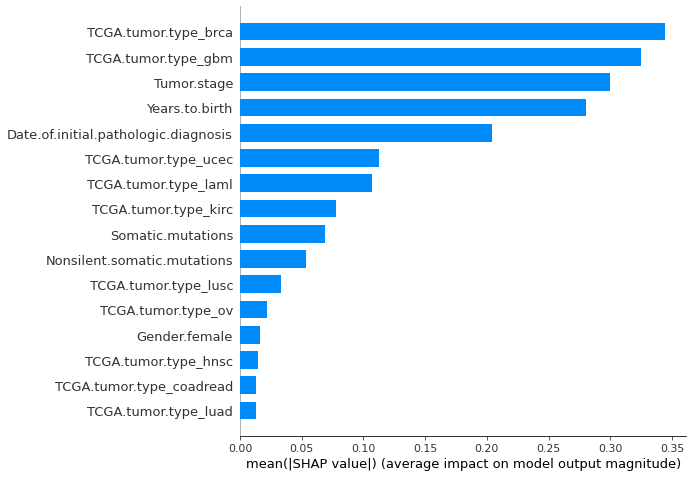

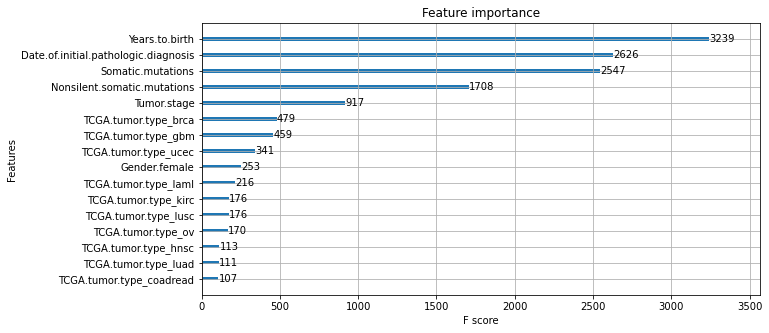

In [37]:
xgb_model_test = xgboost.train(xgb_best_hyperparams, dtrain, 1000,
                          evals=watchlist,
                          verbose_eval=250)
shap.summary_plot(shap_values_full, X_nature, plot_type="bar")
xgboost.plot_importance(model_train)

# All Covariates (Including Gene Binary Covs) (Repeating above analysis)

In [61]:
All_nature = pd.read_csv("XGB_NATURE_ALL_normalized.csv")
X_nature_id = All_nature['Sample.ID']
X_nature_all = All_nature.drop(columns = ['Sample.ID','SURV_DAY_XGB', 'time_event', 'Vital.status'])
y_nature = All_nature['SURV_DAY_XGB']
y_nature.head()

0   -389
1    223
2     81
3    205
4    200
Name: SURV_DAY_XGB, dtype: int64

In [62]:
X_nature_all

Gender.female  Years.to.birth  Date.of.initial.pathologic.diagnosis  \
0                 0        0.763889                              0.913043   
1                 1        0.541667                              0.956522   
2                 0        0.652778                              0.956522   
3                 0        0.611111                              0.956522   
4                 0        0.791667                              0.826087   
...             ...             ...                                   ...   
2907              1        0.902778                              0.956522   
2908              1        0.666667                              0.869565   
2909              1        0.736111                              0.739130   
2910              1        0.555556                              0.739130   
2911              1        0.638889                              0.913043   

      Somatic.mutations  Nonsilent.somatic.mutations  Tumor.stage  \
0              0.103918                     0.097491     0.000000   
1              0.069847                     0.070251     0.666667   
2              0.086315                     0.082437     1.000000   
3              0.145940                     0.132616     0.666667   
4              0.038047                     0.036559     1.000000   
...                 ...                          ...          ...   
2907           0.034639                     0.035125     0.666667   
2908           0.026122                     0.029391     0.000000   
2909           0.059625                     0.058781     0.333333   
2910           0.034072                     0.037276     0.666667   
2911           0.042589                     0.039427     0.333333   

      TCGA.tumor.type_brca  TCGA.tumor.type_coadread  TCGA.tumor.type_gbm  \
0                        0                         0                    0   
1                        0                         0                    0   
2                        0                         0                    0   
3                        0                         0                    0   
4                        0                         0                    0   
...                    ...                       ...                  ...   
2907                     0                         0                    0   
2908                     0                         0                    0   
2909                     0                         0                    0   
2910                     0                         0                    0   
2911                     0                         0                    0   

      TCGA.tumor.type_hnsc  ...  TGFBR2  TLR4  TP53  TSHZ2  TSHZ3  U2AF1  \
0                        0  ...       0     0     0      0      0      0   
1                        0  ...       0     0     0      0      0      0   
2                        0  ...       0     0     1      0      0      0   
3                        0  ...       0     0     1      0      0      0   
4                        0  ...       0     0     0      0      0      0   
...                    ...  ...     ...   ...   ...    ...    ...    ...   
2907                     0  ...       0     0     1      0      0      0   
2908                     0  ...       0     0     1      0      0      0   
2909                     0  ...       0     0     1      0      0      0   
2910                     0  ...       0     0     1      0      0      0   
2911                     0  ...       0     0     1      0      0      0   

      USP9X  VEZF1  VHL  WT1  
0         0      0    0    0  
1         0      0    0    0  
2         0      0    0    0  
3         0      0    0    0  
4         0      0    0    0  
...     ...    ...  ...  ...  
2907      0      0    0    0  
2908      0      0    0    0  
2909      0      0    0    0  
2910      0      0    0    0  
2911      0      0    0    0  

[2912 rows x 143 columns]

## Hyperparams with all covariates

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_nature_all, y_nature, test_size=0.2, random_state=20)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_nature_all, y_nature, test_size=0.2, random_state=20)
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams_all = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams_all)

---- Running XGBoost ----
Training with params:                                  
{'eta': 0.16296788447239316, 'max_depth': 7, 'min_child_weight': 1.3349158713590408, 'objective': 'survival:cox', 'reg_alpha': 0.12178541662770921, 'reg_lambda': 0.07407811360156044, 'subsample': 0.8281809623646684}
[0]	eval-cox-nloglik:5.03866	train-cox-nloglik:6.34462 

[250]	eval-cox-nloglik:5.99642	train-cox-nloglik:4.20528

[500]	eval-cox-nloglik:7.17074	train-cox-nloglik:3.74820

[750]	eval-cox-nloglik:7.82827	train-cox-nloglik:3.60854

[999]	eval-cox-nloglik:8.23063	train-cox-nloglik:3.64261

[0]	eval-cox-nloglik:4.95204	train-cox-nloglik:6.37153 

[250]	eval-cox-nloglik:5.63160	train-cox-nloglik:4.27814

[500]	eval-cox-nloglik:6.65725	train-cox-nloglik:3.82915

[750]	eval-cox-nloglik:7.65277	train-cox-nloglik:3.66388

[999]	eval-cox-nloglik:8.50938	train-cox-nloglik:3.66517

[0]	eval-cox-nloglik:5.04017	train-cox-nloglik:6.33024 

[250]	eval-cox-nloglik:5.93245	train-cox-nloglik:4.25129

[500]	eva

[250]	eval-cox-nloglik:14.51758	train-cox-nloglik:3.96088                         

[500]	eval-cox-nloglik:15.06141	train-cox-nloglik:4.53175                         

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                  

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                  

	Score 0.0                                                                        


Training with params:                                                             
{'eta': 0.05563789751637769, 'max_depth': 4, 'min_child_weight': 0.013429872585441562, 'objective': 'survival:cox', 'reg_alpha': 0.08173108851711969, 'reg_lambda': 0.9831111511089284, 'subsample': 0.8186187271863002}
[0]	eval-cox-nloglik:5.18199	train-cox-nloglik:6.50496                            

[250]	eval-cox-nloglik:4.79869	train-cox-nloglik:5.53804                          

[500]	eval-cox-nloglik:4.91235	train-cox-nloglik:5.24724                          

[750]	eval-cox-nloglik:5.03

[500]	eval-cox-nloglik:4.78091	train-cox-nloglik:6.07500                           

[750]	eval-cox-nloglik:4.72850	train-cox-nloglik:5.94794                           

[999]	eval-cox-nloglik:4.70240	train-cox-nloglik:5.85206                           

[0]	eval-cox-nloglik:5.16478	train-cox-nloglik:6.56641                             

[250]	eval-cox-nloglik:4.97369	train-cox-nloglik:6.22627                           

[500]	eval-cox-nloglik:4.89500	train-cox-nloglik:6.03137                           

[750]	eval-cox-nloglik:4.86254	train-cox-nloglik:5.89926                           

[999]	eval-cox-nloglik:4.85040	train-cox-nloglik:5.80100                           

[0]	eval-cox-nloglik:5.21072	train-cox-nloglik:6.55252                             

[250]	eval-cox-nloglik:5.00404	train-cox-nloglik:6.21649                           

[500]	eval-cox-nloglik:4.91747	train-cox-nloglik:6.02801                           

[750]	eval-cox-nloglik:4.87778	train-cox-nloglik:5.90002         

[250]	eval-cox-nloglik:4.87920	train-cox-nloglik:5.70694                           

[500]	eval-cox-nloglik:5.00442	train-cox-nloglik:5.49484                           

[750]	eval-cox-nloglik:5.11273	train-cox-nloglik:5.33266                           

[999]	eval-cox-nloglik:5.19310	train-cox-nloglik:5.20235                           

	Score 0.7500184944336336                                                          


Training with params:                                                              
{'eta': 0.007134549380715754, 'max_depth': 5, 'min_child_weight': 0.3938911447658714, 'objective': 'survival:cox', 'reg_alpha': 2.8533999560404677, 'reg_lambda': 0.06790886683476399, 'subsample': 0.9138236590997413}
[0]	eval-cox-nloglik:5.22196	train-cox-nloglik:6.54516                             

[250]	eval-cox-nloglik:4.80959	train-cox-nloglik:6.04080                           

[500]	eval-cox-nloglik:4.77394	train-cox-nloglik:5.88999                           

[750]	eval-cox-nlog

[0]	eval-cox-nloglik:5.22617	train-cox-nloglik:6.55008                             

[250]	eval-cox-nloglik:4.94287	train-cox-nloglik:6.28248                           

[500]	eval-cox-nloglik:4.84193	train-cox-nloglik:6.19067                           

[750]	eval-cox-nloglik:4.79942	train-cox-nloglik:6.14096                           

[999]	eval-cox-nloglik:4.77830	train-cox-nloglik:6.10737                           

[0]	eval-cox-nloglik:5.09788	train-cox-nloglik:6.58172                             

[250]	eval-cox-nloglik:4.82836	train-cox-nloglik:6.30207                           

[500]	eval-cox-nloglik:4.74089	train-cox-nloglik:6.20692                           

[750]	eval-cox-nloglik:4.69723	train-cox-nloglik:6.16022                           

[999]	eval-cox-nloglik:4.67215	train-cox-nloglik:6.13113                           

[0]	eval-cox-nloglik:5.16373	train-cox-nloglik:6.56578                             

[250]	eval-cox-nloglik:4.91551	train-cox-nloglik:6.26712         

[999]	eval-cox-nloglik:4.92405	train-cox-nloglik:5.59830                           

[0]	eval-cox-nloglik:5.15345	train-cox-nloglik:6.47474                             

[250]	eval-cox-nloglik:4.87824	train-cox-nloglik:5.74036                           

[500]	eval-cox-nloglik:4.90166	train-cox-nloglik:5.67472                           

[750]	eval-cox-nloglik:4.92289	train-cox-nloglik:5.63264                           

[999]	eval-cox-nloglik:4.93943	train-cox-nloglik:5.60071                           

[0]	eval-cox-nloglik:5.12675	train-cox-nloglik:6.48833                             

[250]	eval-cox-nloglik:4.83693	train-cox-nloglik:5.72782                           

[500]	eval-cox-nloglik:4.86613	train-cox-nloglik:5.65089                           

[750]	eval-cox-nloglik:4.88759	train-cox-nloglik:5.60844                           

[999]	eval-cox-nloglik:4.90735	train-cox-nloglik:5.57162                           

	Score 0.7671648477711747                                        

[500]	eval-cox-nloglik:4.95283	train-cox-nloglik:6.27768                         

[750]	eval-cox-nloglik:4.89669	train-cox-nloglik:6.21597                         

[999]	eval-cox-nloglik:4.85771	train-cox-nloglik:6.17046                         

[0]	eval-cox-nloglik:5.09919	train-cox-nloglik:6.58292                           

[250]	eval-cox-nloglik:4.92891	train-cox-nloglik:6.40059                         

[500]	eval-cox-nloglik:4.84567	train-cox-nloglik:6.30588                         

[750]	eval-cox-nloglik:4.79297	train-cox-nloglik:6.24094                         

[999]	eval-cox-nloglik:4.75705	train-cox-nloglik:6.19333                         

[0]	eval-cox-nloglik:5.16512	train-cox-nloglik:6.56677                           

[250]	eval-cox-nloglik:5.00662	train-cox-nloglik:6.36657                         

[500]	eval-cox-nloglik:4.93489	train-cox-nloglik:6.26814                         

[750]	eval-cox-nloglik:4.89066	train-cox-nloglik:6.19991                         

[999

[0]	eval-cox-nloglik:5.08837	train-cox-nloglik:6.46857                             

[250]	eval-cox-nloglik:5.05303	train-cox-nloglik:5.58885                           

[500]	eval-cox-nloglik:5.28523	train-cox-nloglik:5.30781                           

[750]	eval-cox-nloglik:5.51326	train-cox-nloglik:5.13303                           

[999]	eval-cox-nloglik:5.65011	train-cox-nloglik:4.99507                           

	Score 0.7396136837229961                                                          


Training with params:                                                              
{'eta': 0.10997212049442506, 'max_depth': 2, 'min_child_weight': 1.465968785941875, 'objective': 'survival:cox', 'reg_alpha': 0.006447703670947383, 'reg_lambda': 0.001592139385441545, 'subsample': 0.9730182189345056}
[0]	eval-cox-nloglik:5.15414	train-cox-nloglik:6.48535                             

[250]	eval-cox-nloglik:4.80837	train-cox-nloglik:5.82153                           

[500]	eval-cox-nlo

[0]	eval-cox-nloglik:5.07044	train-cox-nloglik:6.53645                             

[250]	eval-cox-nloglik:4.75711	train-cox-nloglik:5.13642                           

[500]	eval-cox-nloglik:4.89277	train-cox-nloglik:4.75966                           

[750]	eval-cox-nloglik:5.22623	train-cox-nloglik:4.50261                           

[999]	eval-cox-nloglik:5.57742	train-cox-nloglik:4.31648                           

[0]	eval-cox-nloglik:5.13767	train-cox-nloglik:6.51291                             

[250]	eval-cox-nloglik:5.11685	train-cox-nloglik:5.08155                           

[500]	eval-cox-nloglik:5.55614	train-cox-nloglik:4.69072                           

[750]	eval-cox-nloglik:6.18018	train-cox-nloglik:4.43201                           

[999]	eval-cox-nloglik:6.66755	train-cox-nloglik:4.23899                           

[0]	eval-cox-nloglik:5.17792	train-cox-nloglik:6.50085                             

[250]	eval-cox-nloglik:5.18203	train-cox-nloglik:5.07280         

[999]	eval-cox-nloglik:4.88952	train-cox-nloglik:5.54059                           

[0]	eval-cox-nloglik:5.18751	train-cox-nloglik:6.55005                             

[250]	eval-cox-nloglik:4.85037	train-cox-nloglik:5.93409                           

[500]	eval-cox-nloglik:4.88025	train-cox-nloglik:5.74014                           

[750]	eval-cox-nloglik:4.92623	train-cox-nloglik:5.60815                           

[999]	eval-cox-nloglik:4.98767	train-cox-nloglik:5.50353                           

	Score 0.7679939171474028                                                          


Training with params:                                                              
{'eta': 0.0022732951480404014, 'max_depth': 4, 'min_child_weight': 1.9968200894720052, 'objective': 'survival:cox', 'reg_alpha': 0.002059587545855154, 'reg_lambda': 0.008049917672865885, 'subsample': 0.9057764036809015}
[0]	eval-cox-nloglik:5.22626	train-cox-nloglik:6.54990                             

[250]	eval-cox-

[999]	eval-cox-nloglik:4.76260	train-cox-nloglik:5.86842                           

[0]	eval-cox-nloglik:5.08523	train-cox-nloglik:6.56837                             

[250]	eval-cox-nloglik:4.65897	train-cox-nloglik:6.09300                           

[500]	eval-cox-nloglik:4.64070	train-cox-nloglik:6.01248                           

[750]	eval-cox-nloglik:4.64109	train-cox-nloglik:5.95692                           

[999]	eval-cox-nloglik:4.64113	train-cox-nloglik:5.91258                           

[0]	eval-cox-nloglik:5.15325	train-cox-nloglik:6.55351                             

[250]	eval-cox-nloglik:4.81071	train-cox-nloglik:6.04795                           

[500]	eval-cox-nloglik:4.81477	train-cox-nloglik:5.96087                           

[750]	eval-cox-nloglik:4.82460	train-cox-nloglik:5.89980                           

[999]	eval-cox-nloglik:4.84299	train-cox-nloglik:5.85493                           

[0]	eval-cox-nloglik:5.19820	train-cox-nloglik:6.53840           

[750]	eval-cox-nloglik:4.84120	train-cox-nloglik:5.94210                           

[999]	eval-cox-nloglik:4.85303	train-cox-nloglik:5.89844                           

[0]	eval-cox-nloglik:5.18771	train-cox-nloglik:6.54887                             

[250]	eval-cox-nloglik:4.81517	train-cox-nloglik:6.08626                           

[500]	eval-cox-nloglik:4.81141	train-cox-nloglik:5.99133                           

[750]	eval-cox-nloglik:4.81655	train-cox-nloglik:5.92977                           

[999]	eval-cox-nloglik:4.83375	train-cox-nloglik:5.88335                           

	Score 0.7722013965858749                                                          


Training with params:                                                              
{'eta': 0.022384218337248157, 'max_depth': 2, 'min_child_weight': 0.0013247630432193615, 'objective': 'survival:cox', 'reg_alpha': 0.9549408713004011, 'reg_lambda': 6.8995544043072154, 'subsample': 0.8254798698908807}
[0]	eval-cox-nlog

[750]	eval-cox-nloglik:5.00940	train-cox-nloglik:5.19434                           

[999]	eval-cox-nloglik:5.07393	train-cox-nloglik:5.10018                           

[0]	eval-cox-nloglik:5.06221	train-cox-nloglik:6.54033                             

[250]	eval-cox-nloglik:4.67455	train-cox-nloglik:5.57607                           

[500]	eval-cox-nloglik:4.72909	train-cox-nloglik:5.37294                           

[750]	eval-cox-nloglik:4.75951	train-cox-nloglik:5.24451                           

[999]	eval-cox-nloglik:4.79405	train-cox-nloglik:5.15171                           

[0]	eval-cox-nloglik:5.13323	train-cox-nloglik:6.52325                             

[250]	eval-cox-nloglik:4.88407	train-cox-nloglik:5.54541                           

[500]	eval-cox-nloglik:4.98932	train-cox-nloglik:5.34367                           

[750]	eval-cox-nloglik:5.06977	train-cox-nloglik:5.21852                           

[999]	eval-cox-nloglik:5.13004	train-cox-nloglik:5.12317         

[500]	eval-cox-nloglik:6.03819	train-cox-nloglik:4.58286                           

[750]	eval-cox-nloglik:6.43984	train-cox-nloglik:4.32376                           

[999]	eval-cox-nloglik:6.89209	train-cox-nloglik:4.14501                           

[0]	eval-cox-nloglik:5.03351	train-cox-nloglik:6.38722                             

[250]	eval-cox-nloglik:5.57737	train-cox-nloglik:4.95670                           

[500]	eval-cox-nloglik:6.14835	train-cox-nloglik:4.52743                           

[750]	eval-cox-nloglik:6.72610	train-cox-nloglik:4.26496                           

[999]	eval-cox-nloglik:7.16784	train-cox-nloglik:4.08410                           

	Score 0.733169653463106                                                           


Training with params:                                                              
{'eta': 0.024985681150351276, 'max_depth': 9, 'min_child_weight': 0.0053240173399772255, 'objective': 'survival:cox', 'reg_alpha': 0.275543870214968, 

[500]	eval-cox-nloglik:4.75821	train-cox-nloglik:5.91840                           

[750]	eval-cox-nloglik:4.77686	train-cox-nloglik:5.85326                           

[999]	eval-cox-nloglik:4.79029	train-cox-nloglik:5.80044                           

[0]	eval-cox-nloglik:5.07170	train-cox-nloglik:6.55435                             

[250]	eval-cox-nloglik:4.63756	train-cox-nloglik:6.04156                           

[500]	eval-cox-nloglik:4.62607	train-cox-nloglik:5.95810                           

[750]	eval-cox-nloglik:4.63023	train-cox-nloglik:5.89882                           

[999]	eval-cox-nloglik:4.63758	train-cox-nloglik:5.85059                           

[0]	eval-cox-nloglik:5.14155	train-cox-nloglik:6.54026                             

[250]	eval-cox-nloglik:4.80905	train-cox-nloglik:5.99575                           

[500]	eval-cox-nloglik:4.82425	train-cox-nloglik:5.90212                           

[750]	eval-cox-nloglik:4.85339	train-cox-nloglik:5.84007         

[250]	eval-cox-nloglik:4.85226	train-cox-nloglik:5.82516                           

[500]	eval-cox-nloglik:4.85393	train-cox-nloglik:5.59336                           

[750]	eval-cox-nloglik:4.89262	train-cox-nloglik:5.44587                           

[999]	eval-cox-nloglik:4.94410	train-cox-nloglik:5.33022                           

[0]	eval-cox-nloglik:5.18939	train-cox-nloglik:6.55107                             

[250]	eval-cox-nloglik:4.82254	train-cox-nloglik:5.81259                           

[500]	eval-cox-nloglik:4.88256	train-cox-nloglik:5.56363                           

[750]	eval-cox-nloglik:4.96905	train-cox-nloglik:5.40400                           

[999]	eval-cox-nloglik:5.06656	train-cox-nloglik:5.27729                           

	Score 0.7668108442905084                                                          


Training with params:                                                              
{'eta': 0.002671351600376568, 'max_depth': 5, 'min_child_weight':

In [41]:
xgb_best_hyperparams_all['max_depth']=round(xgb_best_hyperparams['max_depth'])
xgb_best_hyperparams_all['objective']="survival:cox"
print(xgb_best_hyperparams_all)

{'eta': 0.022384218337248157, 'max_depth': 4, 'min_child_weight': 0.0013247630432193615, 'reg_alpha': 0.9549408713004011, 'reg_lambda': 6.8995544043072154, 'subsample': 0.8254798698908807, 'objective': 'survival:cox'}


## KFold CV with ALL Covs 

In [64]:
xgb_scores_all =[]
xgb_best_hyperparams_all = {'eta': 0.007449161105952048, 'max_depth': 2, 
                            'min_child_weight': 0.09222984863332333, 
                            'reg_alpha': 0.0012663564847494864, 
                            'reg_lambda': 3.199633776140112, 'subsample': 0.8547238508623453, 
                            'objective': 'survival:cox'}
n_folds = 5
num_boost_round=1000
skf = KFold(n_splits=n_folds)
c = 1
#k-fold CV 
for train_index, val_index in skf.split(X_train): 
    print ("Round", c, "Start")
    start = time.time()
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        
    dtrain = xgboost.DMatrix(X_tr, label=y_tr)
    dval = xgboost.DMatrix(X_val, label=y_val)

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    xgb_model = xgboost.train(xgb_best_hyperparams_all, dtrain, num_boost_round,
                          evals=watchlist,
                          verbose_eval=250)

    predictions = xgb_model.predict(dval,
                                ntree_limit=xgb_model.best_iteration + 1)

    xgb_scores_all.append(c_statistic_harrell(predictions, list(y_val)))
    print("XGB Done")
    end=time.time()
    print("Round", c, "Done:", (end-start)/60, "minutes")
    c += 1

Round 1 Start
[0]	eval-cox-nloglik:5.22437	train-cox-nloglik:6.54846
[250]	eval-cox-nloglik:4.89825	train-cox-nloglik:6.23743
[500]	eval-cox-nloglik:4.81679	train-cox-nloglik:6.14788
[750]	eval-cox-nloglik:4.79047	train-cox-nloglik:6.09698
[999]	eval-cox-nloglik:4.77682	train-cox-nloglik:6.06114
XGB Done
Round 1 Done: 0.025895317395528156 minutes
Round 2 Start
[0]	eval-cox-nloglik:5.09631	train-cox-nloglik:6.57998
[250]	eval-cox-nloglik:4.79103	train-cox-nloglik:6.25955
[500]	eval-cox-nloglik:4.71605	train-cox-nloglik:6.16789
[750]	eval-cox-nloglik:4.68277	train-cox-nloglik:6.12065
[999]	eval-cox-nloglik:4.66433	train-cox-nloglik:6.08849
XGB Done
Round 2 Done: 0.027903282642364503 minutes
Round 3 Start
[0]	eval-cox-nloglik:5.16263	train-cox-nloglik:6.56438
[250]	eval-cox-nloglik:4.88178	train-cox-nloglik:6.22687
[500]	eval-cox-nloglik:4.83245	train-cox-nloglik:6.12846
[750]	eval-cox-nloglik:4.81526	train-cox-nloglik:6.07730
[999]	eval-cox-nloglik:4.80842	train-cox-nloglik:6.04199
XGB D

In [65]:
xgb_scores_all
np.mean(xgb_scores_all)

0.7707676773847046

In [66]:
num_boost_round=1000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dval, 'eval'), (dtrain, 'train')]
xgb_model = xgboost.train(xgb_best_hyperparams_all, dtrain, num_boost_round,
                      evals=watchlist,
                      verbose_eval=250)

predictions = xgb_model.predict(dval,
                            ntree_limit=xgb_model.best_iteration + 1)

xgb_test_score_all = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score_all)

[0]	eval-cox-nloglik:5.37663	train-cox-nloglik:6.78298
[250]	eval-cox-nloglik:5.08177	train-cox-nloglik:6.46199
[500]	eval-cox-nloglik:5.00974	train-cox-nloglik:6.37228
[750]	eval-cox-nloglik:4.97959	train-cox-nloglik:6.32605
[999]	eval-cox-nloglik:4.96838	train-cox-nloglik:6.29430
XGB Done: 0.7908946277339418


In [68]:
full_xy = X_nature_all.copy()
y_labels = y_nature.copy()
full_xy['y'] = y_labels
# X_features = X_nature_all.columns
myHazRatios_all = [[] for i in range(len(X_nature_all.columns))]
myIndexes_all = [i for i in range(len(X_nature_all.columns))]
# print(myHazRatios_all, myIndexes_all)
myBinColsAll = [col for col in X_nature_all.columns if all(X_nature_all[col].value_counts().index.isin([0, 1]))]
myContColsAll = [col for col in X_nature_all.columns if not all(X_nature_all[col].value_counts().index.isin([0, 1]))]

print("My list of binary columns are :", myBinColsAll)

print("\nMy list of nonbin. columns are :", myContColsAll)

My list of binary columns are : ['Gender.female', 'TCGA.tumor.type_brca', 'TCGA.tumor.type_coadread', 'TCGA.tumor.type_gbm', 'TCGA.tumor.type_hnsc', 'TCGA.tumor.type_kirc', 'TCGA.tumor.type_laml', 'TCGA.tumor.type_luad', 'TCGA.tumor.type_lusc', 'TCGA.tumor.type_ov', 'TCGA.tumor.type_ucec', 'ACVR1B', 'ACVR2A', 'AJUBA', 'AKT1', 'APC', 'AR', 'ARHGAP35', 'ARID1A', 'ARID5B', 'ASXL1', 'ATM', 'ATR', 'ATRX', 'AXIN2', 'B4GALT3', 'BAP1', 'BRAF', 'BRCA1', 'BRCA2', 'CBFB', 'CCND1', 'CDH1', 'CDK12', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2C', 'CEBPA', 'CHEK2', 'CRIPAK', 'CTCF', 'CTNNB1', 'DNMT3A', 'EGFR', 'EGR3', 'EIF4A2', 'ELF3', 'EP300', 'EPHA3', 'EPHB6', 'EPPK1', 'ERBB4', 'ERCC2', 'EZH2', 'FBXW7', 'FGFR2', 'FGFR3', 'FLT3', 'FOXA1', 'FOXA2', 'GATA3', 'H3F3C', 'HGF', 'HIST1H1C', 'HIST1H2BD', 'IDH1', 'IDH2', 'KDM5C', 'KDM6A', 'KEAP1', 'KIT', 'KRAS', 'LIFR', 'LRRK2', 'MALAT1', 'MAP2K4', 'MAP3K1', 'MAPK8IP1', 'MECOM', 'MIR142', 'MLL2', 'MLL3', 'MLL4', 'MTOR', 'NAV3', 'NCOR1', 'NF1', 'NFE2L2', 'NFE2L3', '

In [69]:
#bootstrap!
for i in range(1, 1001):
#   sample with replacement:
    X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
    y_train = X_train['y'] #y train are X_trains y column
    X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
    X_test = full_xy.drop(X_train.index) #test features are the full - X_train
    y_test = X_test['y'] #y test are X_tests y column
    X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    model_train = xgboost.train(xgb_best_hyperparams_all, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
    shap_values_full_all = shap.TreeExplainer(model_train).shap_values(X_nature_all)
    
#   let's build a list of HazRatios indexing by j columns
    for j in range(len(myIndexes_all)):
        curSHAP = shap_values_full_all[:, j]
        curCol = X_nature_all.columns[j]
        # if continuous, split by median
        if (curCol in myContColsAll):
            myMed = X_nature_all[curCol].median() 
            myHazRatios_all[j].append(np.mean(np.exp(curSHAP[X_nature_all[curCol] >= myMed])) #changed to mean
                                  /np.mean(np.exp(curSHAP[X_nature_all[curCol] < myMed]))) #changed to mean
        # else, split by 1 or 0
        else:
            myHazRatios_all[j].append(np.mean(np.exp(curSHAP[X_nature_all[curCol] == 1]))
                                  /np.mean(np.exp(curSHAP[X_nature_all[curCol] == 0])))

  
#Done!

### Get Cov Median HR, LB and UB (ALL Covs)

In [65]:
# myHazRatios 
# indexed by column index
X_features_all = X_nature_all.columns
# create a list of lists of length 4: [[Median, Mean, LB, UB], [...]]
mySummaries_all = []
for i in range(len(myHazRatios_all)):
    myHazRatios_all[i].sort()
    mySummaries_all.append([np.median(myHazRatios_all[i]), 
                                  myHazRatios_all[i][24], myHazRatios_all[i][974]])

# print([i for i in range(len(myHazRatios_all)) if X_features[i] in myContinuousCols])
print(mySummaries_all)

[[0.99468565, 0.92709893, 1.0013299], [1.3569963, 1.1414114, 1.6375213], [0.98169607, 0.9410605, 1.0635871], [1.0106719, 0.97992, 1.1035131], [1.0131801, 0.9629592, 1.1259427], [1.8486478, 1.5261236, 2.2638087], [0.34693938, 0.269448, 0.43483245], [0.9989122, 0.7717196, 1.0], [3.777495, 3.029659, 4.731304], [0.9990053, 0.9434303, 1.0057572], [0.88861245, 0.73717445, 0.98910993], [1.7352432, 1.3565377, 2.2752237], [1.0071669, 0.99975395, 1.2243952], [1.1079006, 1.0, 1.4166185], [0.99966407, 0.99357015, 1.0004791], [0.47741732, 0.31662986, 0.67489505], [1.0, 1.0, 1.0377791], [1.0, 0.99987745, 1.0], [1.0, 0.99909353, 1.0310786], [1.0, 1.0, 1.0001309], [1.0, 0.98631203, 1.0390124], [1.0, 0.9996143, 1.4072295], [1.0, 0.9988552, 1.0051485], [1.0, 0.94348556, 1.0084363], [1.0, 0.96732706, 1.0018529], [1.0, 0.9964793, 1.001886], [1.0, 0.99660784, 1.0475363], [1.0, 0.9975344, 1.0690753], [1.0, 0.9640818, 1.0296208], [1.0, 0.92969793, 1.0], [1.0, 1.0, 1.0], [1.0428298, 0.99962384, 1.5093279], [0

### Binary Variable Graphs ALL Covs

In [33]:
errorsDict_BinAll = {}

In [32]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 10]
myBins_all = [mySummaries_all[i] for i in range(len(mySummaries_all)) if (X_features_all[i] in myBinColsAll)]
myBins_indices_all = [X_features_all[i] for i in range(len(mySummaries_all)) if (X_features_all[i] in myBinColsAll)]
df_binaries_all = pd.DataFrame(myBins_all, columns = ["medianHR", "LB_HR", "UB_HR"], index = myBins_indices_all)
errors_bin_all = np.array([list(df_binaries_all.medianHR - df_binaries_all.LB_HR),list(df_binaries_all.UB_HR - df_binaries_all.medianHR)])
errorsDict_BinAll["XGB"] = errors_bin_all
print(errorsDict)
#Binary Variables
ax_bin_all = df_binaries_all.medianHR.plot.bar(rot=90, color = "Green",
                                   title = "Binary Variables Median HRs ALL COVS")
ax_bin_all.axhline(y=1 , color='r', linestyle='--')
plt.errorbar(myBins_indices_all, df_binaries_all.medianHR, yerr = errors_bin_all, ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'bin_allcovs_XGB.png')

NameError: name 'mySummaries_all' is not defined

In [34]:
COX_bins_all = pd.read_csv("summary_coxPH_BINARYVARS_ALL.csv")
# get only HR, LB, and UB
COX_bins_all = COX_bins_all[["Covariate", "HR", "LB", "UB"]]
# COX_bins.Covariate
list_HRs_all = [[COX_bins_all['HR'][i], COX_bins_all['LB'][i], COX_bins_all['UB'][i]] for i in range(len(COX_bins_all['Covariate']))]
df_cox_bins_all = pd.DataFrame(list_HRs_all, 
                           columns = ["medianHR", "LB_HR", "UB_HR"], 
                           index = COX_bins_all['Covariate'])

errors_bin_cox_all = np.array([list(df_cox_bins_all.medianHR - df_cox_bins_all.LB_HR),list(df_cox_bins_all.UB_HR - df_cox_bins_all.medianHR)])
errorsDict_BinAll["COX"] = errors_bin_cox_all 

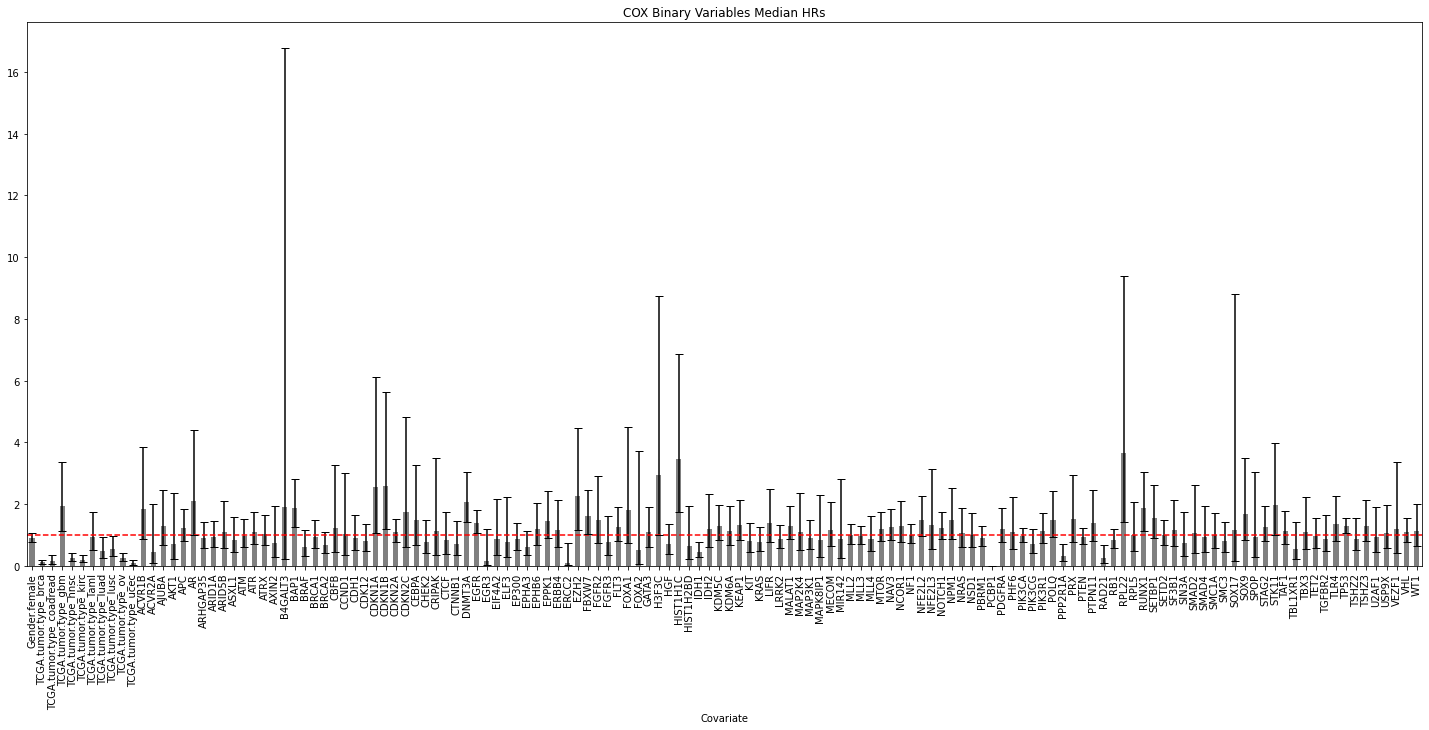

In [67]:
ax_cox_bin_all = df_cox_bins_all.medianHR.plot.bar(rot=90, color = "Gray",
                          title = "COX Binary Variables Median HRs")
ax_cox_bin_all.axhline(y=1 , color='r', linestyle='--')
#errors as yerr as 2D numpy array for lower and upper bounds
plt.errorbar(myBinColsAll, df_cox_bins_all.medianHR, yerr = errors_bin_cox_all, ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'bin_allcovs_COX.png')

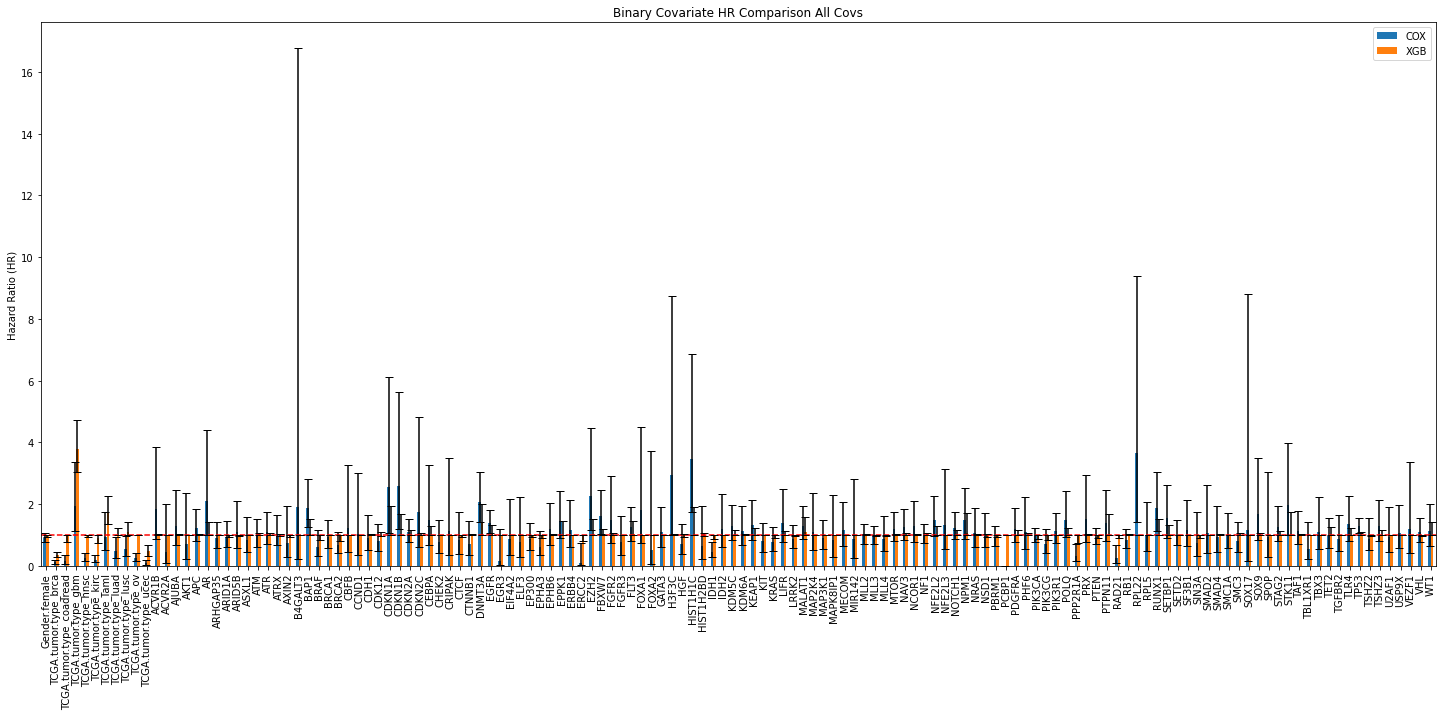

In [68]:
#binary overlay plot, ALL covs
total_plot_all = pd.DataFrame({"COX":list(df_cox_bins_all.medianHR), 
                          "XGB":list(df_binaries_all.medianHR)},
                         index = myBinColsAll)
# print(total_plot_all)
bounds_upper = pd.DataFrame({"COX":list(df_cox_bins_all.UB_HR), 
                        "XGB":list(df_binaries_all.UB_HR)},
                         index = myBinColsAll)
bounds_lower = pd.DataFrame({"COX":list(df_cox_bins_all.LB_HR), 
                        "XGB":list(df_binaries_all.LB_HR)},
                         index = myBinColsAll)

cats = myBinColsAll
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax = total_plot_all.plot.bar(rot=90, title = "Binary Covariate HR Comparison All Covs")
ax.axhline(y=1 , color='r', linestyle='--')
ax.set_ylabel("Hazard Ratio (HR)")
plt.errorbar(x1, df_binaries_all.medianHR, yerr = errorsDict_BinAll["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_bins_all.medianHR, yerr = errorsDict_BinAll["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'bin_allcovs_XGB_COX.png')

In [47]:
cox_conts_all = pd.read_csv("summary_coxPH_NONBINVARS_ALL_natureall.csv")
myList_all = list(cox_conts_all.iloc[0])
HRs_cont_all = []
# print(int(len(myList) / 3))
for i in range(int(len(myList_all)/3)):
    HRs_cont_all.append([myList_all[(3*i)], 
                     myList_all[(3*i) + 1], 
                     myList_all[(3*i) + 2]])

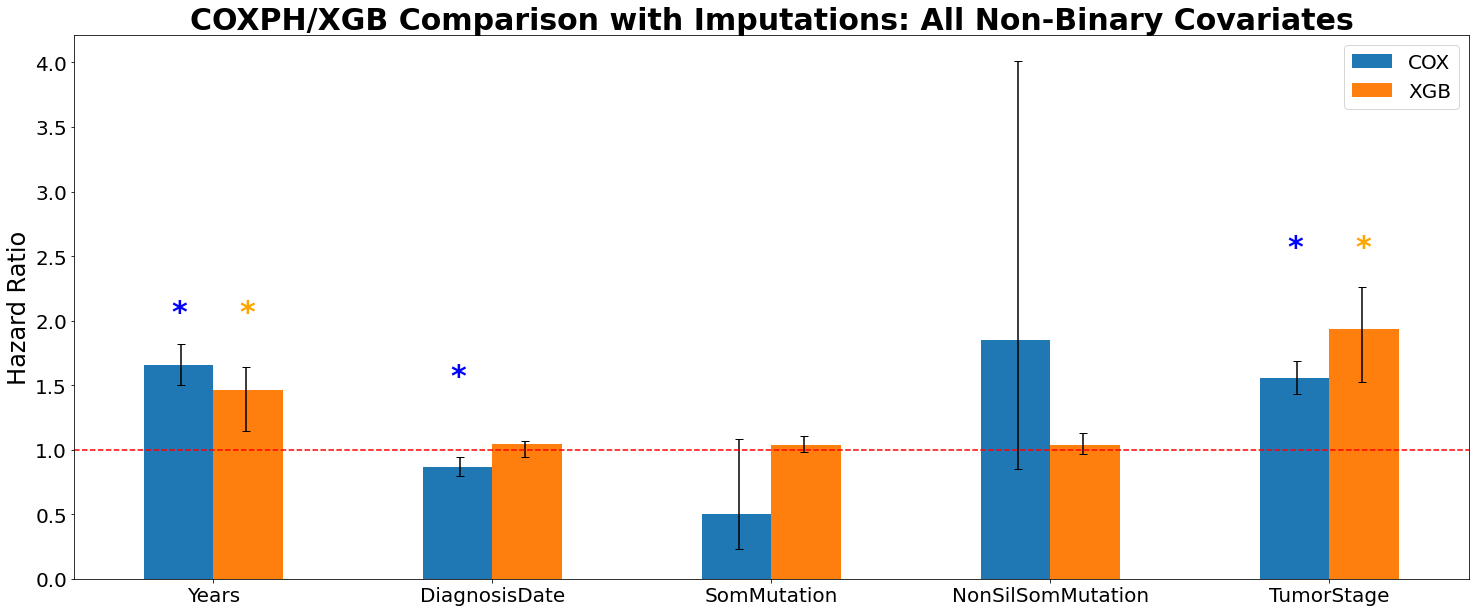

In [69]:
errorsDict_ContAll = {}

# print(HRs_cont)
my_covs_all = ["Years", "DiagnosisDate", "SomMutation", "NonSilSomMutation", "TumorStage"]

df_cox_conts_all = pd.DataFrame(HRs_cont_all, index = my_covs_all, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsContCOXAll = np.array([list(df_cox_conts_all.medianHR - df_cox_conts_all.LB_HR),list(df_cox_conts_all.UB_HR - df_cox_conts_all.medianHR)])
errorsDict_ContAll["COX"] = errorsContCOXAll

myConts_all = [mySummaries_all[i] for i in range(len(mySummaries_all)) if (X_features_all[i] in myContColsAll)]
df_contins_all = pd.DataFrame(myConts_all, columns = ["medianHR", "LB_HR", "UB_HR"], index = my_covs_all)
errorsContXGBAll = np.array([list(df_contins_all.medianHR - df_contins_all.LB_HR),list(df_contins_all.UB_HR - df_contins_all.medianHR)])
errorsDict_ContAll["XGB"] = errorsContXGBAll



#Continuous Variables
total_plot_cont_all = pd.DataFrame({"COX":list(df_cox_conts_all.medianHR), 
                          "XGB":list(df_contins.medianHR)},
                         index = my_covs_all)
# print(total_plot)
bounds_upper_all = pd.DataFrame({"COX":list(df_cox_conts_all.UB_HR), 
                        "XGB":list(df_contins.UB_HR)},
                         index = my_covs_all)
bounds_lower_all = pd.DataFrame({"COX":list(df_cox_conts.LB_HR), 
                        "XGB":list(df_contins.LB_HR)},
                         index = my_covs_all)

cats = myContColsAll
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax = total_plot_cont_all.plot.bar(rot=0)
ax.set_title("COXPH/XGB Comparison with Imputations: All Non-Binary Covariates", fontsize = 30, weight = "heavy")
ax.axhline(y=1 , color='r', linestyle='--')
ax.set_ylabel("Hazard Ratio", fontsize = 24)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(fontsize = 20)
plt.errorbar(x1, df_contins_all.medianHR, yerr = errorsDict_ContAll["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_conts_all.medianHR, yerr = errorsDict_ContAll["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.text(0-.15, 2, "*", fontsize= 30,weight="heavy", color = "Blue")
plt.text(0+.092, 2, "*", fontsize= 30, weight="heavy", color = "Orange")
plt.text(1-.15, 1.5, "*", fontsize= 30, weight="heavy", color = "Blue")
plt.text(4-.15, 2.5, "*", fontsize= 30, weight="heavy", color = "Blue")
plt.text(4+.092, 2.5, "*", fontsize= 30, weight="heavy", color = "Orange")
plt.savefig(save_to + 'non_bin_allcovs_XGB_COX.png')


                      medianHR     LB_HR     UB_HR
Years.to.birth        1.356996  1.141411  1.637521
Tumor.stage           1.848648  1.526124  2.263809
TCGA.tumor.type_brca  0.346939  0.269448  0.434832
TCGA.tumor.type_gbm   3.777495  3.029659  4.731304
TCGA.tumor.type_kirc  0.888612  0.737174  0.989110
TCGA.tumor.type_laml  1.735243  1.356538  2.275224
TCGA.tumor.type_ucec  0.477417  0.316630  0.674895
DNMT3A                1.390712  1.011951  1.999884


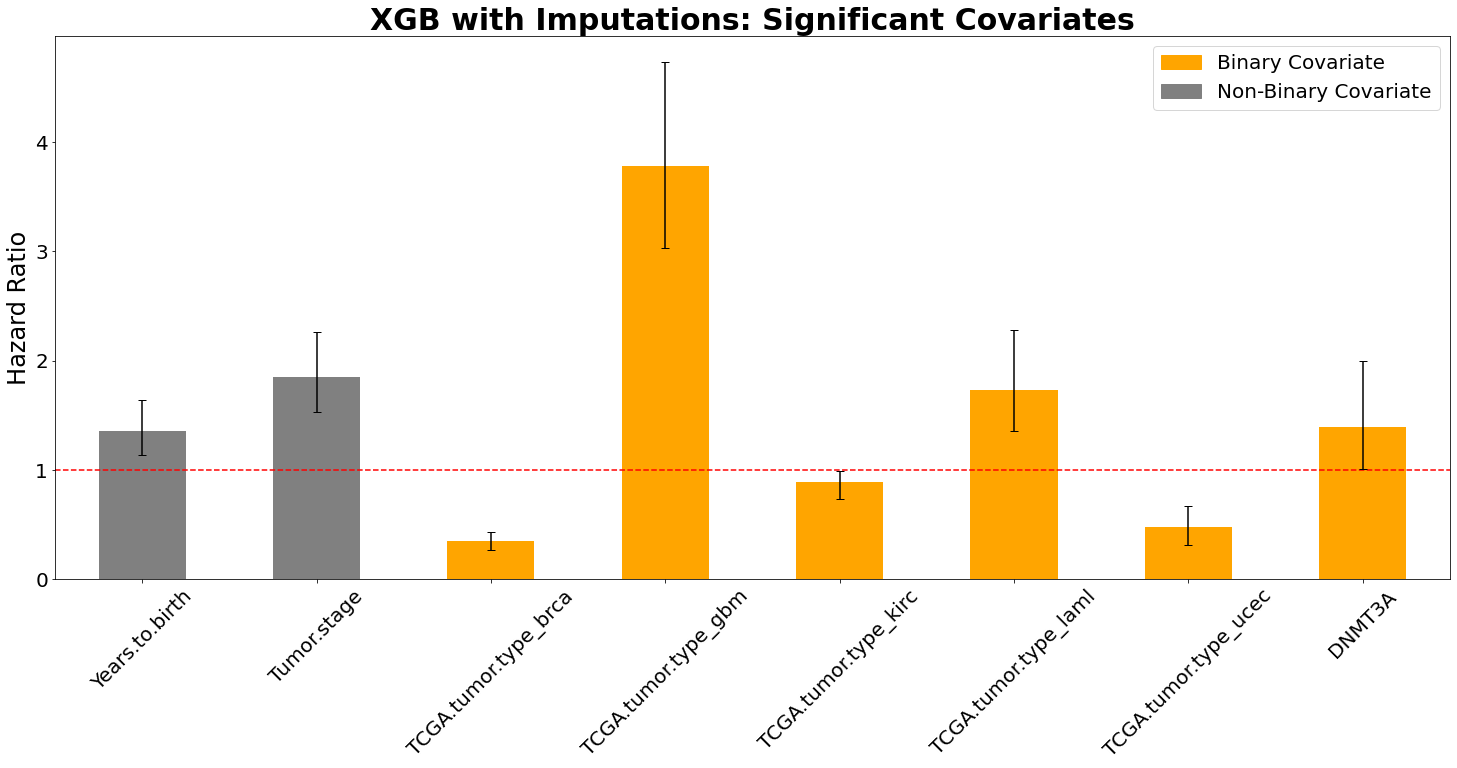

In [71]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 10]
my_SIG_cols_all = [X_features_all[i] for i in range(len(mySummaries_all)) if ((mySummaries_all[i][1] > 1 and mySummaries_all[i][2] > 1) 
                                                                           or (mySummaries_all[i][1] < 1 and mySummaries_all[i][2] < 1))]

my_SIG_all = [mySummaries_all[i] for i in range(len(mySummaries_all)) if ((mySummaries_all[i][1] > 1 and mySummaries_all[i][2] > 1) 
                                                                            or (mySummaries_all[i][1] < 1 and mySummaries_all[i][2] < 1))]
# my_SIG_cols_all = ["Years", "TumorStage", "TYPE_BRCA", "TYPE_GBM", 
#                "TYPE_KIRC", "TYPE_LAML","TYPE_LUSC",
#                "TYPE_UCEC", "DNMT3A"]
# my_SIG_cols_all =['Years',
#  'TumorStage',
#  'TYPE_BRCA',
#  'TYPE_GBM',
#  'TYPE_HNCS',
#  'TYPE_KIRC',
#  'TYPE_LAML',
#  'TYPE_LUSC',
#  'TYPE_OV',
#  'TYPE_UCEC',
#  'BAP1',
#  'DNMT3A',
#  'EGFR',
#  'IDH1',
#  'MALAT1',
#  'PIK3CG',
#  'TP53']


df_SIG_all = pd.DataFrame(my_SIG_all, index = my_SIG_cols_all, columns = ["medianHR", "LB_HR", "UB_HR"])
print(df_SIG_all)

errors_SIG_all = np.array([list(df_SIG_all.medianHR - df_SIG_all.LB_HR),list(df_SIG_all.UB_HR - df_SIG_all.medianHR)])

# get plot colors
colors = []
for i in range(9):
    if (i == 0 or i==1) :
        colors.append("Grey")
    else:
        colors.append("Orange")
        
Or = mpatches.Patch(color='Orange', label='Binary Covariate')
Gr = mpatches.Patch(color='Grey', label='Non-Binary Covariate')

ax_SIG_all = df_SIG_all.medianHR.plot.bar(rot=45, color = colors)
ax_SIG_all.set_title("XGB with Imputations: Significant Covariates", fontsize = 30, weight = "heavy")
ax_SIG_all.axhline(y=1 , color='r', linestyle='--')
ax_SIG_all.set_ylabel("Hazard Ratio", fontsize = 24)
for label in (ax_SIG_all.get_xticklabels() + ax_SIG_all.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(handles=[Or, Gr], loc=1, fontsize = 20)
plt.errorbar(my_SIG_cols_all, df_SIG_all.medianHR, yerr = errors_SIG_all, ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'sigonly_allcovs_XGB.png')


In [72]:
origCols = list(X_features_all)
origCols = origCols[1:6] + origCols[:1] + origCols[6:]
origCols

['Years.to.birth',
 'Date.of.initial.pathologic.diagnosis',
 'Somatic.mutations',
 'Nonsilent.somatic.mutations',
 'Tumor.stage',
 'Gender.female',
 'TCGA.tumor.type_brca',
 'TCGA.tumor.type_coadread',
 'TCGA.tumor.type_gbm',
 'TCGA.tumor.type_hnsc',
 'TCGA.tumor.type_kirc',
 'TCGA.tumor.type_laml',
 'TCGA.tumor.type_luad',
 'TCGA.tumor.type_lusc',
 'TCGA.tumor.type_ov',
 'TCGA.tumor.type_ucec',
 'ACVR1B',
 'ACVR2A',
 'AJUBA',
 'AKT1',
 'APC',
 'AR',
 'ARHGAP35',
 'ARID1A',
 'ARID5B',
 'ASXL1',
 'ATM',
 'ATR',
 'ATRX',
 'AXIN2',
 'B4GALT3',
 'BAP1',
 'BRAF',
 'BRCA1',
 'BRCA2',
 'CBFB',
 'CCND1',
 'CDH1',
 'CDK12',
 'CDKN1A',
 'CDKN1B',
 'CDKN2A',
 'CDKN2C',
 'CEBPA',
 'CHEK2',
 'CRIPAK',
 'CTCF',
 'CTNNB1',
 'DNMT3A',
 'EGFR',
 'EGR3',
 'EIF4A2',
 'ELF3',
 'EP300',
 'EPHA3',
 'EPHB6',
 'EPPK1',
 'ERBB4',
 'ERCC2',
 'EZH2',
 'FBXW7',
 'FGFR2',
 'FGFR3',
 'FLT3',
 'FOXA1',
 'FOXA2',
 'GATA3',
 'H3F3C',
 'HGF',
 'HIST1H1C',
 'HIST1H2BD',
 'IDH1',
 'IDH2',
 'KDM5C',
 'KDM6A',
 'KEAP1',
 '

In [73]:
X_features

Index(['Gender.female', 'Years.to.birth',
       'Date.of.initial.pathologic.diagnosis', 'Somatic.mutations',
       'Nonsilent.somatic.mutations', 'Tumor.stage', 'TCGA.tumor.type_brca',
       'TCGA.tumor.type_coadread', 'TCGA.tumor.type_gbm',
       'TCGA.tumor.type_hnsc', 'TCGA.tumor.type_kirc', 'TCGA.tumor.type_laml',
       'TCGA.tumor.type_luad', 'TCGA.tumor.type_lusc', 'TCGA.tumor.type_ov',
       'TCGA.tumor.type_ucec'],
      dtype='object')

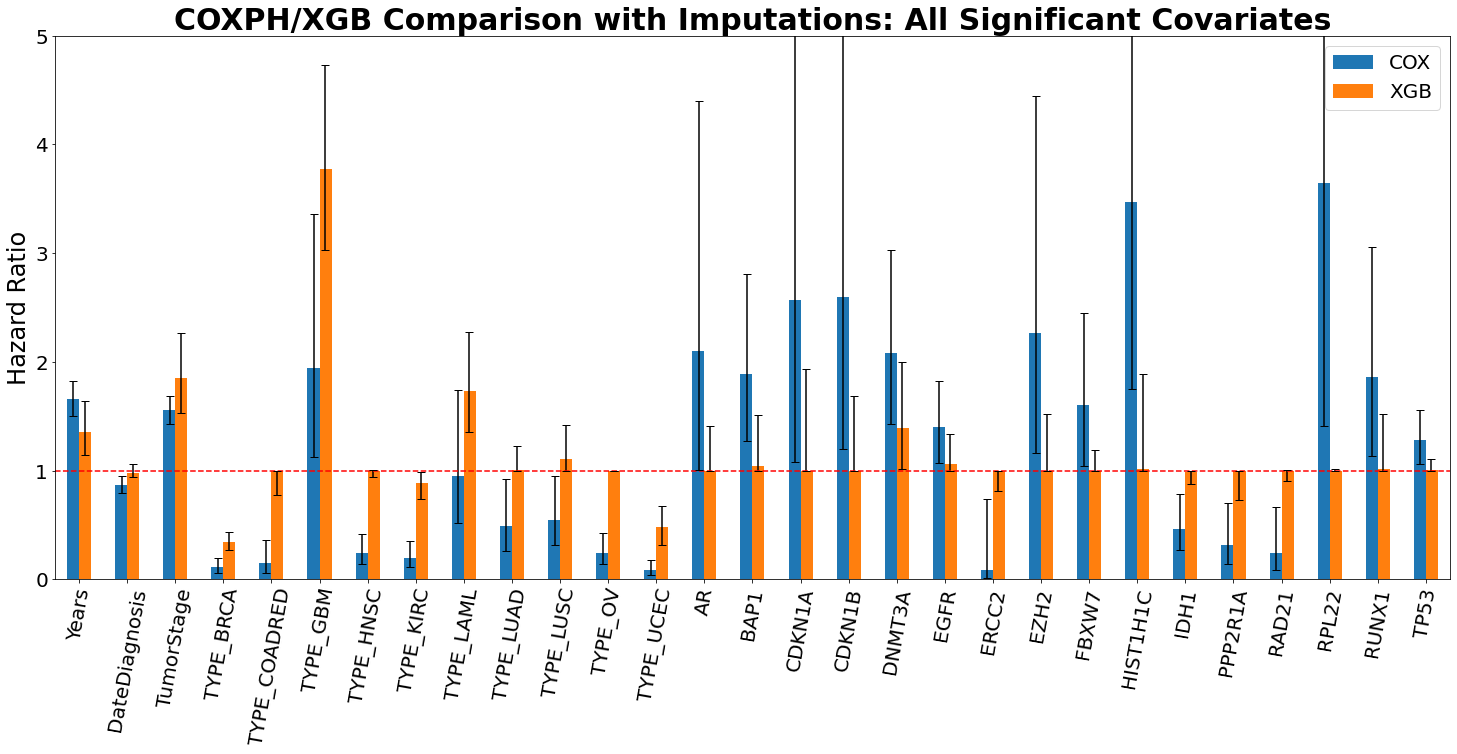

In [74]:
#append lists
errorsDictSig = {}
totalCoxList =  HRs_cont_all + list_HRs_all 
mySummaries_reor = mySummaries_all[1:6] + mySummaries_all[:1] + mySummaries_all[6:]
#get the union of all sig covs
all_sig_covs = [origCols[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]

# all_sig_covs_names = [tup[0] for tup in all_sig_covs]
# all_sig_covs_numInd = [tup[1] for tup in all_sig_covs]
xgb_sig_covs = [mySummaries_reor[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]

cox_sig_covs = [totalCoxList[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]


#rename
all_sig_covs = ["Years", "DateDiagnosis", "TumorStage", "TYPE_BRCA", "TYPE_COADRED", "TYPE_GBM", 
               "TYPE_HNSC", "TYPE_KIRC", "TYPE_LAML", "TYPE_LUAD", "TYPE_LUSC", "TYPE_OV",
               "TYPE_UCEC", 'AR','BAP1','CDKN1A','CDKN1B','DNMT3A','EGFR','ERCC2','EZH2','FBXW7','HIST1H1C','IDH1','PPP2R1A',
                'RAD21','RPL22','RUNX1','TP53']



df_cox_sig_all = pd.DataFrame(cox_sig_covs, index = all_sig_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsCoxSig = np.array([list(df_cox_sig_all.medianHR - df_cox_sig_all.LB_HR),list(df_cox_sig_all.UB_HR - df_cox_sig_all.medianHR)])
errorsDictSig["COX"] = errorsCoxSig

df_xgb_sig_all = pd.DataFrame(xgb_sig_covs, index = all_sig_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
errorsXGBSig = np.array([list(df_xgb_sig_all.medianHR - df_xgb_sig_all.LB_HR),list(df_xgb_sig_all.UB_HR - df_xgb_sig_all.medianHR)])
errorsDictSig["XGB"] = errorsXGBSig

#All Sig Variables
total_plot_sig_all = pd.DataFrame({"COX":list(df_cox_sig_all.medianHR), 
                          "XGB":list(df_xgb_sig_all.medianHR)},
                         index = all_sig_covs)
# print(total_plot)
bounds_upper_sig = pd.DataFrame({"COX":list(df_cox_sig_all.UB_HR), 
                        "XGB":list(df_xgb_sig_all.UB_HR)},
                         index = all_sig_covs)
bounds_lower_sig = pd.DataFrame({"COX":list(df_cox_sig_all.LB_HR), 
                        "XGB":list(df_xgb_sig_all.LB_HR)},
                         index = all_sig_covs)


cats = all_sig_covs
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax_sig = total_plot_sig_all.plot.bar(rot=80)
ax_sig.set_title("COXPH/XGB Comparison with Imputations: All Significant Covariates", fontsize = 30, weight = "heavy")
ax_sig.axhline(y=1 , color='r', linestyle='--')
ax_sig.set_ylabel("Hazard Ratio", fontsize = 24)
ax_sig.set_ylim((0, 5))
for label in (ax_sig.get_xticklabels() + ax_sig.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_sig_all.medianHR, yerr = errorsDictSig["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_sig_all.medianHR, yerr = errorsDictSig["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'sigonly_allcovs_XGB_COX_Imputations.png')

In [ ]:
print("median = ", mySummaries_reor[58][0], "LB = ",mySummaries_reor[58][1], "UB =", mySummaries_reor[58][2])

In [ ]:
cox_sig_covs

# XGB All Covs (not imputed, nImp)

In [4]:
All_nature_nImp = pd.read_csv("XGB_NATURE_ALL_noimputing_normalized.csv")
X_nature_id = All_nature_nImp['Sample.ID']
X_nature_nImp = All_nature_nImp.drop(columns = ['Sample.ID','SURV_DAY_XGB', 'time_event', 'Vital.status'])
y_nature = All_nature_nImp['SURV_DAY_XGB']
y_nature.head()

0   -389
1    223
2     81
3    205
4    200
Name: SURV_DAY_XGB, dtype: int64

In [5]:
X_nature_nImp

Years.to.birth  Date.of.initial.pathologic.diagnosis  Somatic.mutations  \
0           0.763889                              0.913043           0.103918   
1           0.541667                              0.956522           0.069847   
2           0.652778                              0.956522           0.086315   
3           0.611111                              0.956522           0.145940   
4           0.791667                              0.826087           0.038047   
...              ...                                   ...                ...   
2907        0.902778                              0.956522           0.034639   
2908        0.666667                              0.869565           0.026122   
2909        0.736111                              0.739130           0.059625   
2910        0.555556                              0.739130           0.034072   
2911        0.638889                              0.913043           0.042589   

      Nonsilent.somatic.mutations  Tumor.stage  ACVR1B  ACVR2A  AJUBA  AKT1  \
0                        0.097491     0.000000       0       0      0     0   
1                        0.070251     0.666667       0       0      0     0   
2                        0.082437     1.000000       0       0      0     0   
3                        0.132616     0.666667       0       0      0     0   
4                        0.036559     1.000000       0       0      0     0   
...                           ...          ...     ...     ...    ...   ...   
2907                     0.035125     0.666667       0       0      0     0   
2908                     0.029391     0.000000       0       0      0     0   
2909                     0.058781     0.333333       0       0      0     0   
2910                     0.037276     0.666667       0       0      0     0   
2911                     0.039427     0.333333       0       0      0     0   

      APC  ...  TCGA.tumor.type_brca  TCGA.tumor.type_coadread  \
0       0  ...                     0                         0   
1       0  ...                     0                         0   
2       0  ...                     0                         0   
3       0  ...                     0                         0   
4       0  ...                     0                         0   
...   ...  ...                   ...                       ...   
2907    0  ...                     0                         0   
2908    0  ...                     0                         0   
2909    0  ...                     0                         0   
2910    0  ...                     0                         0   
2911    0  ...                     0                         0   

      TCGA.tumor.type_gbm  TCGA.tumor.type_hnsc  TCGA.tumor.type_kirc  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
...                   ...                   ...                   ...   
2907                    0                     0                     0   
2908                    0                     0                     0   
2909                    0                     0                     0   
2910                    0                     0                     0   
2911                    0                     0                     0   

      TCGA.tumor.type_laml  TCGA.tumor.type_luad  TCGA.tumor.type_lusc  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                  

## Run Hyperparameter Tuning with No Imputations

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_nature_nImp, y_nature, test_size=0.2, random_state=20)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_nature_nImp, y_nature, test_size=0.2, random_state=20)
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams_nImp = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams_nImp)

---- Running XGBoost ----
Training with params:                                  
{'eta': 0.17978771085797682, 'max_depth': 6, 'min_child_weight': 0.21693075147601631, 'objective': 'survival:cox', 'reg_alpha': 0.028002563255177026, 'reg_lambda': 2.415843174581237, 'subsample': 0.8653085125627773}
[0]	eval-cox-nloglik:5.07914	train-cox-nloglik:6.38284 

[250]	eval-cox-nloglik:5.92239	train-cox-nloglik:4.43899

[500]	eval-cox-nloglik:6.89865	train-cox-nloglik:3.99839

[750]	eval-cox-nloglik:7.77602	train-cox-nloglik:3.74356

[999]	eval-cox-nloglik:8.41221	train-cox-nloglik:3.59774

[0]	eval-cox-nloglik:4.94003	train-cox-nloglik:6.39025 

[250]	eval-cox-nloglik:5.29984	train-cox-nloglik:4.53583

[500]	eval-cox-nloglik:6.03012	train-cox-nloglik:4.07966

[750]	eval-cox-nloglik:6.76497	train-cox-nloglik:3.81279

[999]	eval-cox-nloglik:7.40817	train-cox-nloglik:3.68569

[0]	eval-cox-nloglik:5.03215	train-cox-nloglik:6.37380 

[250]	eval-cox-nloglik:5.65147	train-cox-nloglik:4.49997

[500]	eva

[750]	eval-cox-nloglik:5.45190	train-cox-nloglik:4.29592                            

[999]	eval-cox-nloglik:5.76345	train-cox-nloglik:4.11177                            

[0]	eval-cox-nloglik:5.17394	train-cox-nloglik:6.52423                              

[250]	eval-cox-nloglik:5.36379	train-cox-nloglik:4.87418                            

[500]	eval-cox-nloglik:6.09201	train-cox-nloglik:4.47783                            

[750]	eval-cox-nloglik:6.74670	train-cox-nloglik:4.22743                            

[999]	eval-cox-nloglik:7.41091	train-cox-nloglik:4.04617                            

	Score 0.7533723041390192                                                           


Training with params:                                                               
{'eta': 0.03810078550298292, 'max_depth': 4, 'min_child_weight': 2.2317229775229874, 'objective': 'survival:cox', 'reg_alpha': 0.010897839294408948, 'reg_lambda': 1.2597851273688452, 'subsample': 0.7775538796048536}
[0]	eval-c

[0]	eval-cox-nloglik:5.19804	train-cox-nloglik:6.52426                               

[250]	eval-cox-nloglik:4.80950	train-cox-nloglik:5.97441                             

[500]	eval-cox-nloglik:4.83965	train-cox-nloglik:5.84656                             

[750]	eval-cox-nloglik:4.88745	train-cox-nloglik:5.75668                             

[999]	eval-cox-nloglik:4.91148	train-cox-nloglik:5.68493                             

[0]	eval-cox-nloglik:5.07431	train-cox-nloglik:6.55585                               

[250]	eval-cox-nloglik:4.66068	train-cox-nloglik:5.99120                             

[500]	eval-cox-nloglik:4.66675	train-cox-nloglik:5.87428                             

[750]	eval-cox-nloglik:4.68794	train-cox-nloglik:5.79437                             

[999]	eval-cox-nloglik:4.69798	train-cox-nloglik:5.73088                             

[0]	eval-cox-nloglik:5.13972	train-cox-nloglik:6.53827                               

[250]	eval-cox-nloglik:4.81112	train-cox-nl

[0]	eval-cox-nloglik:5.13445	train-cox-nloglik:6.52016                               

[250]	eval-cox-nloglik:4.95579	train-cox-nloglik:5.34505                             

[500]	eval-cox-nloglik:5.09867	train-cox-nloglik:5.01365                             

[750]	eval-cox-nloglik:5.28467	train-cox-nloglik:4.75746                             

[999]	eval-cox-nloglik:5.45378	train-cox-nloglik:4.56610                             

[0]	eval-cox-nloglik:5.17543	train-cox-nloglik:6.50826                               

[250]	eval-cox-nloglik:4.92302	train-cox-nloglik:5.36586                             

[500]	eval-cox-nloglik:5.06146	train-cox-nloglik:5.04822                             

[750]	eval-cox-nloglik:5.21419	train-cox-nloglik:4.80908                             

[999]	eval-cox-nloglik:5.40595	train-cox-nloglik:4.62020                             

[0]	eval-cox-nloglik:5.15111	train-cox-nloglik:6.51566                               

[250]	eval-cox-nloglik:5.01091	train-cox-nl

[0]	eval-cox-nloglik:5.19282	train-cox-nloglik:6.55582                               

[250]	eval-cox-nloglik:4.85860	train-cox-nloglik:6.16121                             

[500]	eval-cox-nloglik:4.81307	train-cox-nloglik:6.05629                             

[750]	eval-cox-nloglik:4.80684	train-cox-nloglik:5.99686                             

[999]	eval-cox-nloglik:4.80769	train-cox-nloglik:5.95113                             

	Score 0.7737588745097652                                                            


Training with params:                                                                
{'eta': 0.005467479046379297, 'max_depth': 5, 'min_child_weight': 0.0032327910753950106, 'objective': 'survival:cox', 'reg_alpha': 3.1776950310622967, 'reg_lambda': 0.0010275593562930401, 'subsample': 0.8322937898519217}
[0]	eval-cox-nloglik:5.22285	train-cox-nloglik:6.54643                               

[250]	eval-cox-nloglik:4.81154	train-cox-nloglik:6.04224                           

[250]	eval-cox-nloglik:4.77481	train-cox-nloglik:5.76529                             

[500]	eval-cox-nloglik:4.79268	train-cox-nloglik:5.56001                             

[750]	eval-cox-nloglik:4.84250	train-cox-nloglik:5.41668                             

[999]	eval-cox-nloglik:4.89921	train-cox-nloglik:5.30350                             

[0]	eval-cox-nloglik:5.08908	train-cox-nloglik:6.57138                               

[250]	eval-cox-nloglik:4.68094	train-cox-nloglik:5.80655                             

[500]	eval-cox-nloglik:4.68330	train-cox-nloglik:5.60660                             

[750]	eval-cox-nloglik:4.70704	train-cox-nloglik:5.47585                             

[999]	eval-cox-nloglik:4.73988	train-cox-nloglik:5.36517                             

[0]	eval-cox-nloglik:5.15646	train-cox-nloglik:6.55446                               

[250]	eval-cox-nloglik:4.82324	train-cox-nloglik:5.75570                             

[500]	eval-cox-nloglik:4.85373	train-cox-nl

[500]	eval-cox-nloglik:5.15065	train-cox-nloglik:5.19197                            

[750]	eval-cox-nloglik:5.42699	train-cox-nloglik:4.98586                            

[999]	eval-cox-nloglik:5.56180	train-cox-nloglik:4.82581                            

[0]	eval-cox-nloglik:5.14153	train-cox-nloglik:6.47244                              

[250]	eval-cox-nloglik:4.99297	train-cox-nloglik:5.51500                            

[500]	eval-cox-nloglik:5.12764	train-cox-nloglik:5.22112                            

[750]	eval-cox-nloglik:5.34185	train-cox-nloglik:5.02582                            

[999]	eval-cox-nloglik:5.49278	train-cox-nloglik:4.86982                            

[0]	eval-cox-nloglik:5.11840	train-cox-nloglik:6.47907                              

[250]	eval-cox-nloglik:5.04133	train-cox-nloglik:5.49166                            

[500]	eval-cox-nloglik:5.31680	train-cox-nloglik:5.18872                            

[750]	eval-cox-nloglik:5.63242	train-cox-nloglik:4.996

[999]	eval-cox-nloglik:4.97666	train-cox-nloglik:5.32172                            

	Score 0.7644049005927667                                                           


Training with params:                                                               
{'eta': 0.023565831503498103, 'max_depth': 3, 'min_child_weight': 0.47390671191223205, 'objective': 'survival:cox', 'reg_alpha': 0.0020742723720468107, 'reg_lambda': 0.2699851652768528, 'subsample': 0.8610086399833512}
[0]	eval-cox-nloglik:5.20853	train-cox-nloglik:6.53216                              

[250]	eval-cox-nloglik:4.78428	train-cox-nloglik:5.89989                            

[500]	eval-cox-nloglik:4.82534	train-cox-nloglik:5.74740                            

[750]	eval-cox-nloglik:4.88067	train-cox-nloglik:5.63368                            

[999]	eval-cox-nloglik:4.92526	train-cox-nloglik:5.53706                            

[0]	eval-cox-nloglik:5.08299	train-cox-nloglik:6.56397                              

[250]	e

[500]	eval-cox-nloglik:4.76552	train-cox-nloglik:6.11607                            

[750]	eval-cox-nloglik:4.71891	train-cox-nloglik:6.01765                            

[999]	eval-cox-nloglik:4.69561	train-cox-nloglik:5.95094                            

[0]	eval-cox-nloglik:5.16455	train-cox-nloglik:6.56627                              

[250]	eval-cox-nloglik:4.94760	train-cox-nloglik:6.24660                            

[500]	eval-cox-nloglik:4.86877	train-cox-nloglik:6.08558                            

[750]	eval-cox-nloglik:4.83615	train-cox-nloglik:5.98215                            

[999]	eval-cox-nloglik:4.82181	train-cox-nloglik:5.90942                            

[0]	eval-cox-nloglik:5.21047	train-cox-nloglik:6.55240                              

[250]	eval-cox-nloglik:4.98416	train-cox-nloglik:6.23958                            

[500]	eval-cox-nloglik:4.89694	train-cox-nloglik:6.08911                            

[750]	eval-cox-nloglik:4.85038	train-cox-nloglik:5.993

[999]	eval-cox-nloglik:11.14269	train-cox-nloglik:3.69306                           

[0]	eval-cox-nloglik:5.45436	train-cox-nloglik:6.76307                              

[250]	eval-cox-nloglik:7.65815	train-cox-nloglik:4.34710                            

[500]	eval-cox-nloglik:8.95325	train-cox-nloglik:3.89661                            

[750]	eval-cox-nloglik:10.37745	train-cox-nloglik:3.70368                           

[999]	eval-cox-nloglik:10.74807	train-cox-nloglik:3.62598                           

	Score 0.7118809033182731                                                           


Training with params:                                                               
{'eta': 0.031234619206413797, 'max_depth': 2, 'min_child_weight': 4.1840394504872265, 'objective': 'survival:cox', 'reg_alpha': 0.0031150930091964624, 'reg_lambda': 0.00495128274774247, 'subsample': 0.893014476775664}
[0]	eval-cox-nloglik:5.20549	train-cox-nloglik:6.53033                              

[250]	ev

[500]	eval-cox-nloglik:4.91626	train-cox-nloglik:6.14887                            

[750]	eval-cox-nloglik:4.87471	train-cox-nloglik:6.05781                            

[999]	eval-cox-nloglik:4.84896	train-cox-nloglik:5.99306                            

[0]	eval-cox-nloglik:5.09853	train-cox-nloglik:6.58198                              

[250]	eval-cox-nloglik:4.89773	train-cox-nloglik:6.31252                            

[500]	eval-cox-nloglik:4.80599	train-cox-nloglik:6.16916                            

[750]	eval-cox-nloglik:4.75615	train-cox-nloglik:6.07649                            

[999]	eval-cox-nloglik:4.72768	train-cox-nloglik:6.01124                            

[0]	eval-cox-nloglik:5.16453	train-cox-nloglik:6.56631                              

[250]	eval-cox-nloglik:4.97288	train-cox-nloglik:6.28071                            

[500]	eval-cox-nloglik:4.90032	train-cox-nloglik:6.13578                            

[750]	eval-cox-nloglik:4.86587	train-cox-nloglik:6.038

[999]	eval-cox-nloglik:4.90174	train-cox-nloglik:5.49411                            

[0]	eval-cox-nloglik:5.19657	train-cox-nloglik:6.53548                              

[250]	eval-cox-nloglik:4.81535	train-cox-nloglik:5.89413                            

[500]	eval-cox-nloglik:4.87720	train-cox-nloglik:5.74361                            

[750]	eval-cox-nloglik:4.93595	train-cox-nloglik:5.64053                            

[999]	eval-cox-nloglik:5.00844	train-cox-nloglik:5.54964                            

[0]	eval-cox-nloglik:5.17987	train-cox-nloglik:6.54054                              

[250]	eval-cox-nloglik:4.80566	train-cox-nloglik:5.88162                            

[500]	eval-cox-nloglik:4.83935	train-cox-nloglik:5.72147                            

[750]	eval-cox-nloglik:4.90800	train-cox-nloglik:5.61411                            

[999]	eval-cox-nloglik:5.00358	train-cox-nloglik:5.52095                            

	Score 0.7653101432502412                             

Training with params:                                                               
{'eta': 0.02421419218490164, 'max_depth': 3, 'min_child_weight': 0.008559786241056144, 'objective': 'survival:cox', 'reg_alpha': 0.02449483725319896, 'reg_lambda': 0.0043386187927855245, 'subsample': 0.7961835478165159}
[0]	eval-cox-nloglik:5.21158	train-cox-nloglik:6.52332                              

[250]	eval-cox-nloglik:4.94567	train-cox-nloglik:5.82913                            

[500]	eval-cox-nloglik:5.01889	train-cox-nloglik:5.63129                            

[750]	eval-cox-nloglik:5.06808	train-cox-nloglik:5.48589                            

[999]	eval-cox-nloglik:5.13580	train-cox-nloglik:5.36806                            

[0]	eval-cox-nloglik:5.07014	train-cox-nloglik:6.55488                              

[250]	eval-cox-nloglik:4.70534	train-cox-nloglik:5.85543                            

[500]	eval-cox-nloglik:4.73538	train-cox-nloglik:5.67239                            

[750]	e

[999]	eval-cox-nloglik:4.70221	train-cox-nloglik:6.08199                            

[0]	eval-cox-nloglik:5.16455	train-cox-nloglik:6.56629                              

[250]	eval-cox-nloglik:4.95100	train-cox-nloglik:6.28179                            

[500]	eval-cox-nloglik:4.87684	train-cox-nloglik:6.15832                            

[750]	eval-cox-nloglik:4.84360	train-cox-nloglik:6.08664                            

[999]	eval-cox-nloglik:4.82762	train-cox-nloglik:6.03970                            

[0]	eval-cox-nloglik:5.21036	train-cox-nloglik:6.55242                              

[250]	eval-cox-nloglik:4.99221	train-cox-nloglik:6.27596                            

[500]	eval-cox-nloglik:4.90911	train-cox-nloglik:6.16088                            

[750]	eval-cox-nloglik:4.86513	train-cox-nloglik:6.09631                            

[999]	eval-cox-nloglik:4.83852	train-cox-nloglik:6.05460                            

[0]	eval-cox-nloglik:5.19649	train-cox-nloglik:6.55870

[250]	eval-cox-nloglik:4.80565	train-cox-nloglik:6.08638                            

[500]	eval-cox-nloglik:4.80179	train-cox-nloglik:6.01671                            

[750]	eval-cox-nloglik:4.80822	train-cox-nloglik:5.97769                            

[999]	eval-cox-nloglik:4.81460	train-cox-nloglik:5.94654                            

	Score 0.7711740364710711                                                           


Training with params:                                                               
{'eta': 0.0014290426362485423, 'max_depth': 5, 'min_child_weight': 0.31296480454869974, 'objective': 'survival:cox', 'reg_alpha': 0.07522795030506393, 'reg_lambda': 0.03316211559790238, 'subsample': 0.8540099929955748}
[0]	eval-cox-nloglik:5.22699	train-cox-nloglik:6.55041                              

[250]	eval-cox-nloglik:4.97860	train-cox-nloglik:6.24546                            

[500]	eval-cox-nloglik:4.87706	train-cox-nloglik:6.09186                            

[750]	e

[750]	eval-cox-nloglik:5.26544	train-cox-nloglik:4.57036                             

[999]	eval-cox-nloglik:5.43108	train-cox-nloglik:4.41479                             

[0]	eval-cox-nloglik:5.08629	train-cox-nloglik:6.55789                               

[250]	eval-cox-nloglik:4.91959	train-cox-nloglik:5.16219                             

[500]	eval-cox-nloglik:4.96770	train-cox-nloglik:4.82491                             

[750]	eval-cox-nloglik:5.07641	train-cox-nloglik:4.61318                             

[999]	eval-cox-nloglik:5.18893	train-cox-nloglik:4.46320                             

[0]	eval-cox-nloglik:5.15797	train-cox-nloglik:6.54380                               

[250]	eval-cox-nloglik:4.97959	train-cox-nloglik:5.10781                             

[500]	eval-cox-nloglik:5.16098	train-cox-nloglik:4.76694                             

[750]	eval-cox-nloglik:5.33273	train-cox-nloglik:4.56961                             

[999]	eval-cox-nloglik:5.49282	train-cox-nl

[500]	eval-cox-nloglik:5.07566	train-cox-nloglik:5.16138                              

[750]	eval-cox-nloglik:5.22212	train-cox-nloglik:4.95201                              

[999]	eval-cox-nloglik:5.34908	train-cox-nloglik:4.80336                              

[0]	eval-cox-nloglik:5.15236	train-cox-nloglik:6.48467                                

[250]	eval-cox-nloglik:4.91377	train-cox-nloglik:5.48142                              

[500]	eval-cox-nloglik:5.04352	train-cox-nloglik:5.17805                              

[750]	eval-cox-nloglik:5.17642	train-cox-nloglik:4.98865                              

[999]	eval-cox-nloglik:5.29825	train-cox-nloglik:4.84070                              

[0]	eval-cox-nloglik:5.12384	train-cox-nloglik:6.49458                                

[250]	eval-cox-nloglik:5.00633	train-cox-nloglik:5.44745                              

[500]	eval-cox-nloglik:5.31614	train-cox-nloglik:5.13567                              

[750]	eval-cox-nloglik:5.57683	t

[0]	eval-cox-nloglik:5.17317	train-cox-nloglik:6.52590                                

[250]	eval-cox-nloglik:4.83274	train-cox-nloglik:5.75824                              

[500]	eval-cox-nloglik:4.92845	train-cox-nloglik:5.56166                              

[750]	eval-cox-nloglik:5.05818	train-cox-nloglik:5.42988                              

[999]	eval-cox-nloglik:5.17928	train-cox-nloglik:5.31614                              

	Score 0.757634327075922                                                              


Training with params:                                                                 
{'eta': 0.0018394553053796541, 'max_depth': 2, 'min_child_weight': 0.0029958059381985417, 'objective': 'survival:cox', 'reg_alpha': 3.1307538454372215, 'reg_lambda': 0.5473404671350416, 'subsample': 0.907118015423894}
[0]	eval-cox-nloglik:5.22758	train-cox-nloglik:6.55130                                

[250]	eval-cox-nloglik:5.04589	train-cox-nloglik:6.37712                      

[0]	eval-cox-nloglik:5.22407	train-cox-nloglik:6.54768                                

[250]	eval-cox-nloglik:4.84042	train-cox-nloglik:6.16603                              

[500]	eval-cox-nloglik:4.77656	train-cox-nloglik:6.07830                              

[750]	eval-cox-nloglik:4.76527	train-cox-nloglik:6.02736                              

[999]	eval-cox-nloglik:4.76065	train-cox-nloglik:5.98962                              

[0]	eval-cox-nloglik:5.09620	train-cox-nloglik:6.57970                                

[250]	eval-cox-nloglik:4.74663	train-cox-nloglik:6.17853                              

[500]	eval-cox-nloglik:4.68426	train-cox-nloglik:6.09418                              

[750]	eval-cox-nloglik:4.66737	train-cox-nloglik:6.04858                              

[999]	eval-cox-nloglik:4.65867	train-cox-nloglik:6.01554                              

[0]	eval-cox-nloglik:5.16173	train-cox-nloglik:6.56304                                

[250]	eval-cox-nloglik:4.85050	t

[750]	eval-cox-nloglik:4.67172	train-cox-nloglik:5.80325                              

[999]	eval-cox-nloglik:4.68049	train-cox-nloglik:5.73643                              

[0]	eval-cox-nloglik:5.15614	train-cox-nloglik:6.55619                                

[250]	eval-cox-nloglik:4.81944	train-cox-nloglik:5.94721                              

[500]	eval-cox-nloglik:4.82252	train-cox-nloglik:5.82601                              

[750]	eval-cox-nloglik:4.83880	train-cox-nloglik:5.73700                              

[999]	eval-cox-nloglik:4.86450	train-cox-nloglik:5.66663                              

[0]	eval-cox-nloglik:5.20228	train-cox-nloglik:6.54295                                

[250]	eval-cox-nloglik:4.80752	train-cox-nloglik:5.96470                              

[500]	eval-cox-nloglik:4.81293	train-cox-nloglik:5.84984                              

[750]	eval-cox-nloglik:4.83266	train-cox-nloglik:5.76631                              

[999]	eval-cox-nloglik:4.85256	t

[250]	eval-cox-nloglik:4.91446	train-cox-nloglik:5.97632                              

[500]	eval-cox-nloglik:4.83855	train-cox-nloglik:5.72016                              

[750]	eval-cox-nloglik:4.81944	train-cox-nloglik:5.55735                              

[999]	eval-cox-nloglik:4.82136	train-cox-nloglik:5.43736                              

[0]	eval-cox-nloglik:5.19426	train-cox-nloglik:6.55511                                

[250]	eval-cox-nloglik:4.89344	train-cox-nloglik:5.96297                              

[500]	eval-cox-nloglik:4.84973	train-cox-nloglik:5.70092                              

[750]	eval-cox-nloglik:4.86015	train-cox-nloglik:5.53532                              

[999]	eval-cox-nloglik:4.89665	train-cox-nloglik:5.41325                              

	Score 0.7637010632192768                                                             


Training with params:                                                                 
{'eta': 0.00786987493849984, 'ma

[999]	eval-cox-nloglik:4.84339	train-cox-nloglik:6.13051                              

	Score 0.768115917670164                                                              


Training with params:                                                                 
{'eta': 0.07613346002471638, 'max_depth': 7, 'min_child_weight': 0.060751111886615784, 'objective': 'survival:cox', 'reg_alpha': 8.465026188729624, 'reg_lambda': 0.024114171567746777, 'subsample': 0.9535606011013549}
[0]	eval-cox-nloglik:5.16505	train-cox-nloglik:6.48114                                

[250]	eval-cox-nloglik:4.82050	train-cox-nloglik:5.65206                              

[500]	eval-cox-nloglik:4.86928	train-cox-nloglik:5.56222                              

[750]	eval-cox-nloglik:4.90110	train-cox-nloglik:5.52103                              

[999]	eval-cox-nloglik:4.92712	train-cox-nloglik:5.48473                              

[0]	eval-cox-nloglik:5.03590	train-cox-nloglik:6.50893                         

[0]	eval-cox-nloglik:5.18708	train-cox-nloglik:6.50846                                

[250]	eval-cox-nloglik:4.94328	train-cox-nloglik:5.25979                              

[500]	eval-cox-nloglik:5.15369	train-cox-nloglik:4.88809                              

[750]	eval-cox-nloglik:5.39929	train-cox-nloglik:4.65389                              

[999]	eval-cox-nloglik:5.60951	train-cox-nloglik:4.48433                              

[0]	eval-cox-nloglik:5.06798	train-cox-nloglik:6.54211                                

[250]	eval-cox-nloglik:4.74701	train-cox-nloglik:5.30329                              

[500]	eval-cox-nloglik:4.89732	train-cox-nloglik:4.94171                              

[750]	eval-cox-nloglik:5.06000	train-cox-nloglik:4.72823                              

[999]	eval-cox-nloglik:5.22341	train-cox-nloglik:4.56217                              

[0]	eval-cox-nloglik:5.13150	train-cox-nloglik:6.52253                                

[250]	eval-cox-nloglik:4.98439	t

[750]	eval-cox-nloglik:5.40381	train-cox-nloglik:4.92447                              

[999]	eval-cox-nloglik:5.67197	train-cox-nloglik:4.76718                              

[0]	eval-cox-nloglik:5.08460	train-cox-nloglik:6.46179                                

[250]	eval-cox-nloglik:5.00840	train-cox-nloglik:5.48018                              

[500]	eval-cox-nloglik:5.29027	train-cox-nloglik:5.09161                              

[750]	eval-cox-nloglik:5.43715	train-cox-nloglik:4.86700                              

[999]	eval-cox-nloglik:5.57496	train-cox-nloglik:4.71919                              

[0]	eval-cox-nloglik:5.12258	train-cox-nloglik:6.49306                                

[250]	eval-cox-nloglik:5.34930	train-cox-nloglik:5.41190                              

[500]	eval-cox-nloglik:5.50680	train-cox-nloglik:5.11129                              

[750]	eval-cox-nloglik:5.73562	train-cox-nloglik:4.91645                              

[999]	eval-cox-nloglik:5.87260	t

[250]	eval-cox-nloglik:4.80349	train-cox-nloglik:5.97117                              

[500]	eval-cox-nloglik:4.80637	train-cox-nloglik:5.87530                              

[750]	eval-cox-nloglik:4.80920	train-cox-nloglik:5.81227                              

[999]	eval-cox-nloglik:4.81835	train-cox-nloglik:5.76425                              

[0]	eval-cox-nloglik:5.17664	train-cox-nloglik:6.54120                                

[250]	eval-cox-nloglik:4.79618	train-cox-nloglik:5.96299                              

[500]	eval-cox-nloglik:4.82268	train-cox-nloglik:5.85797                              

[750]	eval-cox-nloglik:4.83932	train-cox-nloglik:5.79049                              

[999]	eval-cox-nloglik:4.85933	train-cox-nloglik:5.73662                              

	Score 0.7691411689433612                                                             


Training with params:                                                                 
{'eta': 0.013922923246361645, 'm

[999]	eval-cox-nloglik:4.86003	train-cox-nloglik:6.17736                              

	Score 0.7651813204487701                                                             


Training with params:                                                                 
{'eta': 0.03999627226675675, 'max_depth': 4, 'min_child_weight': 0.0014843743466894956, 'objective': 'survival:cox', 'reg_alpha': 4.591034137858, 'reg_lambda': 0.03756168785826602, 'subsample': 0.7888181152082796}
[0]	eval-cox-nloglik:5.19278	train-cox-nloglik:6.51801                                

[250]	eval-cox-nloglik:4.80439	train-cox-nloglik:5.79912                              

[500]	eval-cox-nloglik:4.90763	train-cox-nloglik:5.63643                              

[750]	eval-cox-nloglik:4.99345	train-cox-nloglik:5.52492                              

[999]	eval-cox-nloglik:5.07422	train-cox-nloglik:5.44370                              

[0]	eval-cox-nloglik:5.06080	train-cox-nloglik:6.54422                            

[0]	eval-cox-nloglik:5.22039	train-cox-nloglik:6.54432                                

[250]	eval-cox-nloglik:4.78870	train-cox-nloglik:6.08887                              

[500]	eval-cox-nloglik:4.76298	train-cox-nloglik:5.99344                              

[750]	eval-cox-nloglik:4.76306	train-cox-nloglik:5.92676                              

[999]	eval-cox-nloglik:4.77416	train-cox-nloglik:5.87725                              

[0]	eval-cox-nloglik:5.09291	train-cox-nloglik:6.57614                                

[250]	eval-cox-nloglik:4.69246	train-cox-nloglik:6.10871                              

[500]	eval-cox-nloglik:4.65652	train-cox-nloglik:6.01922                              

[750]	eval-cox-nloglik:4.65069	train-cox-nloglik:5.95896                              

[999]	eval-cox-nloglik:4.64582	train-cox-nloglik:5.91212                              

[0]	eval-cox-nloglik:5.15862	train-cox-nloglik:6.55916                                

[250]	eval-cox-nloglik:4.81556	t

[750]	eval-cox-nloglik:4.65565	train-cox-nloglik:6.03020                              

[999]	eval-cox-nloglik:4.64822	train-cox-nloglik:5.99912                              

[0]	eval-cox-nloglik:5.16106	train-cox-nloglik:6.56224                                

[250]	eval-cox-nloglik:4.84904	train-cox-nloglik:6.12020                              

[500]	eval-cox-nloglik:4.82272	train-cox-nloglik:6.03337                              

[750]	eval-cox-nloglik:4.81994	train-cox-nloglik:5.99019                              

[999]	eval-cox-nloglik:4.82106	train-cox-nloglik:5.95945                              

[0]	eval-cox-nloglik:5.20710	train-cox-nloglik:6.54831                                

[250]	eval-cox-nloglik:4.87654	train-cox-nloglik:6.11859                              

[500]	eval-cox-nloglik:4.83276	train-cox-nloglik:6.03667                              

[750]	eval-cox-nloglik:4.81949	train-cox-nloglik:5.99186                              

[999]	eval-cox-nloglik:4.81422	t

[250]	eval-cox-nloglik:5.06065	train-cox-nloglik:6.37622                              

[500]	eval-cox-nloglik:4.99029	train-cox-nloglik:6.29345                              

[750]	eval-cox-nloglik:4.94303	train-cox-nloglik:6.24011                              

[999]	eval-cox-nloglik:4.91005	train-cox-nloglik:6.20121                              

[0]	eval-cox-nloglik:5.19739	train-cox-nloglik:6.55926                                

[250]	eval-cox-nloglik:5.04839	train-cox-nloglik:6.38716                              

[500]	eval-cox-nloglik:4.97473	train-cox-nloglik:6.30227                              

[750]	eval-cox-nloglik:4.92917	train-cox-nloglik:6.24531                              

[999]	eval-cox-nloglik:4.89774	train-cox-nloglik:6.20251                              

	Score 0.7578574768591498                                                             


Training with params:                                                                 
{'eta': 0.029856527686717996, 'm

[999]	eval-cox-nloglik:4.79127	train-cox-nloglik:6.02537                              

	Score 0.7700860631073347                                                             


Training with params:                                                                 
{'eta': 0.7893017515659266, 'max_depth': 5, 'min_child_weight': 0.0021458865368402234, 'objective': 'survival:cox', 'reg_alpha': 0.9861480262876167, 'reg_lambda': 0.03264072044394142, 'subsample': 0.8295257215853404}
[0]	eval-cox-nloglik:9.08872	train-cox-nloglik:11.29093                               

[250]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                      

[500]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                      

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                      

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                      

[0]	eval-cox-nloglik:6.02392	train-cox-nloglik:7.56174                         

[0]	eval-cox-nloglik:5.18279	train-cox-nloglik:6.47783                                

[250]	eval-cox-nloglik:5.18244	train-cox-nloglik:4.85488                              

[500]	eval-cox-nloglik:5.57826	train-cox-nloglik:4.50610                              

[750]	eval-cox-nloglik:5.89619	train-cox-nloglik:4.30138                              

[999]	eval-cox-nloglik:6.15099	train-cox-nloglik:4.17177                              

[0]	eval-cox-nloglik:5.05628	train-cox-nloglik:6.52434                                

[250]	eval-cox-nloglik:4.79035	train-cox-nloglik:4.92514                              

[500]	eval-cox-nloglik:5.01626	train-cox-nloglik:4.56614                              

[750]	eval-cox-nloglik:5.23907	train-cox-nloglik:4.36414                              

[999]	eval-cox-nloglik:5.43666	train-cox-nloglik:4.23514                              

[0]	eval-cox-nloglik:5.12108	train-cox-nloglik:6.50034                                

[250]	eval-cox-nloglik:5.26327	t

[750]	eval-cox-nloglik:4.66956	train-cox-nloglik:5.89592                              

[999]	eval-cox-nloglik:4.66585	train-cox-nloglik:5.83840                              

[0]	eval-cox-nloglik:5.16193	train-cox-nloglik:6.56324                                

[250]	eval-cox-nloglik:4.85300	train-cox-nloglik:6.06886                              

[500]	eval-cox-nloglik:4.82051	train-cox-nloglik:5.92758                              

[750]	eval-cox-nloglik:4.82504	train-cox-nloglik:5.84242                              

[999]	eval-cox-nloglik:4.82961	train-cox-nloglik:5.78094                              

[0]	eval-cox-nloglik:5.20729	train-cox-nloglik:6.54864                                

[250]	eval-cox-nloglik:4.87478	train-cox-nloglik:6.07475                              

[500]	eval-cox-nloglik:4.82029	train-cox-nloglik:5.94667                              

[750]	eval-cox-nloglik:4.81884	train-cox-nloglik:5.86784                              

[999]	eval-cox-nloglik:4.82929	t

[500]	eval-cox-nloglik:4.82556	train-cox-nloglik:5.96603                            

[750]	eval-cox-nloglik:4.82857	train-cox-nloglik:5.89165                            

[999]	eval-cox-nloglik:4.84190	train-cox-nloglik:5.83146                            

[0]	eval-cox-nloglik:5.19122	train-cox-nloglik:6.55267                              

[250]	eval-cox-nloglik:4.81764	train-cox-nloglik:6.06747                            

[500]	eval-cox-nloglik:4.80308	train-cox-nloglik:5.94937                            

[750]	eval-cox-nloglik:4.81113	train-cox-nloglik:5.86914                            

[999]	eval-cox-nloglik:4.82858	train-cox-nloglik:5.80936                            

	Score 0.7731383373609543                                                           


Training with params:                                                               
{'eta': 0.010004148652846098, 'max_depth': 4, 'min_child_weight': 0.016321427814409407, 'objective': 'survival:cox', 'reg_alpha': 0.70451016

Training with params:                                                                 
{'eta': 0.0033285649448385455, 'max_depth': 3, 'min_child_weight': 0.03972000187667678, 'objective': 'survival:cox', 'reg_alpha': 0.44067793882041684, 'reg_lambda': 0.0531706571169235, 'subsample': 0.8568869981785239}
[0]	eval-cox-nloglik:5.22581	train-cox-nloglik:6.54934                                

[250]	eval-cox-nloglik:4.90913	train-cox-nloglik:6.22143                              

[500]	eval-cox-nloglik:4.81806	train-cox-nloglik:6.10691                              

[750]	eval-cox-nloglik:4.79153	train-cox-nloglik:6.03875                              

[999]	eval-cox-nloglik:4.78899	train-cox-nloglik:5.98816                              

[0]	eval-cox-nloglik:5.09736	train-cox-nloglik:6.58115                                

[250]	eval-cox-nloglik:4.80392	train-cox-nloglik:6.24487                              

[500]	eval-cox-nloglik:4.72019	train-cox-nloglik:6.12763                       

[0]	eval-cox-nloglik:5.09813	train-cox-nloglik:6.58217                                

[250]	eval-cox-nloglik:4.87918	train-cox-nloglik:6.35328                              

[500]	eval-cox-nloglik:4.79599	train-cox-nloglik:6.25931                              

[750]	eval-cox-nloglik:4.74887	train-cox-nloglik:6.20457                              

[999]	eval-cox-nloglik:4.72256	train-cox-nloglik:6.16862                              

[0]	eval-cox-nloglik:5.16432	train-cox-nloglik:6.56624                                

[250]	eval-cox-nloglik:4.95488	train-cox-nloglik:6.32723                              

[500]	eval-cox-nloglik:4.88222	train-cox-nloglik:6.23083                              

[750]	eval-cox-nloglik:4.84356	train-cox-nloglik:6.17286                              

[999]	eval-cox-nloglik:4.82310	train-cox-nloglik:6.13220                              

[0]	eval-cox-nloglik:5.21007	train-cox-nloglik:6.55246                                

[250]	eval-cox-nloglik:5.00184	t

[999]	eval-cox-nloglik:4.97302	train-cox-nloglik:5.34808                            

[0]	eval-cox-nloglik:5.20229	train-cox-nloglik:6.53446                              

[250]	eval-cox-nloglik:4.97493	train-cox-nloglik:5.80126                            

[500]	eval-cox-nloglik:5.09209	train-cox-nloglik:5.62693                            

[750]	eval-cox-nloglik:5.19041	train-cox-nloglik:5.49955                            

[999]	eval-cox-nloglik:5.39172	train-cox-nloglik:5.39470                            

[0]	eval-cox-nloglik:5.18359	train-cox-nloglik:6.53999                              

[250]	eval-cox-nloglik:4.87892	train-cox-nloglik:5.78660                            

[500]	eval-cox-nloglik:4.98274	train-cox-nloglik:5.59191                            

[750]	eval-cox-nloglik:5.12895	train-cox-nloglik:5.46563                            

[999]	eval-cox-nloglik:5.24549	train-cox-nloglik:5.36405                            

	Score 0.760189002223915                              

	Score 0.7583045038541842                                                             


Training with params:                                                                 
{'eta': 0.0010082646443658194, 'max_depth': 5, 'min_child_weight': 0.0010110229710715262, 'objective': 'survival:cox', 'reg_alpha': 1.5279171957153526, 'reg_lambda': 0.06524239904137395, 'subsample': 0.8377746979648302}
[0]	eval-cox-nloglik:5.22765	train-cox-nloglik:6.55125                                

[250]	eval-cox-nloglik:5.04105	train-cox-nloglik:6.33602                              

[500]	eval-cox-nloglik:4.94395	train-cox-nloglik:6.21016                              

[750]	eval-cox-nloglik:4.88417	train-cox-nloglik:6.12199                              

[999]	eval-cox-nloglik:4.84606	train-cox-nloglik:6.05650                              

[0]	eval-cox-nloglik:5.09930	train-cox-nloglik:6.58294                                

[250]	eval-cox-nloglik:4.93128	train-cox-nloglik:6.36903                    

[250]	eval-cox-nloglik:4.69136	train-cox-nloglik:6.03555                            

[500]	eval-cox-nloglik:4.66116	train-cox-nloglik:5.90809                            

[750]	eval-cox-nloglik:4.65731	train-cox-nloglik:5.82668                            

[999]	eval-cox-nloglik:4.66060	train-cox-nloglik:5.76309                            

[0]	eval-cox-nloglik:5.15840	train-cox-nloglik:6.55957                              

[250]	eval-cox-nloglik:4.82170	train-cox-nloglik:5.99045                            

[500]	eval-cox-nloglik:4.81928	train-cox-nloglik:5.86245                            

[750]	eval-cox-nloglik:4.83026	train-cox-nloglik:5.77352                            

[999]	eval-cox-nloglik:4.84734	train-cox-nloglik:5.70127                            

[0]	eval-cox-nloglik:5.20411	train-cox-nloglik:6.54472                              

[250]	eval-cox-nloglik:4.81943	train-cox-nloglik:6.00654                            

[500]	eval-cox-nloglik:4.79844	train-cox-nloglik:5.884

[500]	eval-cox-nloglik:4.80870	train-cox-nloglik:5.58840                            

[750]	eval-cox-nloglik:4.83063	train-cox-nloglik:5.42906                            

[999]	eval-cox-nloglik:4.85803	train-cox-nloglik:5.30422                            

[0]	eval-cox-nloglik:5.19132	train-cox-nloglik:6.55264                              

[250]	eval-cox-nloglik:4.83467	train-cox-nloglik:5.80851                            

[500]	eval-cox-nloglik:4.84945	train-cox-nloglik:5.56262                            

[750]	eval-cox-nloglik:4.91504	train-cox-nloglik:5.40156                            

[999]	eval-cox-nloglik:4.99318	train-cox-nloglik:5.27434                            

	Score 0.7655354604196135                                                           


Training with params:                                                                 
{'eta': 0.0015151366532290967, 'max_depth': 5, 'min_child_weight': 0.044575681242928884, 'objective': 'survival:cox', 'reg_alpha': 4.16634

Training with params:                                                               
{'eta': 0.14827311323409495, 'max_depth': 3, 'min_child_weight': 0.015102464024167133, 'objective': 'survival:cox', 'reg_alpha': 2.5111165886290734, 'reg_lambda': 0.0024436032168472645, 'subsample': 0.8762445914213868}
[0]	eval-cox-nloglik:5.10617	train-cox-nloglik:6.43684                              

[250]	eval-cox-nloglik:5.06160	train-cox-nloglik:5.53656                            

[500]	eval-cox-nloglik:5.24946	train-cox-nloglik:5.31285                            

[750]	eval-cox-nloglik:5.34880	train-cox-nloglik:5.16165                            

[999]	eval-cox-nloglik:5.46395	train-cox-nloglik:5.05777                            

[0]	eval-cox-nloglik:4.99855	train-cox-nloglik:6.46921                              

[250]	eval-cox-nloglik:4.71871	train-cox-nloglik:5.59191                            

[500]	eval-cox-nloglik:4.81324	train-cox-nloglik:5.37115                            

[750]	ev

[500]	eval-cox-nloglik:4.65225	train-cox-nloglik:5.71827                            

[750]	eval-cox-nloglik:4.68307	train-cox-nloglik:5.60485                            

[999]	eval-cox-nloglik:4.71571	train-cox-nloglik:5.50491                            

[0]	eval-cox-nloglik:5.14527	train-cox-nloglik:6.54250                              

[250]	eval-cox-nloglik:4.82120	train-cox-nloglik:5.83725                            

[500]	eval-cox-nloglik:4.86268	train-cox-nloglik:5.66857                            

[750]	eval-cox-nloglik:4.91390	train-cox-nloglik:5.53593                            

[999]	eval-cox-nloglik:4.94872	train-cox-nloglik:5.43885                            

[0]	eval-cox-nloglik:5.19090	train-cox-nloglik:6.52848                              

[250]	eval-cox-nloglik:4.83042	train-cox-nloglik:5.86345                            

[500]	eval-cox-nloglik:4.88850	train-cox-nloglik:5.70335                            

[750]	eval-cox-nloglik:4.94016	train-cox-nloglik:5.590

[999]	eval-cox-nloglik:4.83694	train-cox-nloglik:6.10385                            

[0]	eval-cox-nloglik:5.19599	train-cox-nloglik:6.55811                              

[250]	eval-cox-nloglik:4.94147	train-cox-nloglik:6.28097                            

[500]	eval-cox-nloglik:4.86934	train-cox-nloglik:6.18565                            

[750]	eval-cox-nloglik:4.84216	train-cox-nloglik:6.13731                            

[999]	eval-cox-nloglik:4.82894	train-cox-nloglik:6.10656                            

	Score 0.7693544684829273                                                           


Training with params:                                                               
{'eta': 0.03070787883126223, 'max_depth': 4, 'min_child_weight': 1.9195732750931347, 'objective': 'survival:cox', 'reg_alpha': 5.419205264895102, 'reg_lambda': 0.10806211976375206, 'subsample': 0.8947037684302558}
[0]	eval-cox-nloglik:5.20376	train-cox-nloglik:6.52756                              

[250]	eval-c

[0]	eval-cox-nloglik:5.22429	train-cox-nloglik:6.54814                                

[250]	eval-cox-nloglik:4.86095	train-cox-nloglik:6.18926                              

[500]	eval-cox-nloglik:4.78677	train-cox-nloglik:6.09971                              

[750]	eval-cox-nloglik:4.76767	train-cox-nloglik:6.04883                              

[999]	eval-cox-nloglik:4.76258	train-cox-nloglik:6.01197                              

[0]	eval-cox-nloglik:5.09624	train-cox-nloglik:6.57965                                

[250]	eval-cox-nloglik:4.76265	train-cox-nloglik:6.20570                              

[500]	eval-cox-nloglik:4.69264	train-cox-nloglik:6.11522                              

[750]	eval-cox-nloglik:4.66912	train-cox-nloglik:6.06910                              

[999]	eval-cox-nloglik:4.66120	train-cox-nloglik:6.03639                              

[0]	eval-cox-nloglik:5.16197	train-cox-nloglik:6.56348                                

[250]	eval-cox-nloglik:4.86404	t

[750]	eval-cox-nloglik:4.68217	train-cox-nloglik:6.10445                              

[999]	eval-cox-nloglik:4.66640	train-cox-nloglik:6.07676                              

[0]	eval-cox-nloglik:5.16302	train-cox-nloglik:6.56457                                

[250]	eval-cox-nloglik:4.88605	train-cox-nloglik:6.20917                              

[500]	eval-cox-nloglik:4.82957	train-cox-nloglik:6.11237                              

[750]	eval-cox-nloglik:4.81679	train-cox-nloglik:6.06743                              

[999]	eval-cox-nloglik:4.81296	train-cox-nloglik:6.03889                              

[0]	eval-cox-nloglik:5.20895	train-cox-nloglik:6.55115                                

[250]	eval-cox-nloglik:4.92369	train-cox-nloglik:6.20285                              

[500]	eval-cox-nloglik:4.85570	train-cox-nloglik:6.11403                              

[750]	eval-cox-nloglik:4.83191	train-cox-nloglik:6.07101                              

[999]	eval-cox-nloglik:4.81774	t

[250]	eval-cox-nloglik:4.82139	train-cox-nloglik:6.01475                              

[500]	eval-cox-nloglik:4.80143	train-cox-nloglik:5.90153                              

[750]	eval-cox-nloglik:4.80267	train-cox-nloglik:5.82502                              

[999]	eval-cox-nloglik:4.81993	train-cox-nloglik:5.76252                              

[0]	eval-cox-nloglik:5.18964	train-cox-nloglik:6.55143                                

[250]	eval-cox-nloglik:4.80675	train-cox-nloglik:6.00339                              

[500]	eval-cox-nloglik:4.81742	train-cox-nloglik:5.87781                              

[750]	eval-cox-nloglik:4.84528	train-cox-nloglik:5.79360                              

[999]	eval-cox-nloglik:4.87761	train-cox-nloglik:5.72450                              

	Score 0.7725580952137303                                                             


Training with params:                                                                 
{'eta': 0.0036295021922180593, '

[999]	eval-cox-nloglik:4.85098	train-cox-nloglik:6.12759                              

	Score 0.7669844045821267                                                             


Training with params:                                                                 
{'eta': 0.014150539607381553, 'max_depth': 3, 'min_child_weight': 1.1005263227609599, 'objective': 'survival:cox', 'reg_alpha': 1.868620713680477, 'reg_lambda': 0.0018673025966673828, 'subsample': 0.8847606474682775}
[0]	eval-cox-nloglik:5.21689	train-cox-nloglik:6.54114                                

[250]	eval-cox-nloglik:4.77445	train-cox-nloglik:6.02889                              

[500]	eval-cox-nloglik:4.76403	train-cox-nloglik:5.92014                              

[750]	eval-cox-nloglik:4.78169	train-cox-nloglik:5.84480                              

[999]	eval-cox-nloglik:4.81103	train-cox-nloglik:5.78517                              

[0]	eval-cox-nloglik:5.09014	train-cox-nloglik:6.57274                         

[0]	eval-cox-nloglik:5.22152	train-cox-nloglik:6.54479                                

[250]	eval-cox-nloglik:4.82909	train-cox-nloglik:6.15282                              

[500]	eval-cox-nloglik:4.79860	train-cox-nloglik:6.07273                              

[750]	eval-cox-nloglik:4.79004	train-cox-nloglik:6.02019                              

[999]	eval-cox-nloglik:4.79066	train-cox-nloglik:5.97759                              

[0]	eval-cox-nloglik:5.09211	train-cox-nloglik:6.57677                                

[250]	eval-cox-nloglik:4.72678	train-cox-nloglik:6.17084                              

[500]	eval-cox-nloglik:4.68319	train-cox-nloglik:6.08790                              

[750]	eval-cox-nloglik:4.67060	train-cox-nloglik:6.03753                              

[999]	eval-cox-nloglik:4.66242	train-cox-nloglik:5.99734                              

[0]	eval-cox-nloglik:5.15862	train-cox-nloglik:6.56089                                

[250]	eval-cox-nloglik:4.82292	t

[750]	eval-cox-nloglik:4.64751	train-cox-nloglik:5.91348                              

[999]	eval-cox-nloglik:4.64442	train-cox-nloglik:5.85353                              

[0]	eval-cox-nloglik:5.16113	train-cox-nloglik:6.56133                                

[250]	eval-cox-nloglik:4.83232	train-cox-nloglik:6.07394                              

[500]	eval-cox-nloglik:4.81421	train-cox-nloglik:5.94073                              

[750]	eval-cox-nloglik:4.81619	train-cox-nloglik:5.85438                              

[999]	eval-cox-nloglik:4.82525	train-cox-nloglik:5.79169                              

[0]	eval-cox-nloglik:5.20658	train-cox-nloglik:6.54801                                

[250]	eval-cox-nloglik:4.85004	train-cox-nloglik:6.08519                              

[500]	eval-cox-nloglik:4.83066	train-cox-nloglik:5.96485                              

[750]	eval-cox-nloglik:4.83309	train-cox-nloglik:5.88832                              

[999]	eval-cox-nloglik:4.84599	t

[250]	eval-cox-nloglik:5.01207	train-cox-nloglik:6.31316                              

[500]	eval-cox-nloglik:4.93122	train-cox-nloglik:6.21301                              

[750]	eval-cox-nloglik:4.88764	train-cox-nloglik:6.15813                              

[999]	eval-cox-nloglik:4.86230	train-cox-nloglik:6.12381                              

[0]	eval-cox-nloglik:5.19620	train-cox-nloglik:6.55879                                

[250]	eval-cox-nloglik:4.98025	train-cox-nloglik:6.32495                              

[500]	eval-cox-nloglik:4.89156	train-cox-nloglik:6.22381                              

[750]	eval-cox-nloglik:4.84848	train-cox-nloglik:6.16445                              

[999]	eval-cox-nloglik:4.82569	train-cox-nloglik:6.12668                              

	Score 0.768051566121405                                                              


Training with params:                                                                 
{'eta': 0.0032197760091855604, '

[750]	eval-cox-nloglik:4.98179	train-cox-nloglik:5.62501                              

[999]	eval-cox-nloglik:5.13206	train-cox-nloglik:5.53397                              

	Score 0.7613258561970011                                                             


Training with params:                                                                 
{'eta': 0.010589698362427485, 'max_depth': 2, 'min_child_weight': 0.012796174126504377, 'objective': 'survival:cox', 'reg_alpha': 4.668245286661038, 'reg_lambda': 0.004932815561011953, 'subsample': 0.8429542831448466}
[0]	eval-cox-nloglik:5.22124	train-cox-nloglik:6.54529                                

[250]	eval-cox-nloglik:4.83117	train-cox-nloglik:6.17242                              

[500]	eval-cox-nloglik:4.78694	train-cox-nloglik:6.10609                              

[750]	eval-cox-nloglik:4.77575	train-cox-nloglik:6.06555                              

[999]	eval-cox-nloglik:4.77519	train-cox-nloglik:6.03686                      

[500]	eval-cox-nloglik:4.78971	train-cox-nloglik:5.82417                              

[750]	eval-cox-nloglik:4.82359	train-cox-nloglik:5.73458                              

[999]	eval-cox-nloglik:4.86686	train-cox-nloglik:5.66207                              

[0]	eval-cox-nloglik:5.07541	train-cox-nloglik:6.55390                                

[250]	eval-cox-nloglik:4.64850	train-cox-nloglik:5.96579                              

[500]	eval-cox-nloglik:4.65239	train-cox-nloglik:5.86099                              

[750]	eval-cox-nloglik:4.66867	train-cox-nloglik:5.77873                              

[999]	eval-cox-nloglik:4.68966	train-cox-nloglik:5.71226                              

[0]	eval-cox-nloglik:5.14118	train-cox-nloglik:6.53784                                

[250]	eval-cox-nloglik:4.81059	train-cox-nloglik:5.91043                              

[500]	eval-cox-nloglik:4.84131	train-cox-nloglik:5.79060                              

[750]	eval-cox-nloglik:4.88860	t

[0]	eval-cox-nloglik:5.14442	train-cox-nloglik:6.54786                                

[250]	eval-cox-nloglik:7.95199	train-cox-nloglik:6.00824                              

[500]	eval-cox-nloglik:8.08748	train-cox-nloglik:5.81781                              

[750]	eval-cox-nloglik:8.37837	train-cox-nloglik:5.18293                              

[999]	eval-cox-nloglik:8.65394	train-cox-nloglik:5.05682                              

[0]	eval-cox-nloglik:5.18848	train-cox-nloglik:6.52083                                

[250]	eval-cox-nloglik:6.19193	train-cox-nloglik:5.76874                              

[500]	eval-cox-nloglik:7.26217	train-cox-nloglik:5.46895                              

[750]	eval-cox-nloglik:7.45097	train-cox-nloglik:5.29209                              

[999]	eval-cox-nloglik:7.34564	train-cox-nloglik:5.12071                              

[0]	eval-cox-nloglik:5.55272	train-cox-nloglik:6.52283                                

[250]	eval-cox-nloglik:6.64726	t

[750]	eval-cox-nloglik:4.84366	train-cox-nloglik:6.11636                              

[999]	eval-cox-nloglik:4.82959	train-cox-nloglik:6.08752                              

[0]	eval-cox-nloglik:5.19515	train-cox-nloglik:6.55715                                

[250]	eval-cox-nloglik:4.92167	train-cox-nloglik:6.25274                              

[500]	eval-cox-nloglik:4.86125	train-cox-nloglik:6.16053                              

[750]	eval-cox-nloglik:4.83871	train-cox-nloglik:6.11508                              

[999]	eval-cox-nloglik:4.82843	train-cox-nloglik:6.08497                              

	Score 0.7695561117407972                                                             


Training with params:                                                                 
{'eta': 0.01628555716548348, 'max_depth': 5, 'min_child_weight': 0.0023124616137157974, 'objective': 'survival:cox', 'reg_alpha': 0.9518492108314676, 'reg_lambda': 0.0013016518157498024, 'subsample': 0.894796

Training with params:                                                                 
{'eta': 0.018903652751628152, 'max_depth': 4, 'min_child_weight': 0.0060448519462973915, 'objective': 'survival:cox', 'reg_alpha': 2.006650247562634, 'reg_lambda': 0.0090381614654682, 'subsample': 0.836467228449146}
[0]	eval-cox-nloglik:5.20934	train-cox-nloglik:6.53262                                

[250]	eval-cox-nloglik:4.76594	train-cox-nloglik:5.84592                              

[500]	eval-cox-nloglik:4.80624	train-cox-nloglik:5.68680                              

[750]	eval-cox-nloglik:4.86800	train-cox-nloglik:5.55431                              

[999]	eval-cox-nloglik:4.92023	train-cox-nloglik:5.44889                              

[0]	eval-cox-nloglik:5.08165	train-cox-nloglik:6.56516                                

[250]	eval-cox-nloglik:4.65192	train-cox-nloglik:5.88852                              

[500]	eval-cox-nloglik:4.66463	train-cox-nloglik:5.73431                         

[0]	eval-cox-nloglik:5.09691	train-cox-nloglik:6.58079                                

[250]	eval-cox-nloglik:4.80059	train-cox-nloglik:6.26540                              

[500]	eval-cox-nloglik:4.72721	train-cox-nloglik:6.18368                              

[750]	eval-cox-nloglik:4.69583	train-cox-nloglik:6.14460                              

[999]	eval-cox-nloglik:4.68064	train-cox-nloglik:6.11986                              

[0]	eval-cox-nloglik:5.16301	train-cox-nloglik:6.56461                                

[250]	eval-cox-nloglik:4.88807	train-cox-nloglik:6.23856                              

[500]	eval-cox-nloglik:4.83402	train-cox-nloglik:6.15297                              

[750]	eval-cox-nloglik:4.81917	train-cox-nloglik:6.11097                              

[999]	eval-cox-nloglik:4.81427	train-cox-nloglik:6.08349                              

[0]	eval-cox-nloglik:5.20846	train-cox-nloglik:6.55073                                

[250]	eval-cox-nloglik:4.92962	t

[750]	eval-cox-nloglik:4.81167	train-cox-nloglik:5.92699                              

[999]	eval-cox-nloglik:4.81820	train-cox-nloglik:5.87892                              

[0]	eval-cox-nloglik:5.20576	train-cox-nloglik:6.54666                                

[250]	eval-cox-nloglik:4.83816	train-cox-nloglik:6.09360                              

[500]	eval-cox-nloglik:4.80933	train-cox-nloglik:6.00143                              

[750]	eval-cox-nloglik:4.80265	train-cox-nloglik:5.94307                              

[999]	eval-cox-nloglik:4.80229	train-cox-nloglik:5.89632                              

[0]	eval-cox-nloglik:5.18947	train-cox-nloglik:6.55283                                

[250]	eval-cox-nloglik:4.81355	train-cox-nloglik:6.08761                              

[500]	eval-cox-nloglik:4.80070	train-cox-nloglik:5.99104                              

[750]	eval-cox-nloglik:4.80048	train-cox-nloglik:5.92454                              

[999]	eval-cox-nloglik:4.81144	t

[250]	eval-cox-nloglik:4.80477	train-cox-nloglik:5.77567                              

[500]	eval-cox-nloglik:4.83995	train-cox-nloglik:5.52862                              

[750]	eval-cox-nloglik:4.90320	train-cox-nloglik:5.37462                              

[999]	eval-cox-nloglik:4.97266	train-cox-nloglik:5.24382                              

	Score 0.7666758074287608                                                             


Training with params:                                                                 
{'eta': 0.010961434545175374, 'max_depth': 2, 'min_child_weight': 0.04459900521061323, 'objective': 'survival:cox', 'reg_alpha': 0.02797110860448244, 'reg_lambda': 4.079457266711699, 'subsample': 0.774772546187265}
[0]	eval-cox-nloglik:5.22145	train-cox-nloglik:6.54566                                

[250]	eval-cox-nloglik:4.82435	train-cox-nloglik:6.15874                              

[500]	eval-cox-nloglik:4.79211	train-cox-nloglik:6.08610                         

[0]	eval-cox-nloglik:5.18150	train-cox-nloglik:6.50789                                

[250]	eval-cox-nloglik:4.80983	train-cox-nloglik:5.91821                              

[500]	eval-cox-nloglik:4.86300	train-cox-nloglik:5.79867                              

[750]	eval-cox-nloglik:4.93309	train-cox-nloglik:5.70419                              

[999]	eval-cox-nloglik:4.98409	train-cox-nloglik:5.63490                              

[0]	eval-cox-nloglik:5.05693	train-cox-nloglik:6.53838                                

[250]	eval-cox-nloglik:4.65360	train-cox-nloglik:5.95438                              

[500]	eval-cox-nloglik:4.69339	train-cox-nloglik:5.84299                              

[750]	eval-cox-nloglik:4.72279	train-cox-nloglik:5.75923                              

[999]	eval-cox-nloglik:4.74998	train-cox-nloglik:5.69485                              

[0]	eval-cox-nloglik:5.12366	train-cox-nloglik:6.51766                                

[250]	eval-cox-nloglik:4.81136	t

[750]	eval-cox-nloglik:4.66637	train-cox-nloglik:5.94344                              

[999]	eval-cox-nloglik:4.66972	train-cox-nloglik:5.89552                              

[0]	eval-cox-nloglik:5.15922	train-cox-nloglik:6.56025                                

[250]	eval-cox-nloglik:4.81823	train-cox-nloglik:6.06157                              

[500]	eval-cox-nloglik:4.80855	train-cox-nloglik:5.96101                              

[750]	eval-cox-nloglik:4.81100	train-cox-nloglik:5.89440                              

[999]	eval-cox-nloglik:4.82048	train-cox-nloglik:5.84218                              

[0]	eval-cox-nloglik:5.20499	train-cox-nloglik:6.54574                                

[250]	eval-cox-nloglik:4.82932	train-cox-nloglik:6.07059                              

[500]	eval-cox-nloglik:4.81451	train-cox-nloglik:5.97625                              

[750]	eval-cox-nloglik:4.81174	train-cox-nloglik:5.91427                              

[999]	eval-cox-nloglik:4.81526	t

[250]	eval-cox-nloglik:4.85571	train-cox-nloglik:6.03324                              

[500]	eval-cox-nloglik:4.80914	train-cox-nloglik:5.90452                              

[750]	eval-cox-nloglik:4.80800	train-cox-nloglik:5.82638                              

[999]	eval-cox-nloglik:4.81211	train-cox-nloglik:5.76378                              

[0]	eval-cox-nloglik:5.19309	train-cox-nloglik:6.55513                                

[250]	eval-cox-nloglik:4.80728	train-cox-nloglik:6.03212                              

[500]	eval-cox-nloglik:4.79034	train-cox-nloglik:5.88921                              

[750]	eval-cox-nloglik:4.80560	train-cox-nloglik:5.80352                              

[999]	eval-cox-nloglik:4.82620	train-cox-nloglik:5.73708                              

	Score 0.772633948654267                                                              


Training with params:                                                                 
{'eta': 0.023274433828648983, 'm

[999]	eval-cox-nloglik:4.82014	train-cox-nloglik:5.81284                              

	Score 0.7732486373932821                                                             


Training with params:                                                                 
{'eta': 0.0038093507128576024, 'max_depth': 3, 'min_child_weight': 0.5207724486905968, 'objective': 'survival:cox', 'reg_alpha': 0.9627315458304095, 'reg_lambda': 0.8280503566999438, 'subsample': 0.8042842482221787}
[0]	eval-cox-nloglik:5.22561	train-cox-nloglik:6.54932                                

[250]	eval-cox-nloglik:4.89498	train-cox-nloglik:6.21919                              

[500]	eval-cox-nloglik:4.80746	train-cox-nloglik:6.11551                              

[750]	eval-cox-nloglik:4.78140	train-cox-nloglik:6.05715                              

[999]	eval-cox-nloglik:4.77149	train-cox-nloglik:6.01650                              

[0]	eval-cox-nloglik:5.09739	train-cox-nloglik:6.58099                          

[0]	eval-cox-nloglik:5.21480	train-cox-nloglik:6.53946                                

[250]	eval-cox-nloglik:4.75901	train-cox-nloglik:6.01883                              

[500]	eval-cox-nloglik:4.76439	train-cox-nloglik:5.92881                              

[750]	eval-cox-nloglik:4.78603	train-cox-nloglik:5.85970                              

[999]	eval-cox-nloglik:4.81919	train-cox-nloglik:5.80337                              

[0]	eval-cox-nloglik:5.08711	train-cox-nloglik:6.57030                                

[250]	eval-cox-nloglik:4.65457	train-cox-nloglik:6.04658                              

[500]	eval-cox-nloglik:4.64534	train-cox-nloglik:5.96283                              

[750]	eval-cox-nloglik:4.65055	train-cox-nloglik:5.90298                              

[999]	eval-cox-nloglik:4.66166	train-cox-nloglik:5.85164                              

[0]	eval-cox-nloglik:5.15300	train-cox-nloglik:6.55244                                

[250]	eval-cox-nloglik:4.81911	t

[750]	eval-cox-nloglik:4.94803	train-cox-nloglik:4.80105                              

[999]	eval-cox-nloglik:5.05981	train-cox-nloglik:4.65685                              

[0]	eval-cox-nloglik:5.13824	train-cox-nloglik:6.52544                                

[250]	eval-cox-nloglik:4.97375	train-cox-nloglik:5.30959                              

[500]	eval-cox-nloglik:5.17147	train-cox-nloglik:4.97688                              

[750]	eval-cox-nloglik:5.39489	train-cox-nloglik:4.76259                              

[999]	eval-cox-nloglik:5.58401	train-cox-nloglik:4.61658                              

[0]	eval-cox-nloglik:5.18530	train-cox-nloglik:6.51471                                

[250]	eval-cox-nloglik:4.89598	train-cox-nloglik:5.33069                              

[500]	eval-cox-nloglik:5.05751	train-cox-nloglik:5.00138                              

[750]	eval-cox-nloglik:5.20335	train-cox-nloglik:4.79354                              

[999]	eval-cox-nloglik:5.35641	t

[250]	eval-cox-nloglik:4.86113	train-cox-nloglik:6.02679                              

[500]	eval-cox-nloglik:4.81927	train-cox-nloglik:5.89382                              

[750]	eval-cox-nloglik:4.81749	train-cox-nloglik:5.80539                              

[999]	eval-cox-nloglik:4.82564	train-cox-nloglik:5.73442                              

[0]	eval-cox-nloglik:5.19158	train-cox-nloglik:6.55398                                

[250]	eval-cox-nloglik:4.80411	train-cox-nloglik:6.01666                              

[500]	eval-cox-nloglik:4.78795	train-cox-nloglik:5.87229                              

[750]	eval-cox-nloglik:4.80590	train-cox-nloglik:5.78071                              

[999]	eval-cox-nloglik:4.82937	train-cox-nloglik:5.70733                              

	Score 0.7703418738989256                                                             


Training with params:                                                                 
{'eta': 0.004237305142598099, 'm

[999]	eval-cox-nloglik:5.11267	train-cox-nloglik:5.26197                              

	Score 0.7638139090646316                                                             


Training with params:                                                                 
{'eta': 0.008486172036173339, 'max_depth': 3, 'min_child_weight': 0.0034152026316328246, 'objective': 'survival:cox', 'reg_alpha': 0.6347936346535595, 'reg_lambda': 1.1782271199154313, 'subsample': 0.7710685498216343}
[0]	eval-cox-nloglik:5.22149	train-cox-nloglik:6.54534                                

[250]	eval-cox-nloglik:4.79795	train-cox-nloglik:6.09703                              

[500]	eval-cox-nloglik:4.77434	train-cox-nloglik:5.99691                              

[750]	eval-cox-nloglik:4.76898	train-cox-nloglik:5.92687                              

[999]	eval-cox-nloglik:4.77500	train-cox-nloglik:5.87380                              

[0]	eval-cox-nloglik:5.09350	train-cox-nloglik:6.57654                        

[0]	eval-cox-nloglik:5.21229	train-cox-nloglik:6.53688                                

[250]	eval-cox-nloglik:4.79620	train-cox-nloglik:6.06354                              

[500]	eval-cox-nloglik:4.80041	train-cox-nloglik:5.97079                              

[750]	eval-cox-nloglik:4.82958	train-cox-nloglik:5.90415                              

[999]	eval-cox-nloglik:4.85404	train-cox-nloglik:5.85259                              

[0]	eval-cox-nloglik:5.08424	train-cox-nloglik:6.56824                                

[250]	eval-cox-nloglik:4.67497	train-cox-nloglik:6.08361                              

[500]	eval-cox-nloglik:4.65876	train-cox-nloglik:5.99939                              

[750]	eval-cox-nloglik:4.66658	train-cox-nloglik:5.94180                              

[999]	eval-cox-nloglik:4.67474	train-cox-nloglik:5.89461                              

[0]	eval-cox-nloglik:5.15122	train-cox-nloglik:6.55075                                

[250]	eval-cox-nloglik:4.80813	t

[750]	eval-cox-nloglik:4.66160	train-cox-nloglik:5.95118                              

[999]	eval-cox-nloglik:4.66252	train-cox-nloglik:5.90683                              

[0]	eval-cox-nloglik:5.15823	train-cox-nloglik:6.55912                                

[250]	eval-cox-nloglik:4.81469	train-cox-nloglik:6.05377                              

[500]	eval-cox-nloglik:4.80894	train-cox-nloglik:5.96630                              

[750]	eval-cox-nloglik:4.81316	train-cox-nloglik:5.90362                              

[999]	eval-cox-nloglik:4.82128	train-cox-nloglik:5.85407                              

[0]	eval-cox-nloglik:5.20413	train-cox-nloglik:6.54468                                

[250]	eval-cox-nloglik:4.82280	train-cox-nloglik:6.05654                              

[500]	eval-cox-nloglik:4.80565	train-cox-nloglik:5.97070                              

[750]	eval-cox-nloglik:4.80541	train-cox-nloglik:5.91291                              

[999]	eval-cox-nloglik:4.80925	t

[750]	eval-cox-nloglik:4.81509	train-cox-nloglik:5.83007                             

[999]	eval-cox-nloglik:4.83071	train-cox-nloglik:5.77171                             

[0]	eval-cox-nloglik:5.18317	train-cox-nloglik:6.54589                               

[250]	eval-cox-nloglik:4.80156	train-cox-nloglik:5.98911                             

[500]	eval-cox-nloglik:4.82113	train-cox-nloglik:5.88284                             

[750]	eval-cox-nloglik:4.84474	train-cox-nloglik:5.80701                             

[999]	eval-cox-nloglik:4.86553	train-cox-nloglik:5.74142                             

	Score 0.771271569769439                                                             


Training with params:                                                                
{'eta': 0.010484163047949335, 'max_depth': 2, 'min_child_weight': 0.002615461334572197, 'objective': 'survival:cox', 'reg_alpha': 0.1493922752575381, 'reg_lambda': 3.4575528587250557, 'subsample': 0.7602498728920846}


[0]	eval-cox-nloglik:5.22283	train-cox-nloglik:6.54693                               

[250]	eval-cox-nloglik:4.84010	train-cox-nloglik:6.18051                             

[500]	eval-cox-nloglik:4.79114	train-cox-nloglik:6.10940                             

[750]	eval-cox-nloglik:4.77836	train-cox-nloglik:6.06621                             

[999]	eval-cox-nloglik:4.77559	train-cox-nloglik:6.03406                             

[0]	eval-cox-nloglik:5.09467	train-cox-nloglik:6.57816                               

[250]	eval-cox-nloglik:4.73644	train-cox-nloglik:6.19433                             

[500]	eval-cox-nloglik:4.68497	train-cox-nloglik:6.12256                             

[750]	eval-cox-nloglik:4.67151	train-cox-nloglik:6.08295                             

[999]	eval-cox-nloglik:4.66566	train-cox-nloglik:6.05444                             

[0]	eval-cox-nloglik:5.16076	train-cox-nloglik:6.56213                               

[250]	eval-cox-nloglik:4.83899	train-cox-nl

[0]	eval-cox-nloglik:5.16005	train-cox-nloglik:6.56114                               

[250]	eval-cox-nloglik:4.82504	train-cox-nloglik:6.08530                             

[500]	eval-cox-nloglik:4.80887	train-cox-nloglik:5.98440                             

[750]	eval-cox-nloglik:4.81139	train-cox-nloglik:5.91993                             

[999]	eval-cox-nloglik:4.81592	train-cox-nloglik:5.87151                             

[0]	eval-cox-nloglik:5.20607	train-cox-nloglik:6.54708                               

[250]	eval-cox-nloglik:4.84004	train-cox-nloglik:6.09332                             

[500]	eval-cox-nloglik:4.81220	train-cox-nloglik:6.00005                             

[750]	eval-cox-nloglik:4.80772	train-cox-nloglik:5.94087                             

[999]	eval-cox-nloglik:4.80744	train-cox-nloglik:5.89263                             

[0]	eval-cox-nloglik:5.18975	train-cox-nloglik:6.55337                               

[250]	eval-cox-nloglik:4.81498	train-cox-nl

[0]	eval-cox-nloglik:5.18949	train-cox-nloglik:6.55238                               

[250]	eval-cox-nloglik:4.79859	train-cox-nloglik:6.00922                             

[500]	eval-cox-nloglik:4.80516	train-cox-nloglik:5.88619                             

[750]	eval-cox-nloglik:4.82173	train-cox-nloglik:5.80068                             

[999]	eval-cox-nloglik:4.84706	train-cox-nloglik:5.73576                             

	Score 0.7733494615694384                                                            


Training with params:                                                                
{'eta': 0.02253914163870185, 'max_depth': 3, 'min_child_weight': 0.0031228682784784426, 'objective': 'survival:cox', 'reg_alpha': 0.01248033449546769, 'reg_lambda': 2.0403512081784902, 'subsample': 0.7873070088253473}
[0]	eval-cox-nloglik:5.21044	train-cox-nloglik:6.53440                               

[250]	eval-cox-nloglik:4.76427	train-cox-nloglik:5.95084                             


[250]	eval-cox-nloglik:4.77785	train-cox-nloglik:6.05209                             

[500]	eval-cox-nloglik:4.76797	train-cox-nloglik:5.95334                             

[750]	eval-cox-nloglik:4.77855	train-cox-nloglik:5.88102                             

[999]	eval-cox-nloglik:4.79335	train-cox-nloglik:5.82494                             

[0]	eval-cox-nloglik:5.09084	train-cox-nloglik:6.57356                               

[250]	eval-cox-nloglik:4.67656	train-cox-nloglik:6.07121                             

[500]	eval-cox-nloglik:4.65862	train-cox-nloglik:5.98135                             

[750]	eval-cox-nloglik:4.65523	train-cox-nloglik:5.91868                             

[999]	eval-cox-nloglik:4.66138	train-cox-nloglik:5.86754                             

[0]	eval-cox-nloglik:5.15768	train-cox-nloglik:6.55790                               

[250]	eval-cox-nloglik:4.80853	train-cox-nloglik:6.03341                             

[500]	eval-cox-nloglik:4.80840	train-cox-nl

[250]	eval-cox-nloglik:4.80462	train-cox-nloglik:6.03064                             

[500]	eval-cox-nloglik:4.81032	train-cox-nloglik:5.94768                             

[750]	eval-cox-nloglik:4.82972	train-cox-nloglik:5.88626                             

[999]	eval-cox-nloglik:4.84732	train-cox-nloglik:5.83873                             

[0]	eval-cox-nloglik:5.19322	train-cox-nloglik:6.53163                               

[250]	eval-cox-nloglik:4.82106	train-cox-nloglik:6.02953                             

[500]	eval-cox-nloglik:4.82258	train-cox-nloglik:5.95036                             

[750]	eval-cox-nloglik:4.82237	train-cox-nloglik:5.89295                             

[999]	eval-cox-nloglik:4.83855	train-cox-nloglik:5.84664                             

[0]	eval-cox-nloglik:5.17608	train-cox-nloglik:6.53941                               

[250]	eval-cox-nloglik:4.81473	train-cox-nloglik:6.02516                             

[500]	eval-cox-nloglik:4.82201	train-cox-nl

[250]	eval-cox-nloglik:4.80206	train-cox-nloglik:5.98460                             

[500]	eval-cox-nloglik:4.82243	train-cox-nloglik:5.86138                             

[750]	eval-cox-nloglik:4.85484	train-cox-nloglik:5.77691                             

[999]	eval-cox-nloglik:4.88469	train-cox-nloglik:5.70571                             

	Score 0.7719318114809616                                                            


Training with params:                                                                
{'eta': 0.018828836490117344, 'max_depth': 2, 'min_child_weight': 0.030381667279039955, 'objective': 'survival:cox', 'reg_alpha': 0.2155712989274315, 'reg_lambda': 1.7086079325770578, 'subsample': 0.7807779168787259}
[0]	eval-cox-nloglik:5.21518	train-cox-nloglik:6.53960                               

[250]	eval-cox-nloglik:4.79511	train-cox-nloglik:6.08877                             

[500]	eval-cox-nloglik:4.79113	train-cox-nloglik:6.00546                             



[500]	eval-cox-nloglik:4.80797	train-cox-nloglik:5.70382                             

[750]	eval-cox-nloglik:4.84147	train-cox-nloglik:5.57817                             

[999]	eval-cox-nloglik:4.87968	train-cox-nloglik:5.47767                             

[0]	eval-cox-nloglik:5.08871	train-cox-nloglik:6.57013                               

[250]	eval-cox-nloglik:4.67665	train-cox-nloglik:5.90717                             

[500]	eval-cox-nloglik:4.66233	train-cox-nloglik:5.75433                             

[750]	eval-cox-nloglik:4.66981	train-cox-nloglik:5.64172                             

[999]	eval-cox-nloglik:4.68874	train-cox-nloglik:5.54425                             

[0]	eval-cox-nloglik:5.15388	train-cox-nloglik:6.55275                               

[250]	eval-cox-nloglik:4.80854	train-cox-nloglik:5.86205                             

[500]	eval-cox-nloglik:4.83320	train-cox-nloglik:5.69746                             

[750]	eval-cox-nloglik:4.86140	train-cox-nl

[500]	eval-cox-nloglik:4.82600	train-cox-nloglik:6.03359                             

[750]	eval-cox-nloglik:4.81561	train-cox-nloglik:5.96041                             

[999]	eval-cox-nloglik:4.81418	train-cox-nloglik:5.91125                             

[0]	eval-cox-nloglik:5.20909	train-cox-nloglik:6.55102                               

[250]	eval-cox-nloglik:4.91701	train-cox-nloglik:6.16827                             

[500]	eval-cox-nloglik:4.83740	train-cox-nloglik:6.04358                             

[750]	eval-cox-nloglik:4.81283	train-cox-nloglik:5.97605                             

[999]	eval-cox-nloglik:4.80588	train-cox-nloglik:5.92732                             

[0]	eval-cox-nloglik:5.19439	train-cox-nloglik:6.55716                               

[250]	eval-cox-nloglik:4.87292	train-cox-nloglik:6.17274                             

[500]	eval-cox-nloglik:4.80829	train-cox-nloglik:6.03821                             

[750]	eval-cox-nloglik:4.79713	train-cox-nl

[500]	eval-cox-nloglik:4.83820	train-cox-nloglik:6.11948                             

[750]	eval-cox-nloglik:4.82197	train-cox-nloglik:6.07079                             

[999]	eval-cox-nloglik:4.81720	train-cox-nloglik:6.03564                             

	Score 0.7714757705503537                                                            


Training with params:                                                                
{'eta': 0.020244294197964214, 'max_depth': 2, 'min_child_weight': 0.008939421785839395, 'objective': 'survival:cox', 'reg_alpha': 0.594207553957149, 'reg_lambda': 1.4467937919927019, 'subsample': 0.7769517967010734}
[0]	eval-cox-nloglik:5.21416	train-cox-nloglik:6.53863                               

[250]	eval-cox-nloglik:4.79153	train-cox-nloglik:6.08180                             

[500]	eval-cox-nloglik:4.79139	train-cox-nloglik:5.99820                             

[750]	eval-cox-nloglik:4.80455	train-cox-nloglik:5.93646                             

[

[750]	eval-cox-nloglik:4.78898	train-cox-nloglik:5.82882                             

[999]	eval-cox-nloglik:4.81131	train-cox-nloglik:5.76412                             

[0]	eval-cox-nloglik:5.09092	train-cox-nloglik:6.57384                               

[250]	eval-cox-nloglik:4.67826	train-cox-nloglik:6.05622                             

[500]	eval-cox-nloglik:4.65261	train-cox-nloglik:5.94716                             

[750]	eval-cox-nloglik:4.65415	train-cox-nloglik:5.87190                             

[999]	eval-cox-nloglik:4.65818	train-cox-nloglik:5.81214                             

[0]	eval-cox-nloglik:5.15657	train-cox-nloglik:6.55676                               

[250]	eval-cox-nloglik:4.81260	train-cox-nloglik:6.01251                             

[500]	eval-cox-nloglik:4.81076	train-cox-nloglik:5.89906                             

[750]	eval-cox-nloglik:4.82420	train-cox-nloglik:5.81575                             

[999]	eval-cox-nloglik:4.84063	train-cox-nl

[750]	eval-cox-nloglik:4.83298	train-cox-nloglik:5.80495                             

[999]	eval-cox-nloglik:4.86203	train-cox-nloglik:5.74458                             

[0]	eval-cox-nloglik:5.19961	train-cox-nloglik:6.53898                               

[250]	eval-cox-nloglik:4.80816	train-cox-nloglik:5.99902                             

[500]	eval-cox-nloglik:4.81164	train-cox-nloglik:5.89980                             

[750]	eval-cox-nloglik:4.82399	train-cox-nloglik:5.82750                             

[999]	eval-cox-nloglik:4.84121	train-cox-nloglik:5.76598                             

[0]	eval-cox-nloglik:5.18509	train-cox-nloglik:6.54677                               

[250]	eval-cox-nloglik:4.80602	train-cox-nloglik:5.98803                             

[500]	eval-cox-nloglik:4.81816	train-cox-nloglik:5.87400                             

[750]	eval-cox-nloglik:4.84614	train-cox-nloglik:5.79664                             

[999]	eval-cox-nloglik:4.88198	train-cox-nl

[750]	eval-cox-nloglik:5.07973	train-cox-nloglik:5.34320                             

[999]	eval-cox-nloglik:5.15769	train-cox-nloglik:5.21047                             

	Score 0.7611678186121652                                                            


Training with params:                                                                
{'eta': 0.06774653266560936, 'max_depth': 4, 'min_child_weight': 1.352465368235359, 'objective': 'survival:cox', 'reg_alpha': 0.24089927112896445, 'reg_lambda': 5.138975836972191, 'subsample': 0.822547902503695}
[0]	eval-cox-nloglik:5.17862	train-cox-nloglik:6.50353                               

[250]	eval-cox-nloglik:4.87283	train-cox-nloglik:5.63926                             

[500]	eval-cox-nloglik:5.04247	train-cox-nloglik:5.39083                             

[750]	eval-cox-nloglik:5.21486	train-cox-nloglik:5.19378                             

[999]	eval-cox-nloglik:5.35340	train-cox-nloglik:5.04202                             

[0]	e

[0]	eval-cox-nloglik:5.22448	train-cox-nloglik:6.54838                               

[250]	eval-cox-nloglik:4.88649	train-cox-nloglik:6.22359                             

[500]	eval-cox-nloglik:4.82446	train-cox-nloglik:6.13698                             

[750]	eval-cox-nloglik:4.80442	train-cox-nloglik:6.08847                             

[999]	eval-cox-nloglik:4.79754	train-cox-nloglik:6.05311                             

[0]	eval-cox-nloglik:5.09616	train-cox-nloglik:6.58004                               

[250]	eval-cox-nloglik:4.78350	train-cox-nloglik:6.24244                             

[500]	eval-cox-nloglik:4.71597	train-cox-nloglik:6.15296                             

[750]	eval-cox-nloglik:4.69311	train-cox-nloglik:6.10506                             

[999]	eval-cox-nloglik:4.68017	train-cox-nloglik:6.07152                             

[0]	eval-cox-nloglik:5.16216	train-cox-nloglik:6.56370                               

[250]	eval-cox-nloglik:4.87026	train-cox-nl

[0]	eval-cox-nloglik:5.15695	train-cox-nloglik:6.55613                               

[250]	eval-cox-nloglik:4.81568	train-cox-nloglik:5.88497                             

[500]	eval-cox-nloglik:4.82834	train-cox-nloglik:5.71685                             

[750]	eval-cox-nloglik:4.84427	train-cox-nloglik:5.60025                             

[999]	eval-cox-nloglik:4.86593	train-cox-nloglik:5.50732                             

[0]	eval-cox-nloglik:5.20324	train-cox-nloglik:6.54221                               

[250]	eval-cox-nloglik:4.83793	train-cox-nloglik:5.91148                             

[500]	eval-cox-nloglik:4.84864	train-cox-nloglik:5.75641                             

[750]	eval-cox-nloglik:4.88652	train-cox-nloglik:5.64854                             

[999]	eval-cox-nloglik:4.92560	train-cox-nloglik:5.55336                             

[0]	eval-cox-nloglik:5.18784	train-cox-nloglik:6.54851                               

[250]	eval-cox-nloglik:4.81945	train-cox-nl

[0]	eval-cox-nloglik:5.18702	train-cox-nloglik:6.55070                               

[250]	eval-cox-nloglik:4.83678	train-cox-nloglik:6.11286                             

[500]	eval-cox-nloglik:4.81745	train-cox-nloglik:6.02086                             

[750]	eval-cox-nloglik:4.81385	train-cox-nloglik:5.96184                             

[999]	eval-cox-nloglik:4.81736	train-cox-nloglik:5.91518                             

	Score 0.7722303428156441                                                            


Training with params:                                                                
{'eta': 0.019315673492041777, 'max_depth': 6, 'min_child_weight': 0.041374901794446854, 'objective': 'survival:cox', 'reg_alpha': 0.08518939994259844, 'reg_lambda': 0.4248719547355237, 'subsample': 0.7737284521539962}
[0]	eval-cox-nloglik:5.20251	train-cox-nloglik:6.52456                               

[250]	eval-cox-nloglik:4.85857	train-cox-nloglik:5.44833                             


In [7]:
xgb_best_hyperparams_nImp['max_depth']=round(xgb_best_hyperparams_nImp['max_depth'])
xgb_best_hyperparams_nImp['objective']="survival:cox"
print(xgb_best_hyperparams_nImp)

{'eta': 0.01219423088631517, 'max_depth': 3, 'min_child_weight': 0.0025541158868928526, 'reg_alpha': 0.3304307291024001, 'reg_lambda': 6.226200152709716, 'subsample': 0.7789881952273685, 'objective': 'survival:cox'}


In [133]:
xgb_scores_nImp =[]
xgb_best_hyperparams_nImp = {'eta': 0.008962444415614479, 'max_depth': 4, 
                             'min_child_weight': 0.001437972545132937, 
                             'reg_alpha': 1.1232200335301026, 
                             'reg_lambda': 3.3630064936381747, 'subsample': 0.9173916027145035, 
                             'objective': 'survival:cox'}
n_folds = 5
num_boost_round=1000
skf = KFold(n_splits=n_folds)
c = 1
#k-fold CV 
for train_index, val_index in skf.split(X_train): 
    print ("Round", c, "Start")
    start = time.time()
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        
    dtrain = xgboost.DMatrix(X_tr, label=y_tr)
    dval = xgboost.DMatrix(X_val, label=y_val)

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    xgb_model = xgboost.train(xgb_best_hyperparams_nImp, dtrain, num_boost_round,
                          evals=watchlist,
                          verbose_eval=250)

    predictions = xgb_model.predict(dval,
                                ntree_limit=xgb_model.best_iteration + 1)
    
    xgb_scores_nImp.append(c_statistic_harrell(predictions, list(y_val)))
    print("XGB Done")
    end=time.time()
    print("Round", c, "Done:", (end-start)/60, "minutes")
    c += 1

Round 1 Start
[0]	eval-cox-nloglik:5.49445	train-cox-nloglik:6.76967
[250]	eval-cox-nloglik:5.05284	train-cox-nloglik:6.24079
[500]	eval-cox-nloglik:4.97864	train-cox-nloglik:6.08117
[750]	eval-cox-nloglik:4.93577	train-cox-nloglik:5.98049
[999]	eval-cox-nloglik:4.90521	train-cox-nloglik:5.90015
XGB Done
Round 1 Done: 0.05507220029830932 minutes
Round 2 Start
[0]	eval-cox-nloglik:5.38305	train-cox-nloglik:6.79898
[250]	eval-cox-nloglik:4.92730	train-cox-nloglik:6.29329
[500]	eval-cox-nloglik:4.83366	train-cox-nloglik:6.14036
[750]	eval-cox-nloglik:4.79006	train-cox-nloglik:6.04438
[999]	eval-cox-nloglik:4.75622	train-cox-nloglik:5.96399
XGB Done
Round 2 Done: 0.06189161539077759 minutes
Round 3 Start
[0]	eval-cox-nloglik:5.40951	train-cox-nloglik:6.79212
[250]	eval-cox-nloglik:5.01963	train-cox-nloglik:6.26851
[500]	eval-cox-nloglik:4.94255	train-cox-nloglik:6.11723
[750]	eval-cox-nloglik:4.90161	train-cox-nloglik:6.01745
[999]	eval-cox-nloglik:4.87877	train-cox-nloglik:5.93845
XGB Don

In [8]:
xgb_scores_nImp

[0.7800129785853342,
 0.7998829154063811,
 0.766468867073204,
 0.7653107107527204,
 0.7605326687952652]

In [9]:
num_boost_round=1000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dval, 'eval'), (dtrain, 'train')]
xgb_model = xgboost.train(xgb_best_hyperparams_nImp, dtrain, num_boost_round,
                      evals=watchlist,
                      verbose_eval=250)

predictions = xgb_model.predict(dval,
                            ntree_limit=xgb_model.best_iteration + 1)
xgb_test_score_nImp = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score_nImp)

[0]	eval-cox-nloglik:5.37319	train-cox-nloglik:6.77916
[250]	eval-cox-nloglik:4.97801	train-cox-nloglik:6.26659
[500]	eval-cox-nloglik:4.95103	train-cox-nloglik:6.16723
[750]	eval-cox-nloglik:4.95121	train-cox-nloglik:6.10111
[999]	eval-cox-nloglik:4.95471	train-cox-nloglik:6.05123
XGB Done: 0.7864753242161763


In [141]:
full_xy = X_nature_nImp.copy()
y_labels = y_nature.copy()
full_xy['y'] = y_labels
X_features = X_nature_nImp.columns
myHazRatios_nImp = [[] for i in range(len(X_nature_nImp.columns))]
myIndexes_nImp = [i for i in range(len(X_nature_nImp.columns))]
# print(myHazRatios_all, myIndexes_all)
myBinColsnImp = [col for col in X_nature_nImp.columns if all(X_nature_nImp[col].value_counts().index.isin([0, 1]))]
myContColsnImp = [col for col in X_nature_nImp.columns if not all(X_nature_nImp[col].value_counts().index.isin([0, 1]))]

print("My list of binary columns are :\n", myBinColsnImp)

print("\nMy list of cont. columns are :\n", myContColsnImp)

My list of binary columns are :
 ['ACVR1B', 'ACVR2A', 'AJUBA', 'AKT1', 'APC', 'AR', 'ARHGAP35', 'ARID1A', 'ARID5B', 'ASXL1', 'ATM', 'ATR', 'ATRX', 'AXIN2', 'B4GALT3', 'BAP1', 'BRAF', 'BRCA1', 'BRCA2', 'CBFB', 'CCND1', 'CDH1', 'CDK12', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2C', 'CEBPA', 'CHEK2', 'CRIPAK', 'CTCF', 'CTNNB1', 'DNMT3A', 'EGFR', 'EGR3', 'EIF4A2', 'ELF3', 'EP300', 'EPHA3', 'EPHB6', 'EPPK1', 'ERBB4', 'ERCC2', 'EZH2', 'FBXW7', 'FGFR2', 'FGFR3', 'FLT3', 'FOXA1', 'FOXA2', 'GATA3', 'H3F3C', 'HGF', 'HIST1H1C', 'HIST1H2BD', 'IDH1', 'IDH2', 'KDM5C', 'KDM6A', 'KEAP1', 'KIT', 'KRAS', 'LIFR', 'LRRK2', 'MALAT1', 'MAP2K4', 'MAP3K1', 'MAPK8IP1', 'MECOM', 'MIR142', 'MLL2', 'MLL3', 'MLL4', 'MTOR', 'NAV3', 'NCOR1', 'NF1', 'NFE2L2', 'NFE2L3', 'NOTCH1', 'NPM1', 'NRAS', 'NSD1', 'PBRM1', 'PCBP1', 'PDGFRA', 'PHF6', 'PIK3CA', 'PIK3CG', 'PIK3R1', 'POLQ', 'PPP2R1A', 'PRX', 'PTEN', 'PTPN11', 'RAD21', 'RB1', 'RPL22', 'RPL5', 'RUNX1', 'SETBP1', 'SETD2', 'SF3B1', 'SIN3A', 'SMAD2', 'SMAD4', 'SMC1A', 'SMC3', 

In [11]:
#bootstrap!
for i in range(1, 1001):
#   sample with replacement:
    X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
    y_train = X_train['y'] #y train are X_trains y column
    X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
    X_test = full_xy.drop(X_train.index) #test features are the full - X_train
    y_test = X_test['y'] #y test are X_tests y column
    X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    model_train = xgboost.train(xgb_best_hyperparams_nImp, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
    shap_values_full_nImp = shap.TreeExplainer(model_train).shap_values(X_nature_nImp)
    
#   let's build a list of HazRatios indexing by j columns
    for j in range(len(myIndexes_nImp)):
        curSHAP = shap_values_full_nImp[:, j]
        curCol = X_nature_nImp.columns[j]
        # if continuous, split by median
        if (curCol in myContColsnImp):
            myMed = X_nature_nImp[curCol].median()
            myHazRatios_nImp[j].append(np.mean(np.exp(curSHAP[X_nature_nImp[curCol] >= myMed])) #changed to np.mean
                                  /np.mean(np.exp(curSHAP[X_nature_nImp[curCol] < myMed]))) #changed to np.mean
        # else, split by 1 or 0
        else:
            myHazRatios_nImp[j].append(np.mean(np.exp(curSHAP[X_nature_nImp[curCol] == 1]))
                                  /np.mean(np.exp(curSHAP[X_nature_nImp[curCol] == 0])))

  
#Done!

In [12]:
# myHazRatios 
# indexed by column index
X_features_nImp = X_nature_nImp.columns
# create a list of lists of length 4: [[Median, Mean, LB, UB], [...]]
mySummaries_nImp = []
for i in range(len(myHazRatios_nImp)):
    myHazRatios_nImp[i].sort()
    mySummaries_nImp.append([np.median(myHazRatios_nImp[i]), 
                                  myHazRatios_nImp[i][24], myHazRatios_nImp[i][974]])

# print([i for i in range(len(myHazRatios_all)) if X_features[i] in myContinuousCols])
print(mySummaries_nImp)

[[1.7778685, 1.563168, 2.0651517], [0.8852247, 0.753324, 1.0431894], [1.0496976, 0.9307529, 1.2133492], [1.0359902, 0.92898625, 1.1844059], [2.3862681, 1.9491191, 2.9884741], [1.0000515, 0.99732745, 1.3394533], [1.0, 0.982649, 1.0189817], [0.9996493, 0.9835698, 1.0397233], [1.0, 0.998612, 1.0057049], [1.0207089, 0.91960204, 1.2496401], [1.0845969, 0.99708325, 1.9156529], [0.99820197, 0.9590744, 1.090126], [1.0001807, 0.86607367, 1.1188512], [0.99987483, 0.8158572, 1.0683349], [0.99809927, 0.9065942, 1.0305215], [1.0048928, 0.9800986, 1.2568976], [1.0108213, 0.9780794, 1.236363], [1.0024343, 0.8453769, 1.2220229], [0.9995402, 0.74966604, 1.005901], [1.0, 1.0, 1.0045269], [1.3246046, 1.0045209, 1.909539], [0.9314792, 0.6247564, 1.0260446], [1.0, 0.91112775, 1.0785222], [0.9098274, 0.66898835, 1.0431778], [1.0001915, 0.9974576, 1.1081444], [1.0, 0.9983885, 1.0049953], [1.0007517, 0.9695177, 1.1849864], [1.0032771, 0.83409756, 1.276866], [1.0011811, 0.99977934, 2.094094], [1.0645161, 0.997

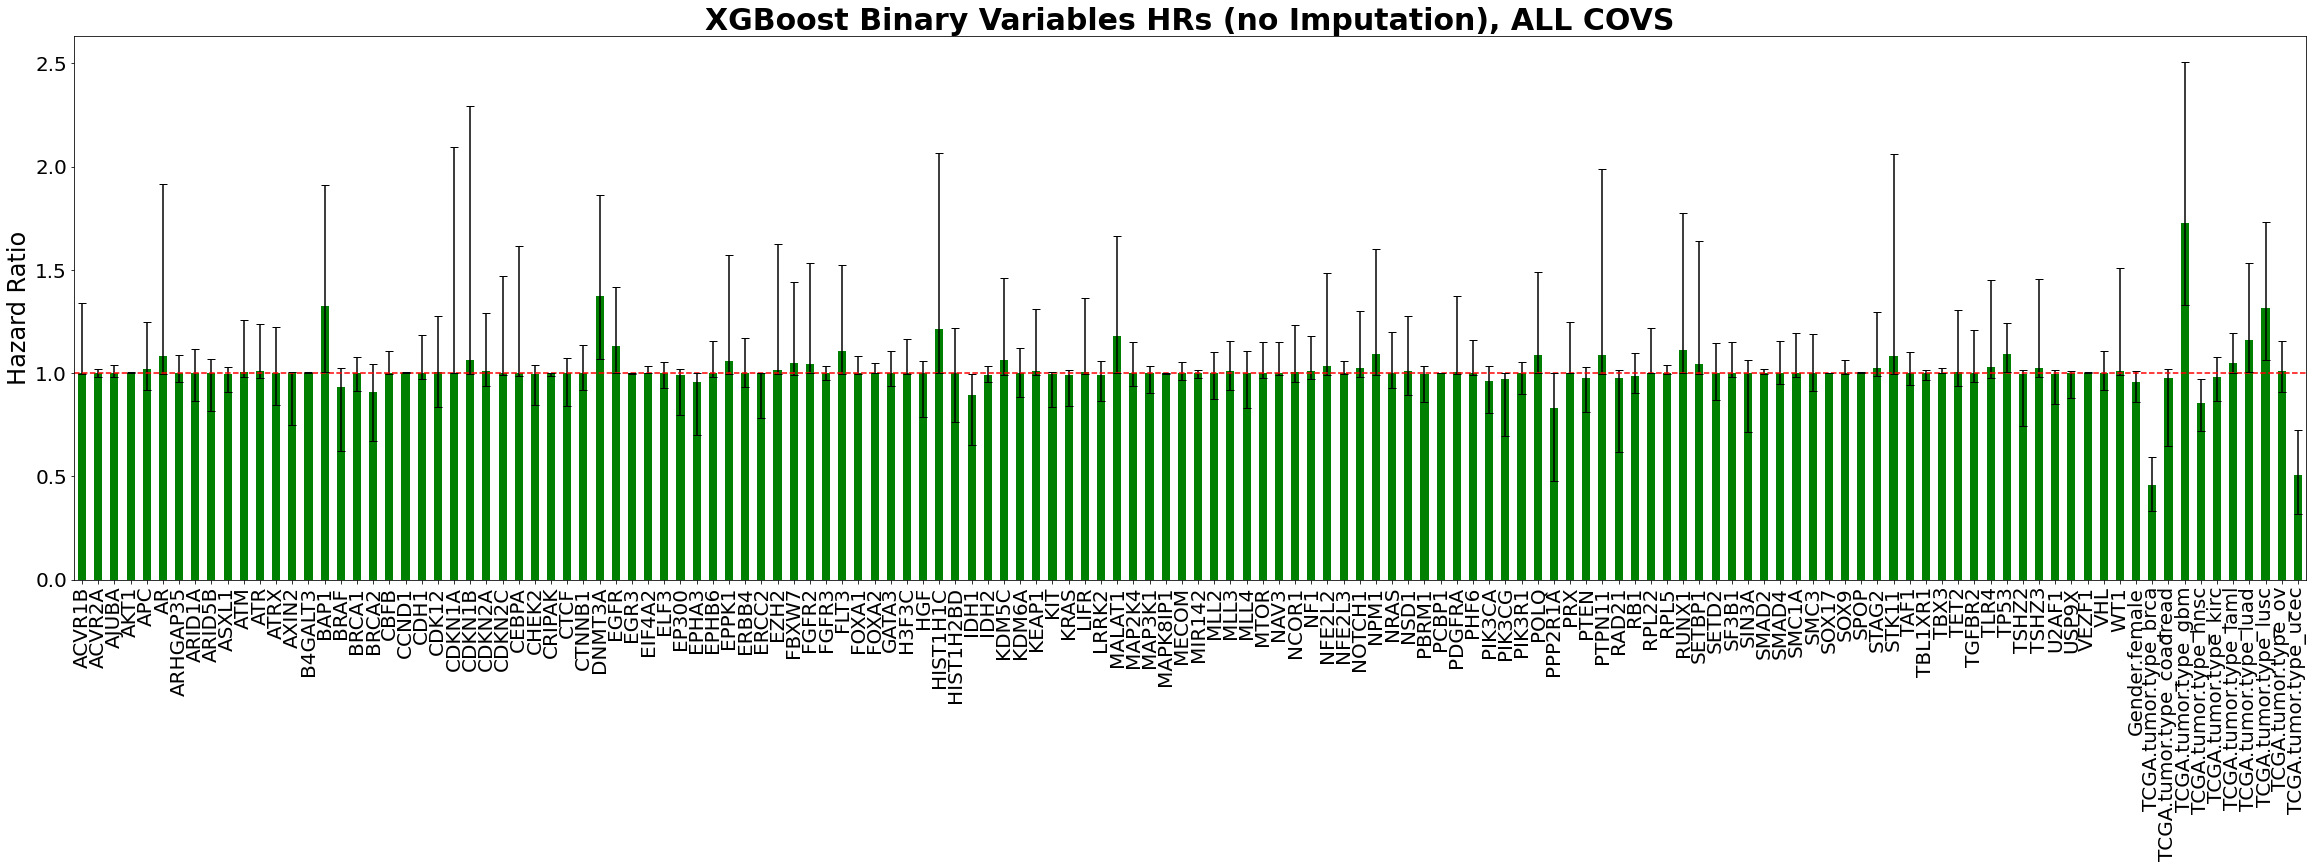

In [97]:
# errorsDict_BinAll = {}
%matplotlib inline
plt.rcParams['figure.figsize'] = [40, 10]
myBins_nImp = [mySummaries_nImp[i] for i in range(len(mySummaries_nImp)) if (X_features_nImp[i] in myBinColsnImp)]
myBinsIndex = [X_features_nImp[i] for i in range(len(mySummaries_nImp)) if (X_features_nImp[i] in myBinColsnImp)]
df_binaries_nImp = pd.DataFrame(myBins_nImp, columns = ["medianHR", "LB_HR", "UB_HR"], index = myBinColsnImp)
errors_bin_nImp = np.array([list(df_binaries_nImp.medianHR - df_binaries_nImp.LB_HR),list(df_binaries_nImp.UB_HR - df_binaries_nImp.medianHR)])
# errorsDict_BinAll["XGB"] = errors_bin_all
# print(errorsDict)
#Binary Variables
ax_bin_nImp = df_binaries_nImp.medianHR.plot.bar(rot=90, color = "Green")
ax_bin_nImp.set_title("XGBoost Binary Variables HRs (no Imputation), ALL COVS", fontsize = 30, weight = 'heavy')
ax_bin_nImp.set_ylabel("Hazard Ratio", fontsize = 24)
ax_bin_nImp.axhline(y=1 , color='r', linestyle='--')
for label in (ax_bin_nImp.get_xticklabels() + ax_bin_nImp.get_yticklabels()):
    label.set_fontsize(20)
plt.errorbar(myBinColsnImp, df_binaries_nImp.medianHR, yerr = errors_bin_nImp, ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'binonly_allcovs_XGB_noImputations.png',  bbox_inches = "tight", dpi = 400)

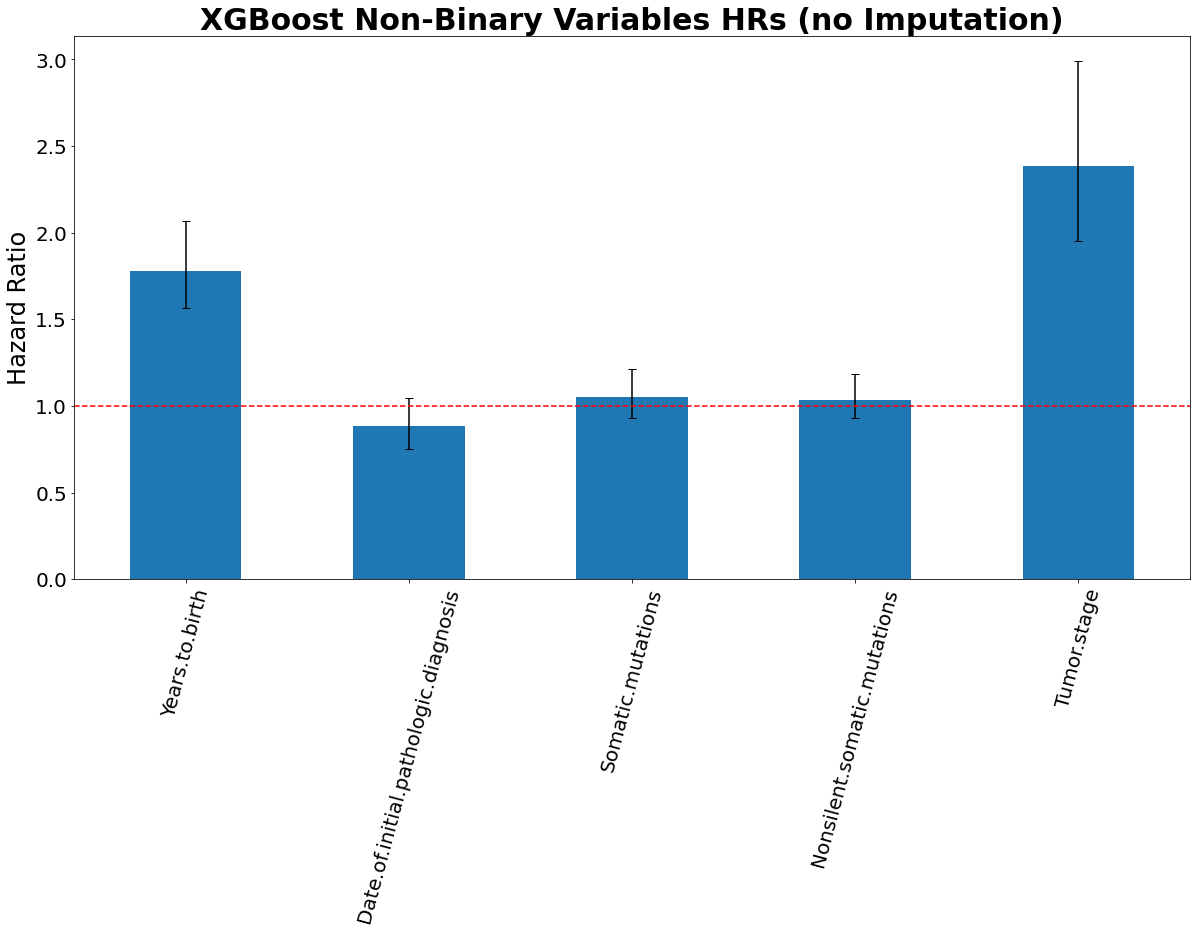

In [103]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
myConts_nImp = [mySummaries_nImp[i] for i in range(len(mySummaries_nImp)) if (X_features_nImp[i] in myContColsnImp)]
df_conts_nImp = pd.DataFrame(myConts_nImp, index = myContColsnImp, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errors_cont_nImp = np.array([list(df_conts_nImp.medianHR - df_conts_nImp.LB_HR),list(df_conts_nImp.UB_HR - df_conts_nImp.medianHR)])


ax_conts_nImp = df_conts_nImp.medianHR.plot.bar(rot=75)
ax_conts_nImp.set_title("XGBoost Non-Binary Variables HRs (no Imputation)", fontsize = 30, weight = "heavy")
ax_conts_nImp.set_ylabel("Hazard Ratio", fontsize = 24)
ax_conts_nImp.axhline(y=1 , color='r', linestyle='--')
for label in (ax_conts_nImp.get_xticklabels() + ax_conts_nImp.get_yticklabels()):
    label.set_fontsize(20)
plt.errorbar(myContColsnImp, df_conts_nImp.medianHR, yerr = errors_cont_nImp, ecolor = 'black', linestyle = 'None', capsize = 4)
# print(df_conts_nImp)
plt.savefig(save_to + 'nonbinonly_allcovs_XGB_noImputations.png',  bbox_inches = "tight", dpi = 400)

## Only Significant Covs

                      medianHR     LB_HR     UB_HR
Years.to.birth        1.777869  1.563168  2.065152
Tumor.stage           2.386268  1.949119  2.988474
BAP1                  1.324605  1.004521  1.909539
DNMT3A                1.374022  1.070138  1.862439
IDH1                  0.896037  0.651644  0.995667
TP53                  1.091182  1.005703  1.240810
TCGA.tumor.type_brca  0.458342  0.333524  0.595806
TCGA.tumor.type_gbm   1.726417  1.328298  2.507974
TCGA.tumor.type_hnsc  0.853090  0.717588  0.971978
TCGA.tumor.type_laml  1.049960  1.001121  1.195614
TCGA.tumor.type_luad  1.160979  1.005047  1.531700
TCGA.tumor.type_lusc  1.316383  1.065085  1.733068
TCGA.tumor.type_ucec  0.504747  0.317885  0.724731


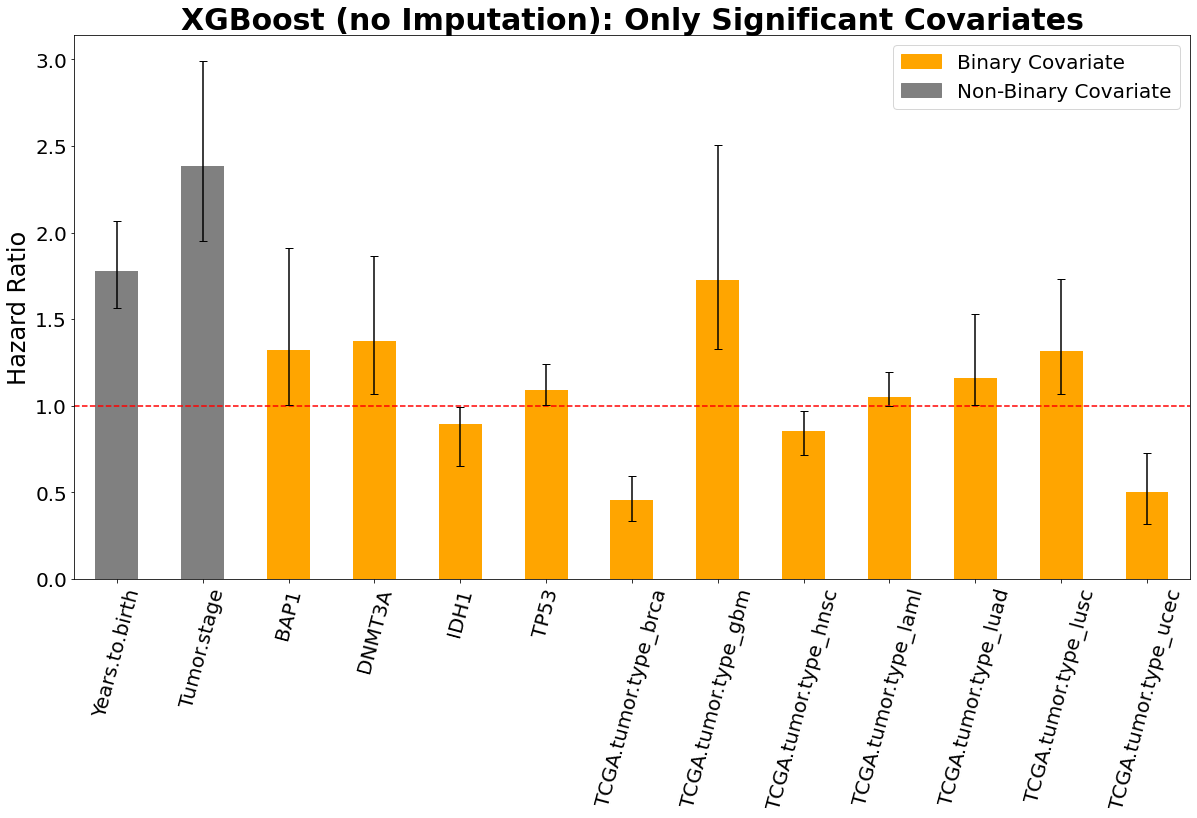

In [134]:
plt.rcParams['figure.figsize'] = [20, 10]
my_SIG_cols = [X_features_nImp[i] for i in range(len(mySummaries_nImp)) if ((mySummaries_nImp[i][1] > 1 and mySummaries_nImp[i][2] > 1) 
                                                                            or (mySummaries_nImp[i][1] < 1 and mySummaries_nImp[i][2] < 1))]

my_SIG_nImp = [mySummaries_nImp[i] for i in range(len(mySummaries_nImp)) if ((mySummaries_nImp[i][1] > 1 and mySummaries_nImp[i][2] > 1) 
                                                                            or (mySummaries_nImp[i][1] < 1 and mySummaries_nImp[i][2] < 1))]

# my_SIG_cols =  my_SIG_cols[:2] + my_SIG_cols[7:] + my_SIG_cols[2:7] #reorder
# my_SIG_nImp =  my_SIG_nImp[:2] + my_SIG_nImp[7:] + my_SIG_nImp[2:7] #reorder

# my_SIG_cols = ["Years", "TumorStage", "TYPE_BRCA", "TYPE_GBM", 
#                "TYPE_HNSC", "TYPE_LAML", "TYPE_LUAD", "TYPE_LUSC", 
#                "TYPE_UCEC", "BAP1", "DNMT3A", "EGFR", "IDH1", "TP53"]

df_SIG_nImp = pd.DataFrame(my_SIG_nImp, index = my_SIG_cols, columns = ["medianHR", "LB_HR", "UB_HR"])
print(df_SIG_nImp)

errors_SIG_nImp = np.array([list(df_SIG_nImp.medianHR - df_SIG_nImp.LB_HR),list(df_SIG_nImp.UB_HR - df_SIG_nImp.medianHR)])

#get plot colors
colors = []
for i in range(14):
    if i > 1:
        colors.append("Orange")
    else:
        colors.append("Grey")
        
Or = mpatches.Patch(color='Orange', label='Binary Covariate')
Gr = mpatches.Patch(color='Grey', label='Non-Binary Covariate')

ax_SIG_nImp = df_SIG_nImp.medianHR.plot.bar(rot=75, color = colors)
ax_SIG_nImp.set_title("XGBoost (no Imputation): Only Significant Covariates", fontsize = 30, weight = "heavy")
ax_SIG_nImp.axhline(y=1 , color='r', linestyle='--')
ax_SIG_nImp.set_ylabel("Hazard Ratio", fontsize = 24)
for label in (ax_SIG_nImp.get_xticklabels() + ax_SIG_nImp.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(handles=[Or, Gr], loc=1, fontsize = 20)
plt.errorbar(my_SIG_cols, df_SIG_nImp.medianHR, yerr = errors_SIG_nImp, ecolor = 'black', linestyle = 'None', capsize = 4)
# print(df_conts_nImp)
plt.savefig(save_to + 'sigonly_allcovs_XGB_noImputations.png',  bbox_inches = "tight", dpi = 400)

In [21]:
origCols_nImp = list(X_features_nImp)
origCols_nImp = origCols_nImp[:5] + origCols_nImp[132:] + origCols_nImp[5:132]
origCols_nImp

['Years.to.birth',
 'Date.of.initial.pathologic.diagnosis',
 'Somatic.mutations',
 'Nonsilent.somatic.mutations',
 'Tumor.stage',
 'Gender.female',
 'TCGA.tumor.type_brca',
 'TCGA.tumor.type_coadread',
 'TCGA.tumor.type_gbm',
 'TCGA.tumor.type_hnsc',
 'TCGA.tumor.type_kirc',
 'TCGA.tumor.type_laml',
 'TCGA.tumor.type_luad',
 'TCGA.tumor.type_lusc',
 'TCGA.tumor.type_ov',
 'TCGA.tumor.type_ucec',
 'ACVR1B',
 'ACVR2A',
 'AJUBA',
 'AKT1',
 'APC',
 'AR',
 'ARHGAP35',
 'ARID1A',
 'ARID5B',
 'ASXL1',
 'ATM',
 'ATR',
 'ATRX',
 'AXIN2',
 'B4GALT3',
 'BAP1',
 'BRAF',
 'BRCA1',
 'BRCA2',
 'CBFB',
 'CCND1',
 'CDH1',
 'CDK12',
 'CDKN1A',
 'CDKN1B',
 'CDKN2A',
 'CDKN2C',
 'CEBPA',
 'CHEK2',
 'CRIPAK',
 'CTCF',
 'CTNNB1',
 'DNMT3A',
 'EGFR',
 'EGR3',
 'EIF4A2',
 'ELF3',
 'EP300',
 'EPHA3',
 'EPHB6',
 'EPPK1',
 'ERBB4',
 'ERCC2',
 'EZH2',
 'FBXW7',
 'FGFR2',
 'FGFR3',
 'FLT3',
 'FOXA1',
 'FOXA2',
 'GATA3',
 'H3F3C',
 'HGF',
 'HIST1H1C',
 'HIST1H2BD',
 'IDH1',
 'IDH2',
 'KDM5C',
 'KDM6A',
 'KEAP1',
 '

In [37]:
changedTitles = ['Years',
 'DateDiagnosis',
 'TumorStage',
 "TYPE_BRCA", 
 "TYPE_COADRED",
 "TYPE_GBM", 
 "TYPE_HNSC",
 "TYPE_KIRC", 
 "TYPE_LAML", 
 "TYPE_LUAD", 
 "TYPE_LUSC",
 "TYPE_OV",
 "TYPE_UCEC",
 'AR',
 'BAP1',
 'CDKN1A',
 'CDKN1B',
 'DNMT3A',
 'EGFR',
 'ERCC2',
 'EZH2',
 'FBXW7',
 'HIST1H1C',
 'IDH1',
 'PPP2R1A',
 'RAD21',
 'RPL22',
 'RUNX1',
 'TP53']

## XGB Best Model (no imp) + Cox Model (imp) 

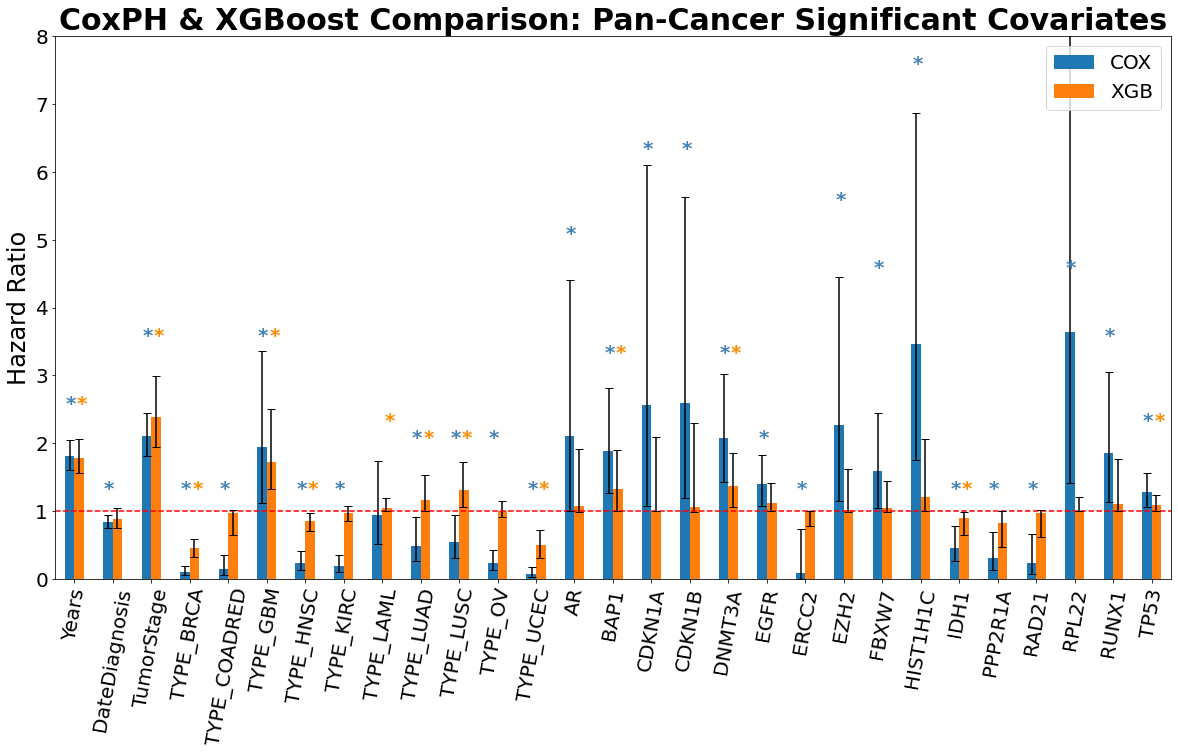

In [157]:
# append lists
errorsDictSignImp = {}
totalCoxList =  HRs_cont_all + list_HRs_all 
mySummaries_reor_nImp = mySummaries_nImp[:5] + mySummaries_nImp[132:] + mySummaries_nImp[5:132] #change to nImp
#get the union of all sig covs
all_sig_covs_nImp = [origCols_nImp[i] for i in range(len(origCols_nImp)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor_nImp[i][1] > 1 and mySummaries_reor_nImp[i][2] > 1) 
                        or (mySummaries_reor_nImp[i][1] < 1 and mySummaries_reor_nImp[i][2] < 1))]


sig_covs_BOTH = [origCols_nImp[i] for i in range(len(origCols_nImp)) 
                    if (((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1))
                       and ((mySummaries_reor_nImp[i][1] > 1 and mySummaries_reor_nImp[i][2] > 1) 
                        or (mySummaries_reor_nImp[i][1] < 1 and mySummaries_reor_nImp[i][2] < 1)))]


# all_sig_covs_names = [tup[0] for tup in all_sig_covs]
# all_sig_covs_numInd = [tup[1] for tup in all_sig_covs]
xgb_nImp_covs = [mySummaries_reor_nImp[i] for i in range(len(origCols_nImp)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor_nImp[i][1] > 1 and mySummaries_reor_nImp[i][2] > 1) 
                        or (mySummaries_reor_nImp[i][1] < 1 and mySummaries_reor_nImp[i][2] < 1))]

cox_nImp_covs = [totalCoxList[i] for i in range(len(origCols_nImp)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor_nImp[i][1] > 1 and mySummaries_reor_nImp[i][2] > 1) 
                        or (mySummaries_reor_nImp[i][1] < 1 and mySummaries_reor_nImp[i][2] < 1))]


#rename
all_sig_covs_nImp = changedTitles

df_cox_sig_nImp = pd.DataFrame(cox_nImp_covs, index = all_sig_covs_nImp, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsCoxSig_nImp = np.array([list(df_cox_sig_nImp.medianHR - df_cox_sig_nImp.LB_HR),list(df_cox_sig_nImp.UB_HR - df_cox_sig_nImp.medianHR)])
errorsDictSignImp["COX"] = errorsCoxSig_nImp

df_xgb_sig_nImp = pd.DataFrame(xgb_nImp_covs, index = all_sig_covs_nImp, columns = ["medianHR", "LB_HR", "UB_HR"])
errorsXGBSig_nImp = np.array([list(df_xgb_sig_nImp.medianHR - df_xgb_sig_nImp.LB_HR),list(df_xgb_sig_nImp.UB_HR - df_xgb_sig_nImp.medianHR)])
errorsDictSignImp["XGB"] = errorsXGBSig_nImp

#All Sig Variables
total_plot_nImp_all = pd.DataFrame({"COX":list(df_cox_sig_nImp.medianHR), 
                          "XGB":list(df_xgb_sig_nImp.medianHR)},
                         index = all_sig_covs_nImp)


cats = all_sig_covs_nImp
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax_nImp = total_plot_nImp_all.plot.bar(rot=80)
ax_nImp.set_title("CoxPH & XGBoost Comparison: Pan-Cancer Significant Covariates", fontsize = 30, weight = "heavy")
ax_nImp.axhline(y=1 , color='r', linestyle='--')
ax_nImp.set_ylabel("Hazard Ratio", fontsize = 24)
ax_nImp.set_ylim((0, 8))
for label in (ax_nImp.get_xticklabels() + ax_nImp.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_sig_nImp.medianHR, yerr = errorsDictSignImp["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_sig_nImp.medianHR, yerr = errorsDictSignImp["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)

# Sig stars

plt.text(0-.225, 2.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(0+.070, 2.5, "*", fontsize= 20,weight="heavy", color = "DarkOrange")

plt.text(1-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")

plt.text(2-.225, 3.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(2+.070, 3.5, "*", fontsize= 20,weight="heavy", color = "DarkOrange")


plt.text(3-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(3+.070, 1.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")

plt.text(4-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(5-.225, 3.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(5+.070, 3.5, "*", fontsize= 20,weight="heavy", color = "DarkOrange")

plt.text(6-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(6+.070, 1.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")

plt.text(7-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")

plt.text(8+.070, 2.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")


plt.text(9-.225, 2, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(9+.070, 2, "*", fontsize= 20,weight="heavy", color = "DarkOrange")

plt.text(10-.225, 2, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(10+.070, 2, "*", fontsize= 20,weight="heavy", color = "DarkOrange")


plt.text(11-.225, 2, "*", fontsize= 20,weight="heavy", color = "SteelBlue")


plt.text(12-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(12+.070, 1.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")

plt.text(13-.225, 5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")


plt.text(14-.225, 3.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(14+.070, 3.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")


plt.text(15-.225, 6.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(16-.225, 6.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")

plt.text(17-.225, 3.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(17+.070, 3.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")
plt.text(18-.225, 2, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
# plt.text(18+.070, 2, "*", fontsize= 20,weight="heavy", color = "DarkOrange")
plt.text(19-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(20-.225, 5.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(21-.225, 4.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(22-.225, 7.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(23-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(23+.070, 1.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")
plt.text(24-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(25-.225, 1.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(26-.225, 4.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(27-.225, 3.5, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(28-.225, 2.25, "*", fontsize= 20,weight="heavy", color = "SteelBlue")
plt.text(28+.070, 2.25, "*", fontsize= 20,weight="heavy", color = "DarkOrange")
plt.savefig(save_to + 'sigonly_allcovs_XGB_COX_noImputations_abstract_fig2.png',  bbox_inches = "tight", dpi = 400)

In [190]:
errorsDictSignImp_co ={}
errorsDictSignImp_co["XGB"] = np.array([list(df_xgb_sig_nImp.medianHR[9:10] - df_xgb_sig_nImp.LB_HR[9:10]),list(df_xgb_sig_nImp.UB_HR[9:10] - df_xgb_sig_nImp.medianHR[9:10])])
errorsDictSignImp_co["COX"] = np.array([list(df_cox_sig_nImp.medianHR[9:10] - df_cox_sig_nImp.LB_HR[9:10]),list(df_cox_sig_nImp.UB_HR[9:10] - df_cox_sig_nImp.medianHR[9:10])])
print(errorsDictSignImp_co["COX"])

[[0.22912487]
 [0.42837094]]


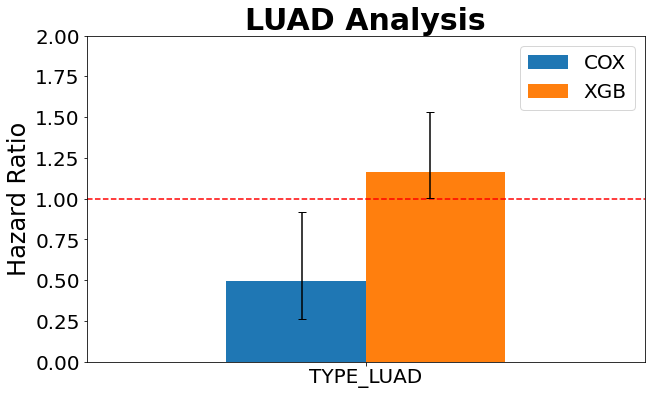

In [191]:
#All Sig Variables
plt.rcParams['figure.figsize'] = [10, 6]
total_plot_nImp_all_conf = pd.DataFrame({"COX":list(df_cox_sig_nImp.medianHR[9:10]), 
                          "XGB":list(df_xgb_sig_nImp.medianHR[9:10])},
                         index = all_sig_covs_nImp[9:10])


cats = all_sig_covs_nImp[9:10]
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax_nImp_co = total_plot_nImp_all_conf.plot.bar(rot=0)
ax_nImp_co.set_title("LUAD Analysis", fontsize = 30, weight = "heavy")
ax_nImp_co.axhline(y=1 , color='r', linestyle='--')
ax_nImp_co.set_ylabel("Hazard Ratio", fontsize = 24)
ax_nImp_co.set_ylim((0, 2))
for label in (ax_nImp_co.get_xticklabels() + ax_nImp_co.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_sig_nImp.medianHR[9:10], yerr = errorsDictSignImp_co["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_sig_nImp.medianHR[9:10], yerr = errorsDictSignImp_co["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'just_LUAD.png',  bbox_inches = "tight", dpi = 400)

In [186]:
errorsDictSignImp_co ={}
errorsDictSignImp_co["XGB"] = np.array([list(df_xgb_sig_nImp.medianHR[10:11] - df_xgb_sig_nImp.LB_HR[10:11]),list(df_xgb_sig_nImp.UB_HR[10:11] - df_xgb_sig_nImp.medianHR[10:11])])
errorsDictSignImp_co["COX"] = np.array([list(df_cox_sig_nImp.medianHR[10:11] - df_cox_sig_nImp.LB_HR[10:11]),list(df_cox_sig_nImp.UB_HR[10:11] - df_cox_sig_nImp.medianHR[10:11])])
print(errorsDictSignImp_co["COX"])

[[0.23197649]
 [0.40324168]]


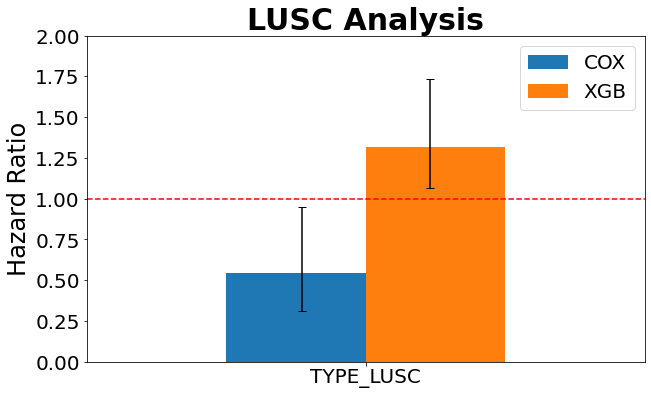

In [189]:
#All Sig Variables
plt.rcParams['figure.figsize'] = [10, 6]
total_plot_nImp_all_conf = pd.DataFrame({"COX":list(df_cox_sig_nImp.medianHR[10:11]), 
                          "XGB":list(df_xgb_sig_nImp.medianHR[10:11])},
                         index = all_sig_covs_nImp[10:11])


cats = all_sig_covs_nImp[10:11]
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax_nImp_co = total_plot_nImp_all_conf.plot.bar(rot=0)
ax_nImp_co.set_title("LUSC Analysis", fontsize = 30, weight = "heavy")
ax_nImp_co.axhline(y=1 , color='r', linestyle='--')
ax_nImp_co.set_ylabel("Hazard Ratio", fontsize = 24)
ax_nImp_co.set_ylim((0, 2))
for label in (ax_nImp_co.get_xticklabels() + ax_nImp_co.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_sig_nImp.medianHR[10:11], yerr = errorsDictSignImp_co["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_sig_nImp.medianHR[10:11], yerr = errorsDictSignImp_co["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.savefig(save_to + 'just_LUSC.png',  bbox_inches = "tight", dpi = 400)

In [59]:
df_xgb_sig_nImp

medianHR     LB_HR     UB_HR
Years          1.777869  1.563168  2.065152
DateDiagnosis  0.885225  0.753324  1.043189
TumorStage     2.386268  1.949119  2.988474
TYPE_BRCA      0.458342  0.333524  0.595806
TYPE_COADRED   0.974204  0.645356  1.019782
TYPE_GBM       1.726417  1.328298  2.507974
TYPE_HNSC      0.853090  0.717588  0.971978
TYPE_KIRC      0.980059  0.863150  1.078666
TYPE_LAML      1.049960  1.001121  1.195614
TYPE_LUAD      1.160979  1.005047  1.531700
TYPE_LUSC      1.316383  1.065085  1.733068
TYPE_OV        1.008350  0.910375  1.154723
TYPE_UCEC      0.504747  0.317885  0.724731
AR             1.084597  0.997083  1.915653
BAP1           1.324605  1.004521  1.909539
CDKN1A         1.001181  0.999779  2.094094
CDKN1B         1.064516  0.997478  2.294537
DNMT3A         1.374022  1.070138  1.862439
EGFR           1.129403  0.998689  1.415590
ERCC2          0.999543  0.784311  1.001279
EZH2           1.015685  0.997687  1.624288
FBXW7          1.050123  0.990118  1.440003
HIST1H1C       1.214237  1.000000  2.065567
IDH1           0.896037  0.651644  0.995667
PPP2R1A        0.832626  0.475525  1.000116
RAD21          0.978180  0.619063  1.014792
RPL22          1.000000  0.998814  1.218274
RUNX1          1.111685  0.999351  1.775645
TP53           1.091182  1.005703  1.240810

In [77]:
#Check to see where we predict means are close
agreementListMeds = [origCols_nImp[i] for i in range(len(origCols_nImp)) 
                     #if both > 1
                    if ((totalCoxList[i][0] >= 1 and mySummaries_reor_nImp[i][0] >= 1)
                        or (totalCoxList[i][0] < 1 and mySummaries_reor_nImp[i][0] < 1))]
                     
len(agreementListMeds)

104

In [78]:
#Check where we agree:
agreementListCovs = [origCols_nImp[i] for i in range(len(origCols_nImp)) 
                     #if both > 1
                    if (((totalCoxList[i][2] > 1 and totalCoxList[i][2]) > 1 and 
                        (mySummaries_reor_nImp[i][1] > 1 and mySummaries_reor_nImp[i][2] > 1)) 
                     # if both < 1
                        or ((totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1) and 
                     (mySummaries_reor_nImp[i][1] < 1 and mySummaries_reor_nImp[i][2] < 1)))]
                     
len(agreementListCovs)

11

In [79]:
#Check to see where we predict mean are close
agreementListMeans_ofsig = [all_sig_covs_nImp[i] for i in range(len(all_sig_covs_nImp)) 
                     #if both > 1
                    if ((xgb_nImp_covs[i][0] >= 1 and cox_nImp_covs[i][0] >= 1)
                        or (xgb_nImp_covs[i][0] < 1 and cox_nImp_covs[i][0] < 1))]
                 
len(agreementListMeans_ofsig)

25

In [80]:
len(all_sig_covs_nImp)

29

In [53]:
sig_covs_BOTH

['Years.to.birth',
 'Tumor.stage',
 'TCGA.tumor.type_brca',
 'TCGA.tumor.type_gbm',
 'TCGA.tumor.type_hnsc',
 'TCGA.tumor.type_luad',
 'TCGA.tumor.type_lusc',
 'TCGA.tumor.type_ucec',
 'BAP1',
 'DNMT3A',
 'IDH1',
 'TP53']

In [54]:
all_sig_covs_nImp

['Years',
 'DateDiagnosis',
 'TumorStage',
 'TYPE_BRCA',
 'TYPE_COADRED',
 'TYPE_GBM',
 'TYPE_HNSC',
 'TYPE_KIRC',
 'TYPE_LAML',
 'TYPE_LUAD',
 'TYPE_LUSC',
 'TYPE_OV',
 'TYPE_UCEC',
 'AR',
 'BAP1',
 'CDKN1A',
 'CDKN1B',
 'DNMT3A',
 'EGFR',
 'ERCC2',
 'EZH2',
 'FBXW7',
 'HIST1H1C',
 'IDH1',
 'PPP2R1A',
 'RAD21',
 'RPL22',
 'RUNX1',
 'TP53']

In [ ]:
 xgb_scores_nImp


# Boxplots of Model Comparison

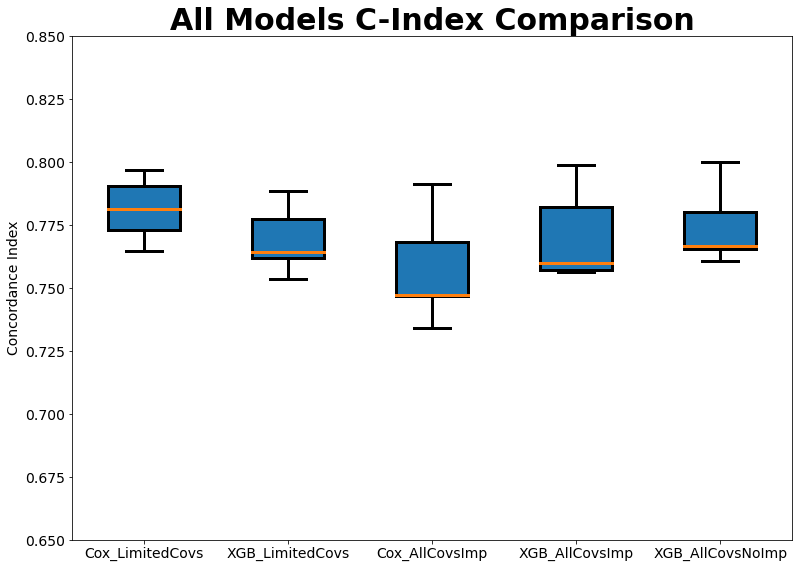

In [125]:
Cox_all = [0.7466364, 0.7911606, 0.7679637, 0.7341046, 0.7471551]
Cox_limitedcovs = [0.7968867, 0.7813753, 0.7727417, 0.7902709, 0.7645715]
box_data = [Cox_limitedcovs, xgb_scores, Cox_all, xgb_scores_all, xgb_scores_nImp]
# print(box_data)
fig = plt.figure(figsize =(10, 7)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_xticklabels(['Cox_LimitedCovs', 'XGB_LimitedCovs', 'Cox_AllCovsImp', 'XGB_AllCovsImp', 'XGB_AllCovsNoImp'])
ax.set_title("All Models C-Index Comparison", fontsize = 30, weight = 'bold')
ax.set_ylabel("Concordance Index", fontsize = 14)
ax.set_ylim(0.65, 0.85)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
# Creating plot 
bp = ax.boxplot(box_data, patch_artist=True) 

for median in bp['medians']:
    median.set(linewidth=3)

for box in bp['boxes']:
# change outline color
    box.set(linewidth=3)

for whisker in bp['whiskers']:
    whisker.set(linewidth =3)

for cap in bp['caps']:
    cap.set(linewidth=3)

# show plot 
plt.savefig(save_to + 'allmodels_boxplot_XGB_COX.png',  bbox_inches = "tight", dpi = 400)
plt.show() 

In [98]:
xgb_scores_nImp

[0.7800129785853342,
 0.7998829154063811,
 0.766468867073204,
 0.7653107107527204,
 0.7605326687952652]

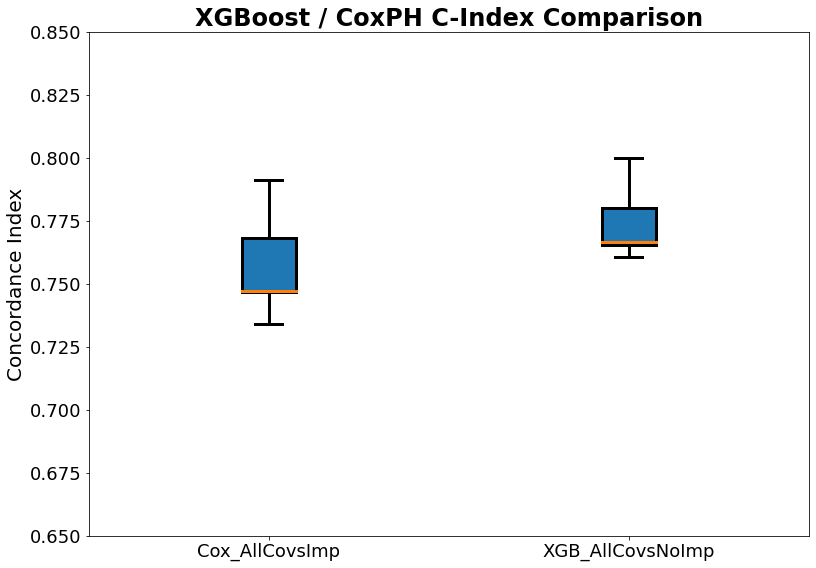

In [97]:
Cox_all = [0.7466364, 0.7911606, 0.7679637, 0.7341046, 0.7471551]
xgb_score_nImp = [0.7800129785853342,
 0.7998829154063811,
 0.766468867073204,
 0.7653107107527204,
 0.7605326687952652]
# box_data = [Cox_all, xgb_scores_all, xgb_scores_nImp]
box_data = [Cox_all , xgb_scores_nImp]
# print(box_data)
fig = plt.figure(figsize =(10, 7)) 
  
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'24', 'color':'black', 'weight':'heavy'} # Bottom vertical alignment for more space
axis_font = {'size':'20'}
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
ax.set_xticklabels(['Cox_AllCovsImp', 'XGB_AllCovsNoImp'])
ax.set_title("XGBoost / CoxPH C-Index Comparison", **title_font)
ax.set_ylabel("Concordance Index", **axis_font)
ax.set_ylim(0.65, 0.85)



# for item in [ax.title]:
#     item.set_fontsize(20)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(18)

# Creating plot 
bp = ax.boxplot(box_data, patch_artist=True) 

for median in bp['medians']:
    median.set(linewidth=3)

for box in bp['boxes']:
# change outline color
    box.set(linewidth=3)

for whisker in bp['whiskers']:
    whisker.set(linewidth =3)

for cap in bp['caps']:
    cap.set(linewidth=3)

# show plot 
plt.savefig(save_to + 'selectedmodels_boxplot_XGB_COX.png', bbox_inches = "tight", dpi = 400)
plt.show() 

# Intro SHAP Analysis

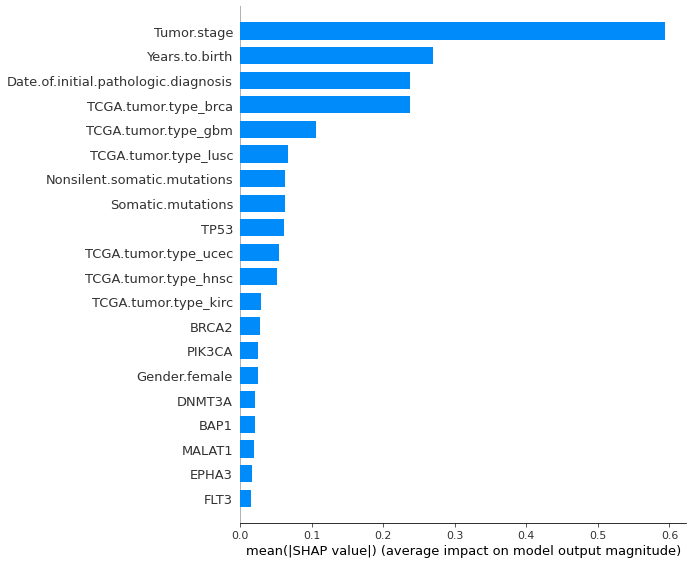

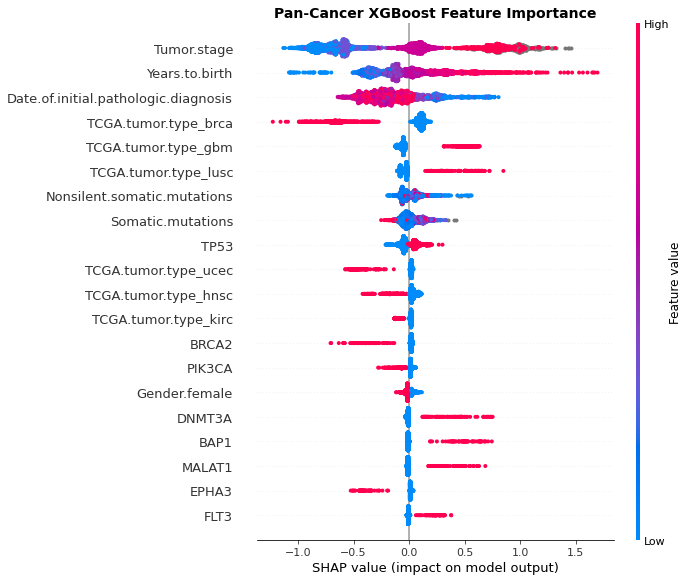

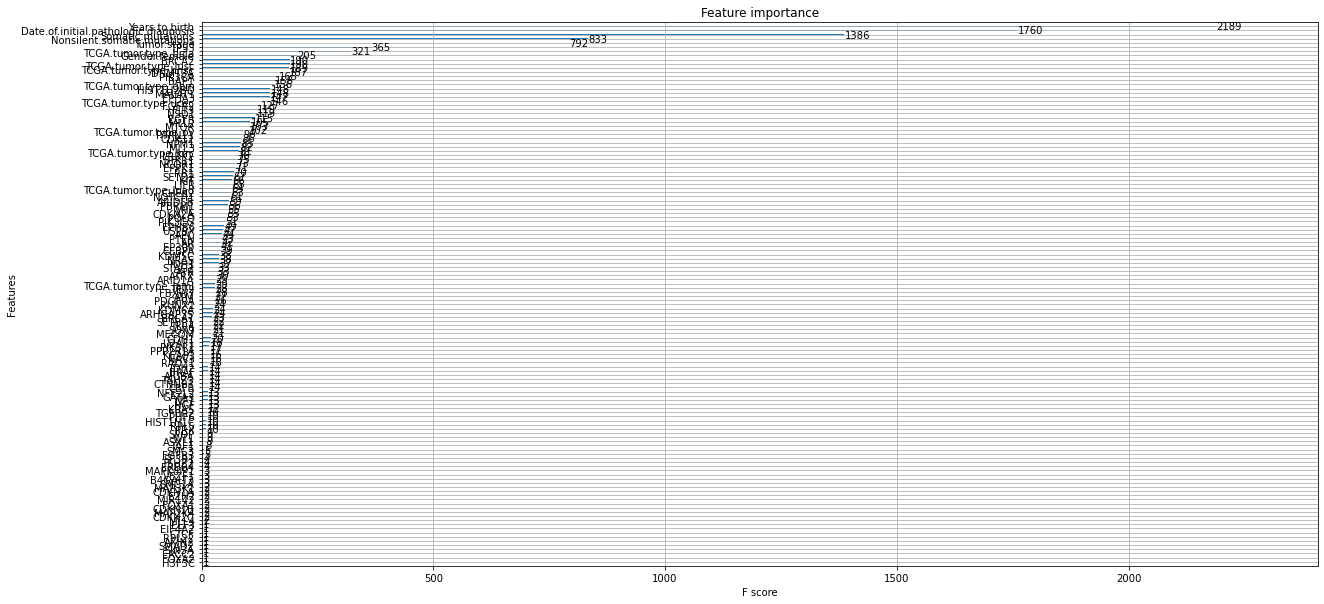

In [142]:
#Model trained, using for SHAP analysis
xgb_best_hyperparams_nImp = {'eta': 0.008962444415614479, 'max_depth': 4, 
                             'min_child_weight': 0.001437972545132937, 
                             'reg_alpha': 1.1232200335301026, 
                             'reg_lambda': 3.3630064936381747, 'subsample': 0.9173916027145035, 
                             'objective': 'survival:cox'}

X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
y_train = X_train['y'] #y train are X_trains y column
X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
X_test = full_xy.drop(X_train.index) #test features are the full - X_train
y_test = X_test['y'] #y test are X_tests y column
X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)
model_train_SHAP = xgboost.train(xgb_best_hyperparams_nImp, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
shap_values_nImp = shap.TreeExplainer(model_train_SHAP).shap_values(X_nature_nImp)
    
shap.summary_plot(shap_values_nImp, X_nature_nImp, plot_type="bar")
shap.summary_plot(shap_values_nImp, X_nature_nImp, show = False)
plt.title("Pan-Cancer XGBoost Feature Importance", fontsize = 14, weight = 'bold')
plt.savefig(save_to + "importance_plot_all_XGBoost_nImp.png",  bbox_inches = "tight", dpi = 400) 
xgboost.plot_importance(model_train_SHAP)

## Look at the variables that are opposite CoxPH

## Tumor LUAD

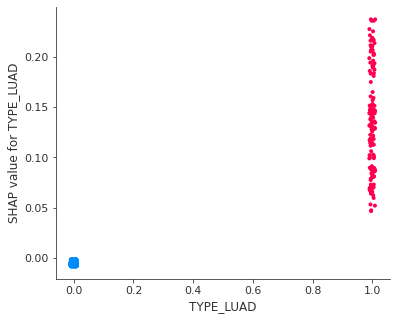

In [153]:
shap.dependence_plot("TCGA.tumor.type_luad", shap_values_nImp,
                     X_nature_nImp, interaction_index = 'TCGA.tumor.type_luad', x_jitter = 0.02, show = False)
plt.ylabel("SHAP value for TYPE_LUAD", fontsize = 12)
plt.xlabel("TYPE_LUAD", fontsize = 12)
plt.savefig(save_to + "dependence_plot_luad.png",  bbox_inches = "tight", dpi = 400) 
plt.show()

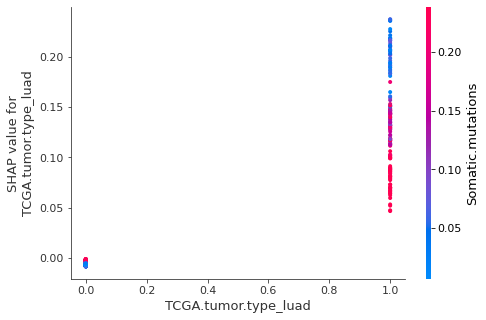

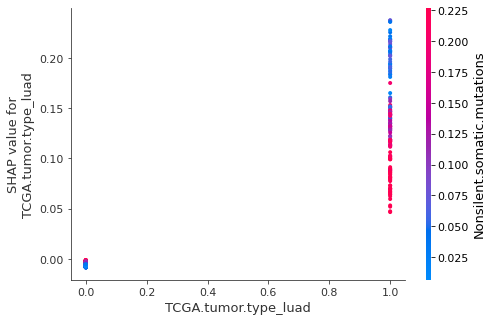

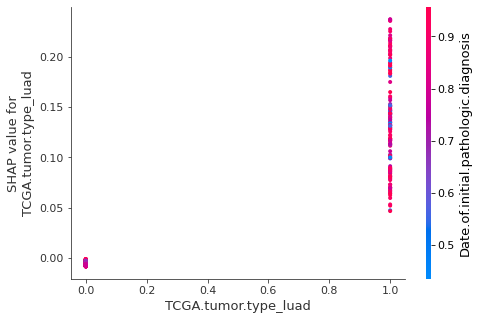

In [144]:
inds = shap.approximate_interactions("TCGA.tumor.type_luad", shap_values_nImp, X_nature_nImp)
for i in range(3):
    shap.dependence_plot("TCGA.tumor.type_luad", shap_values_nImp, X_nature_nImp, interaction_index=inds[i])

## Tumor LUSC

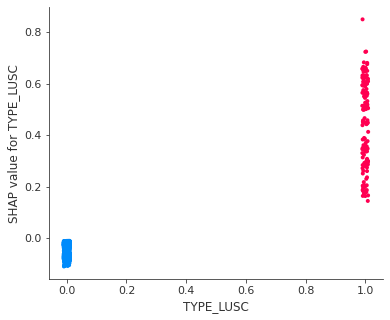

In [154]:
shap.dependence_plot("TCGA.tumor.type_lusc", shap_values_nImp,
                     X_nature_nImp, interaction_index = 'TCGA.tumor.type_lusc', x_jitter = 0.02, show = False)
plt.ylabel("SHAP value for TYPE_LUSC", fontsize = 12)
plt.xlabel("TYPE_LUSC", fontsize = 12)
plt.savefig(save_to + "dependence_plot_lusc.png",  bbox_inches = "tight", dpi = 400) 
plt.show()

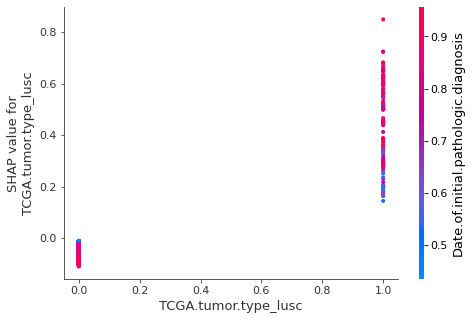

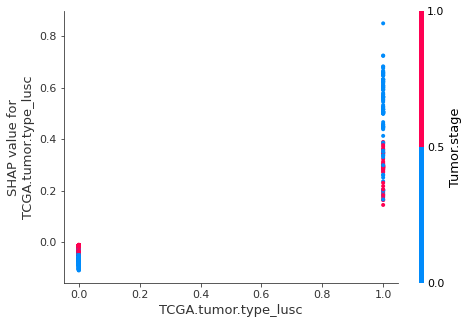

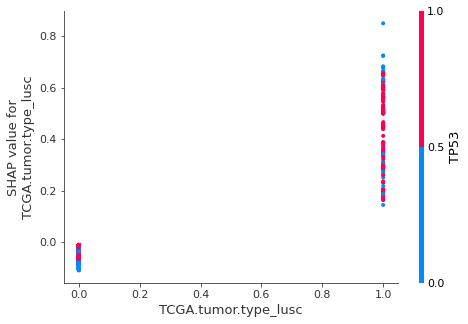

In [155]:
inds = shap.approximate_interactions("TCGA.tumor.type_lusc", shap_values_nImp, X_nature_nImp)
for i in range(3):
    shap.dependence_plot("TCGA.tumor.type_lusc", shap_values_nImp, X_nature_nImp, interaction_index=inds[i])

## Exploratory SHAP

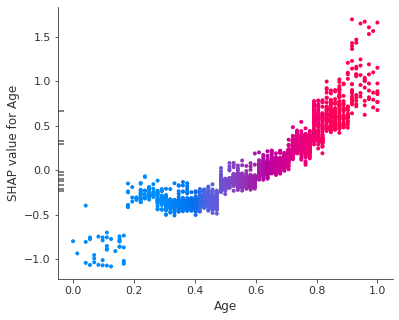

In [168]:
shap.dependence_plot("Years.to.birth", shap_values_nImp,
                     X_nature_nImp, interaction_index = 'Years.to.birth', show = False)
plt.ylabel("SHAP value for Age", fontsize = 12)
plt.xlabel("Age", fontsize = 12)
plt.savefig(save_to + "dependence_plot_years.png",  bbox_inches = "tight", dpi = 400) 
plt.show()

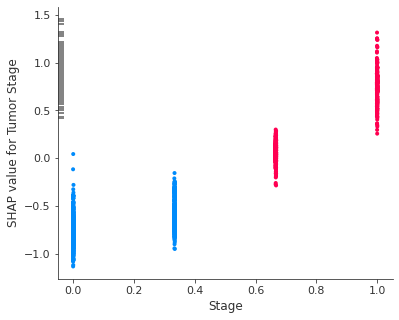

In [166]:
shap.dependence_plot("Tumor.stage", shap_values_nImp,
                     X_nature_nImp, interaction_index = "Tumor.stage", x_jitter = 0.005, show = False)
plt.ylabel("SHAP value for Tumor Stage", fontsize = 12)
plt.xlabel("Stage", fontsize = 12)
plt.savefig(save_to + "dependence_plot_tumor.png",  bbox_inches = "tight", dpi = 400) 
plt.show()